In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import re
from functools import reduce

In [2]:
data_path = '/project2/kribelba_1515/saadawy/mpra/upstream'
enhancer_bc_counts = pd.read_csv('enhancer_barcode_count_upstream.tsv', sep='\t')
mpra_raw_data = pd.read_csv('df_for_mpra_upstream.tsv', sep='\t')

In [3]:
csv_files = [file for file in os.listdir(data_path) if file.endswith('.csv')]

df_list = []

for file in csv_files:
    file_path = os.path.join(data_path, file)

    match = re.search(r'(agg_[^_]+_norm_[^_]+)', file)

    identifier = match.group(1)

    df = pd.read_csv(file_path, usecols=['logFC', 'SE', 'uid'])

    df = df.rename(columns={
        'logFC': f'logFC_{identifier}',
        'SE': f'SE_{identifier}'
    })

    df_list.append(df)

merged_df = reduce(lambda left, right: pd.merge(left, right, on='uid'), df_list)

merged_df = merged_df[[c for c in merged_df.columns if c != 'uid'] + ['uid']]

merged_df = merged_df.rename(columns={'uid': 'Enhancer'})

merged_df = pd.merge(merged_df, enhancer_bc_counts, on='Enhancer')

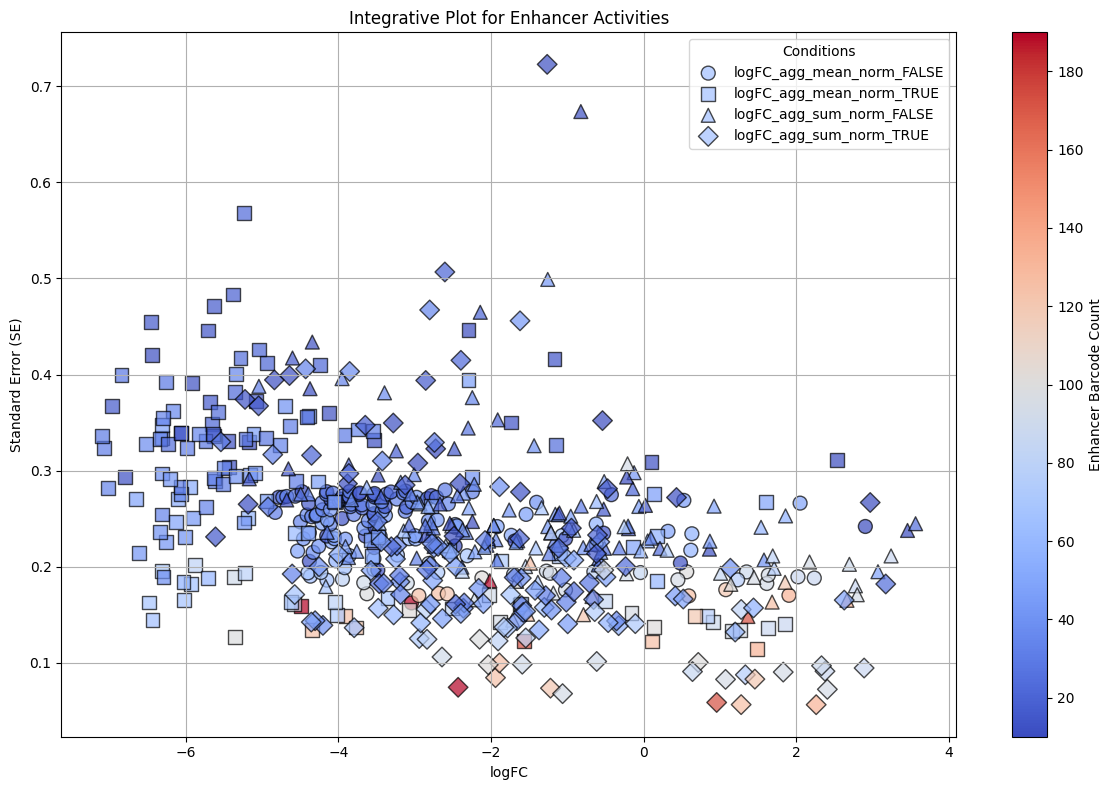

In [4]:
conditions = [
    'logFC_agg_mean_norm_FALSE', 'logFC_agg_mean_norm_TRUE',
    'logFC_agg_sum_norm_FALSE', 'logFC_agg_sum_norm_TRUE'
]

se_conditions = [
    'SE_agg_mean_norm_FALSE', 'SE_agg_mean_norm_TRUE',
    'SE_agg_sum_norm_FALSE', 'SE_agg_sum_norm_TRUE'
]

logFC_data = merged_df[conditions]
SE_data = merged_df[se_conditions]
enhancers = merged_df['Enhancer']
barcode_counts = merged_df['Enhancer_barcode_count']

plt.figure(figsize=(12, 8))

norm = plt.Normalize(barcode_counts.min(), barcode_counts.max())
cmap = plt.get_cmap('coolwarm')
markers = ['o', 's', '^', 'D']

for i, condition in enumerate(conditions):
    plt.scatter(
        logFC_data.iloc[:, i], SE_data.iloc[:, i],
        c=barcode_counts, cmap=cmap, norm=norm,
        label=condition, edgecolors='black', alpha=0.7,
        s=100, marker=markers[i]
    )

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=plt.gca())
cbar.set_label('Enhancer Barcode Count')

plt.xlabel('logFC')
plt.ylabel('Standard Error (SE)')
plt.title('Integrative Plot for Enhancer Activities')

plt.grid(True)
plt.legend(title='Conditions', loc='best')

plt.tight_layout()
plt.show()

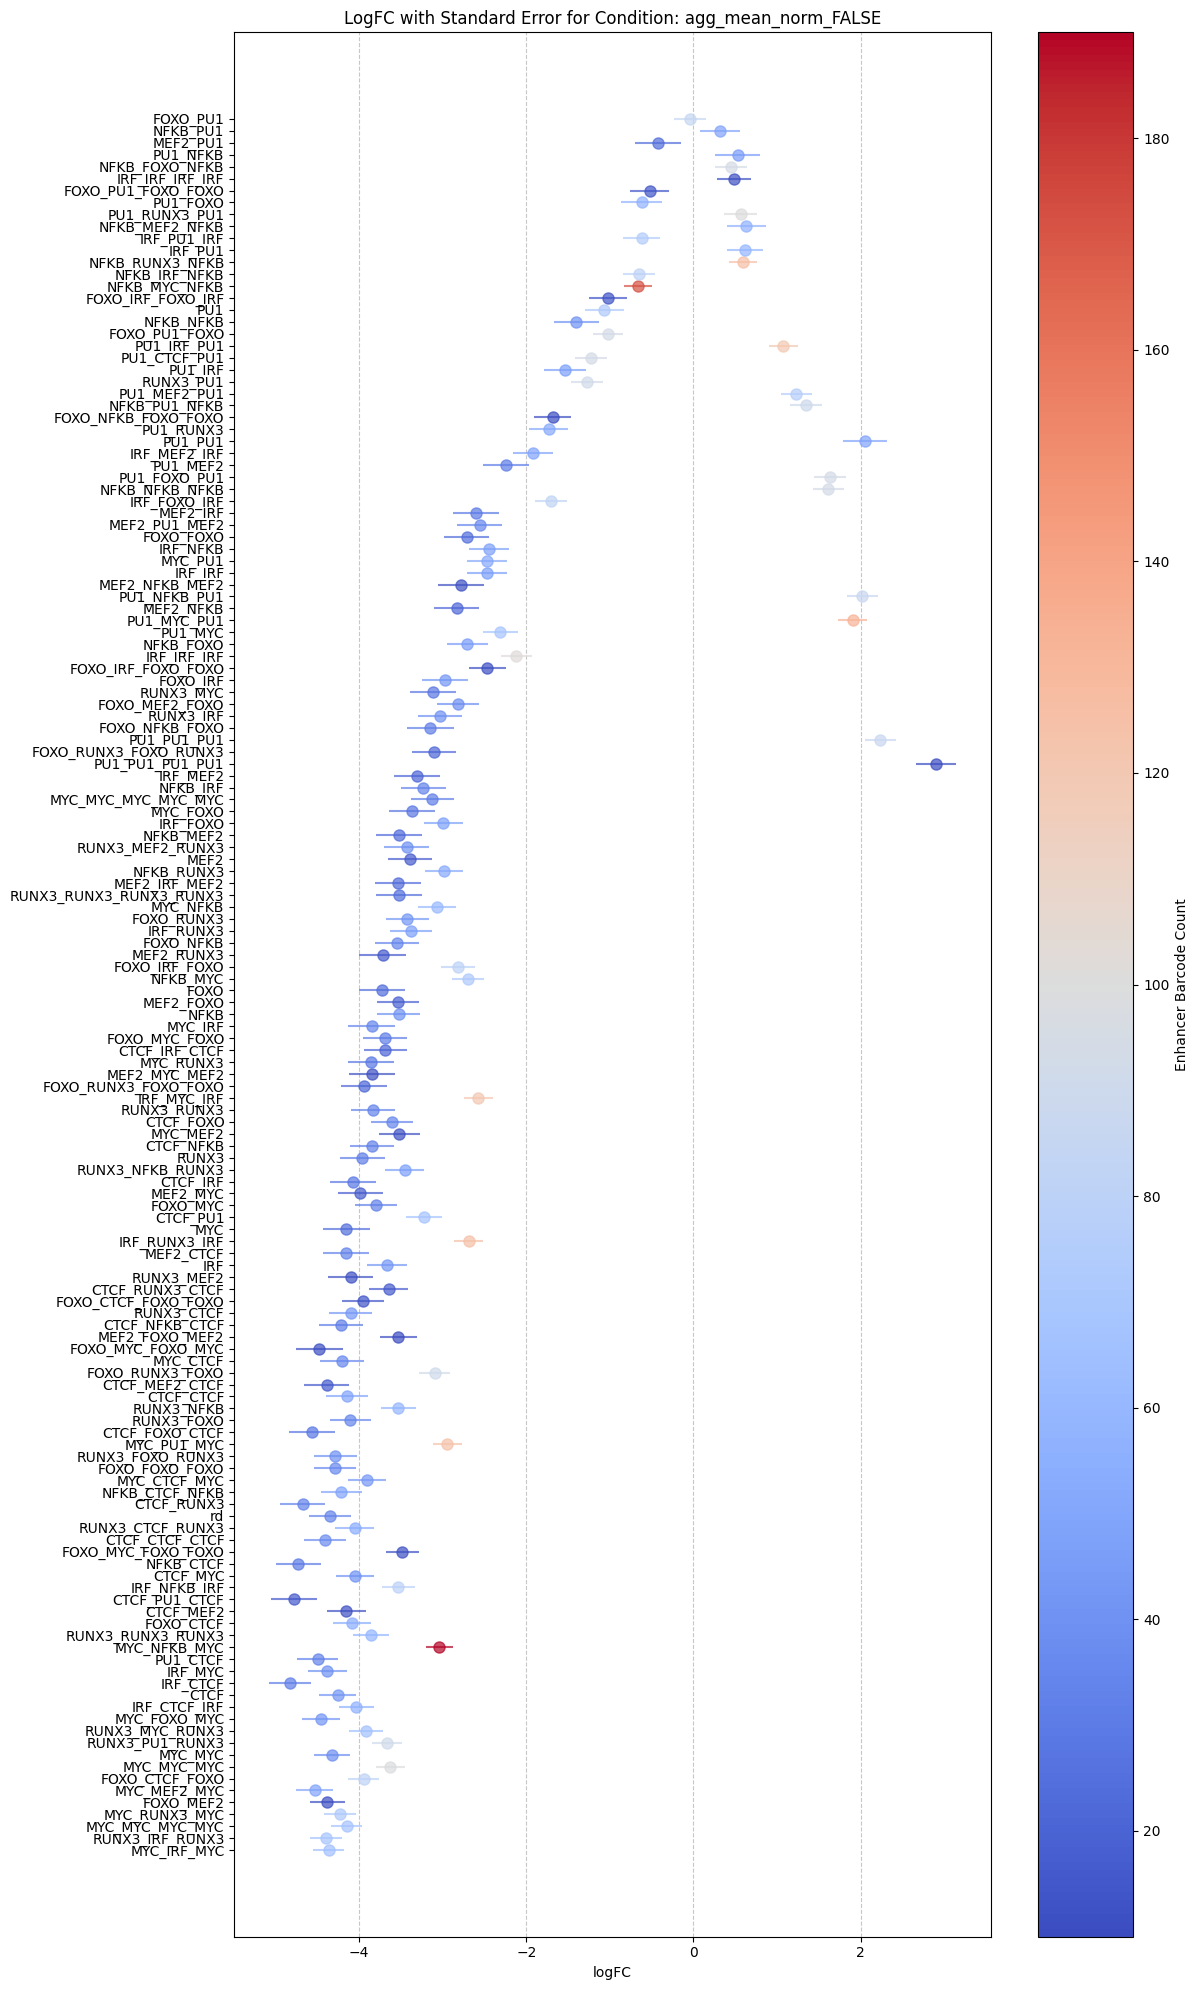

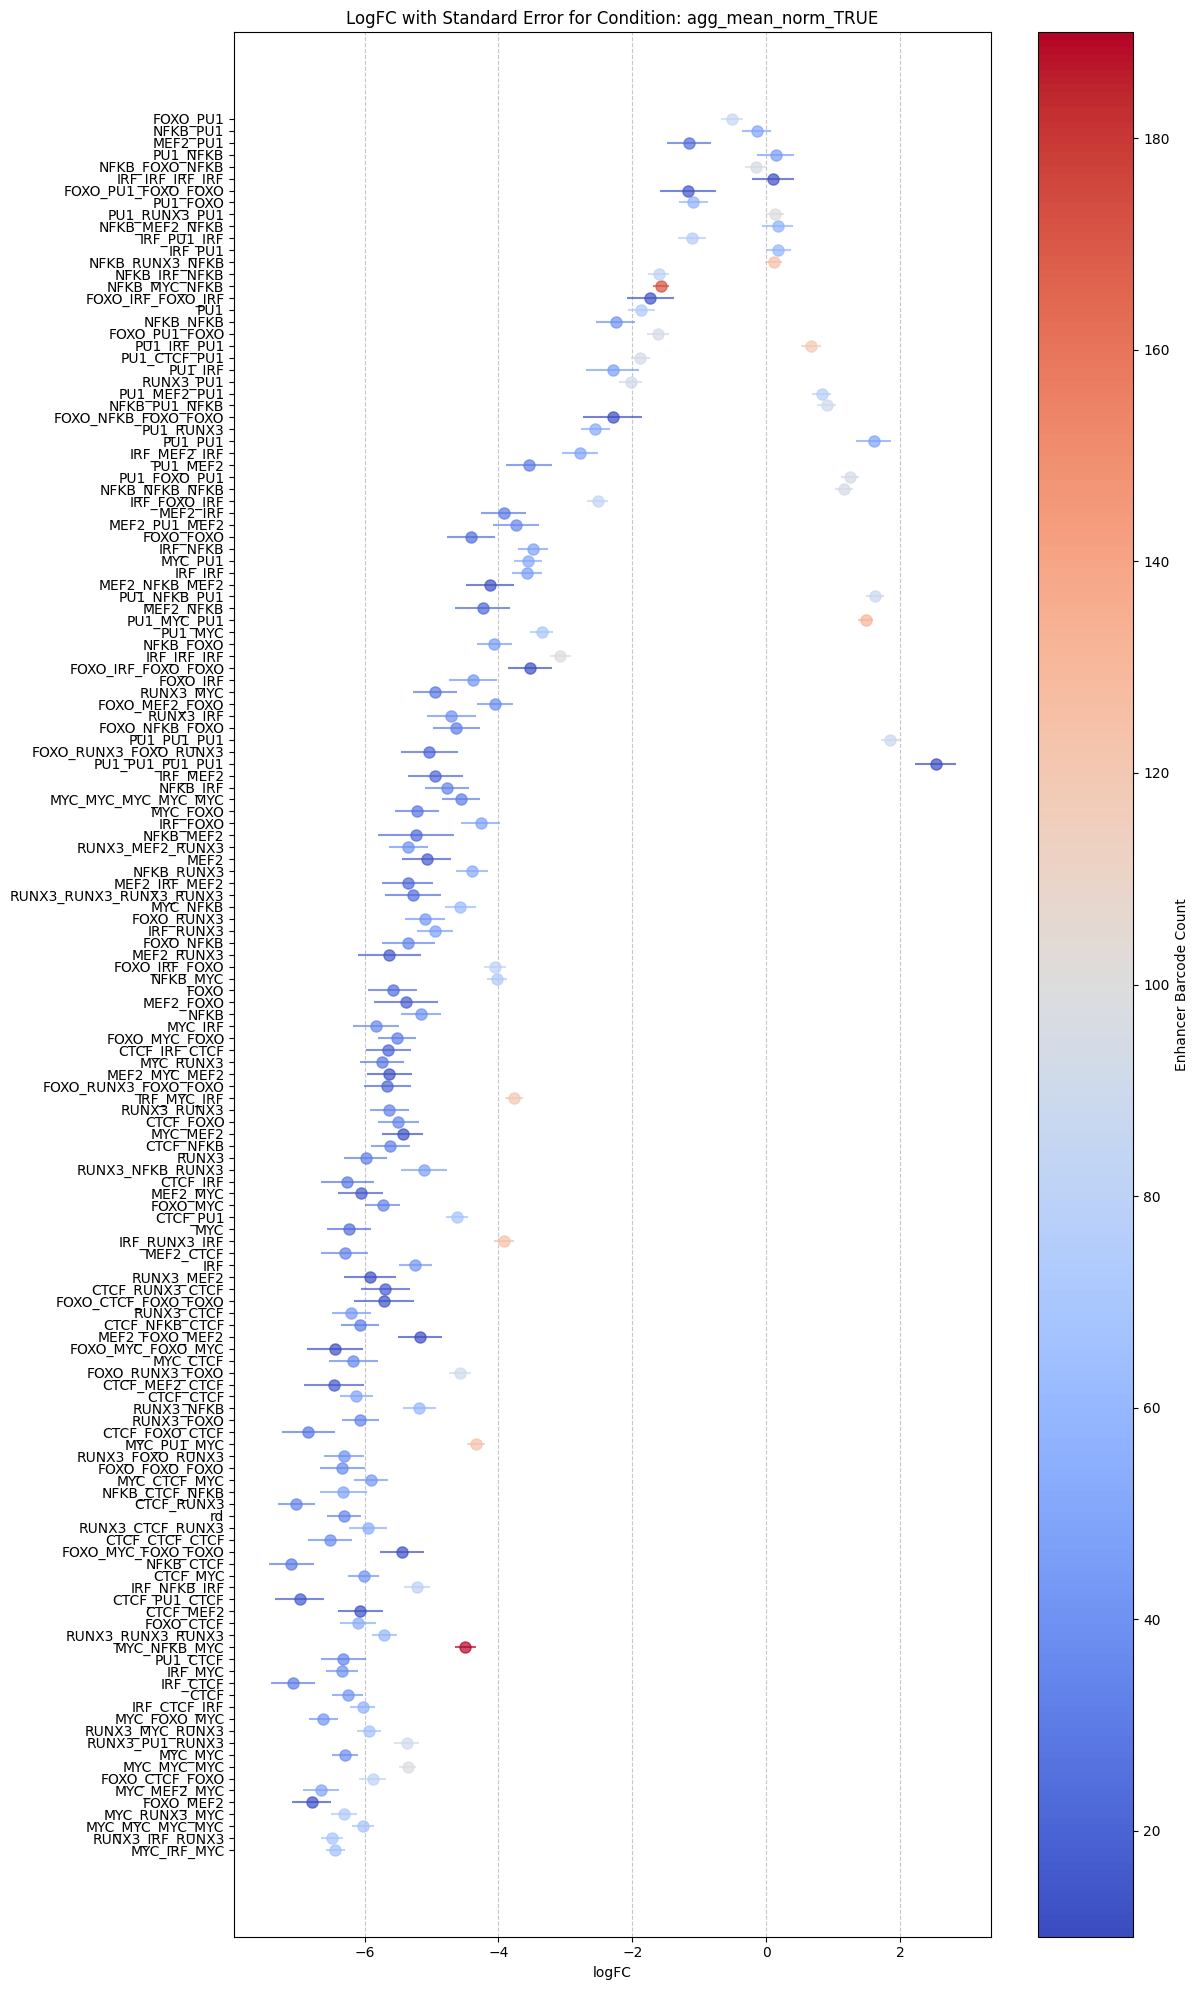

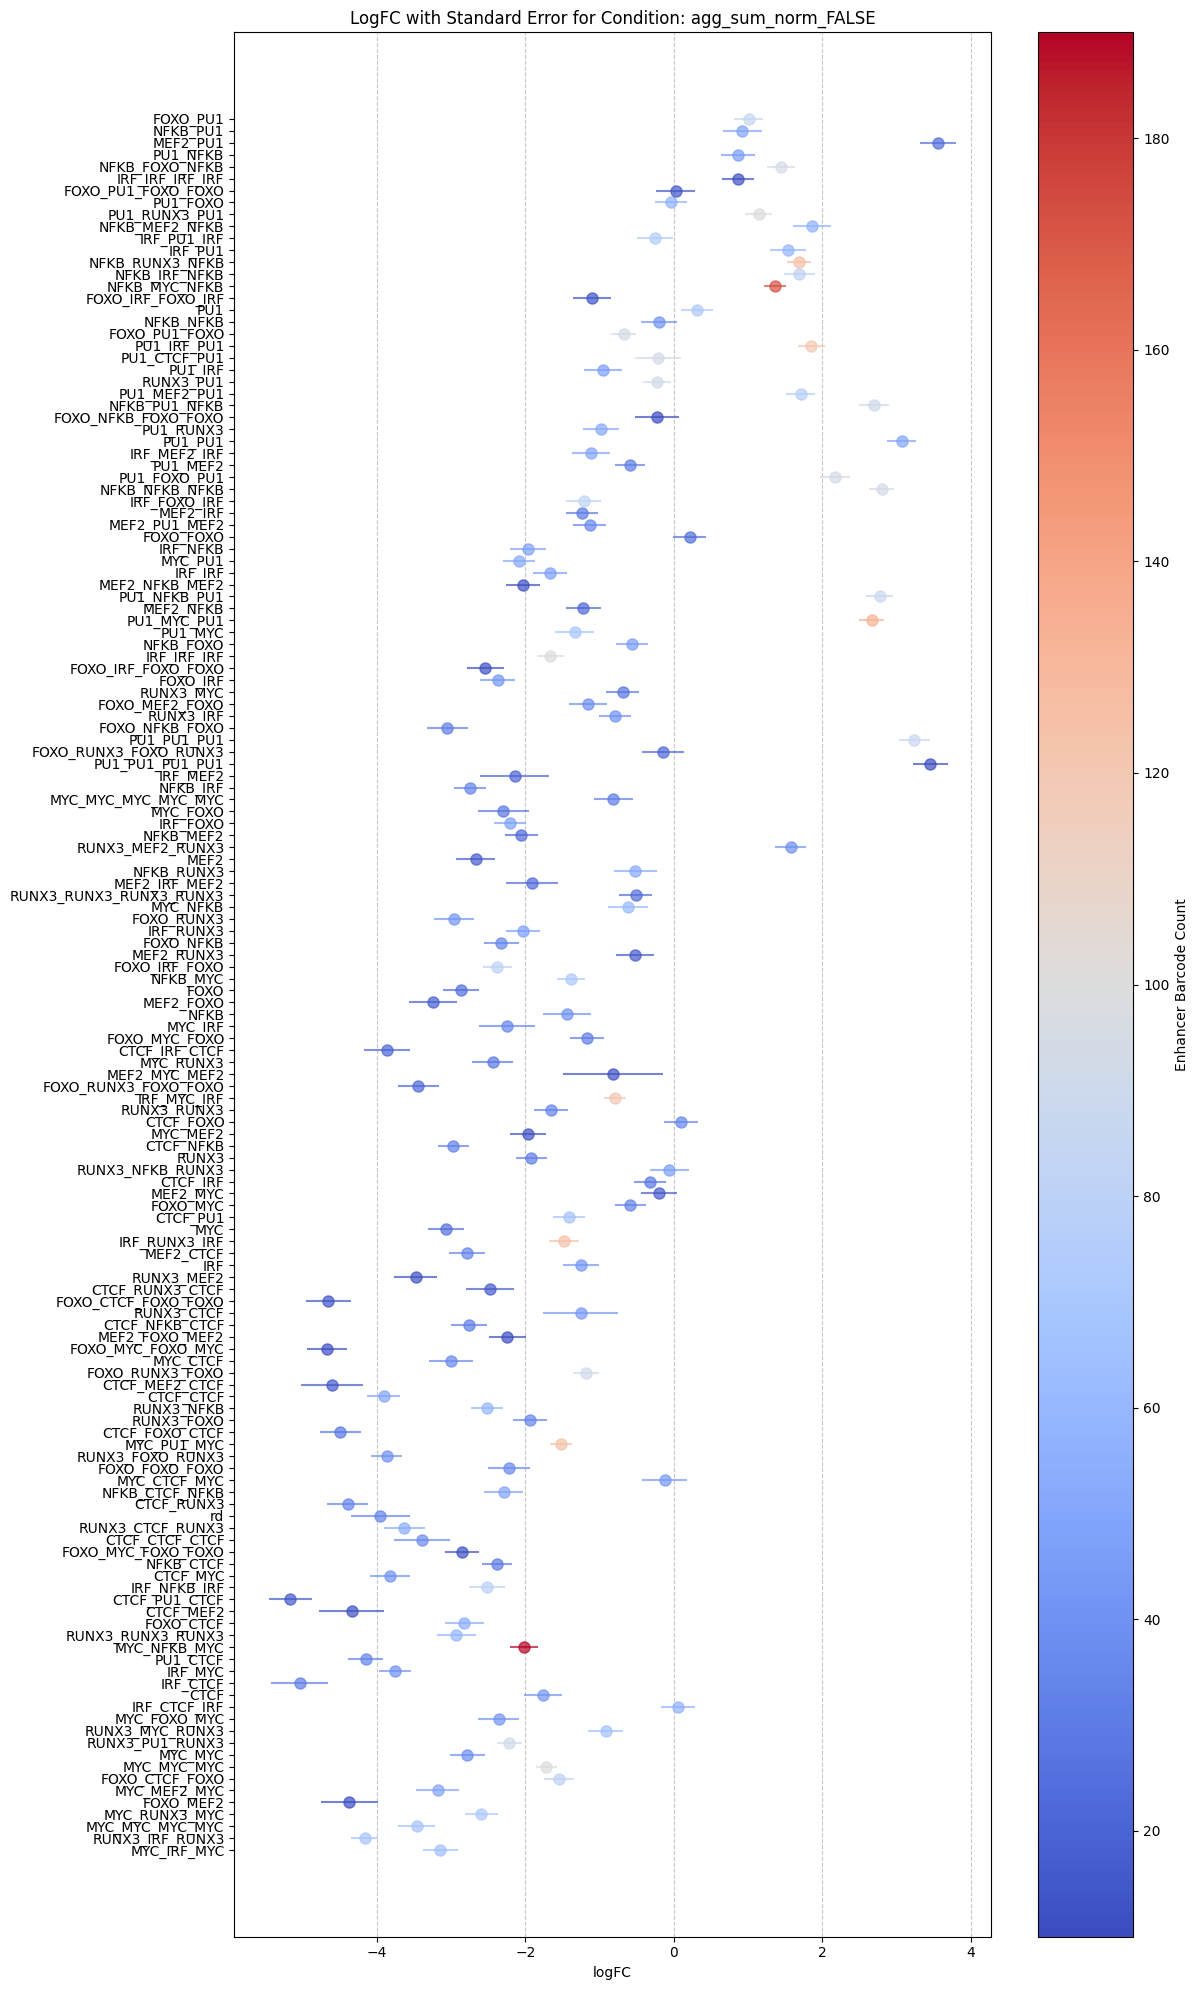

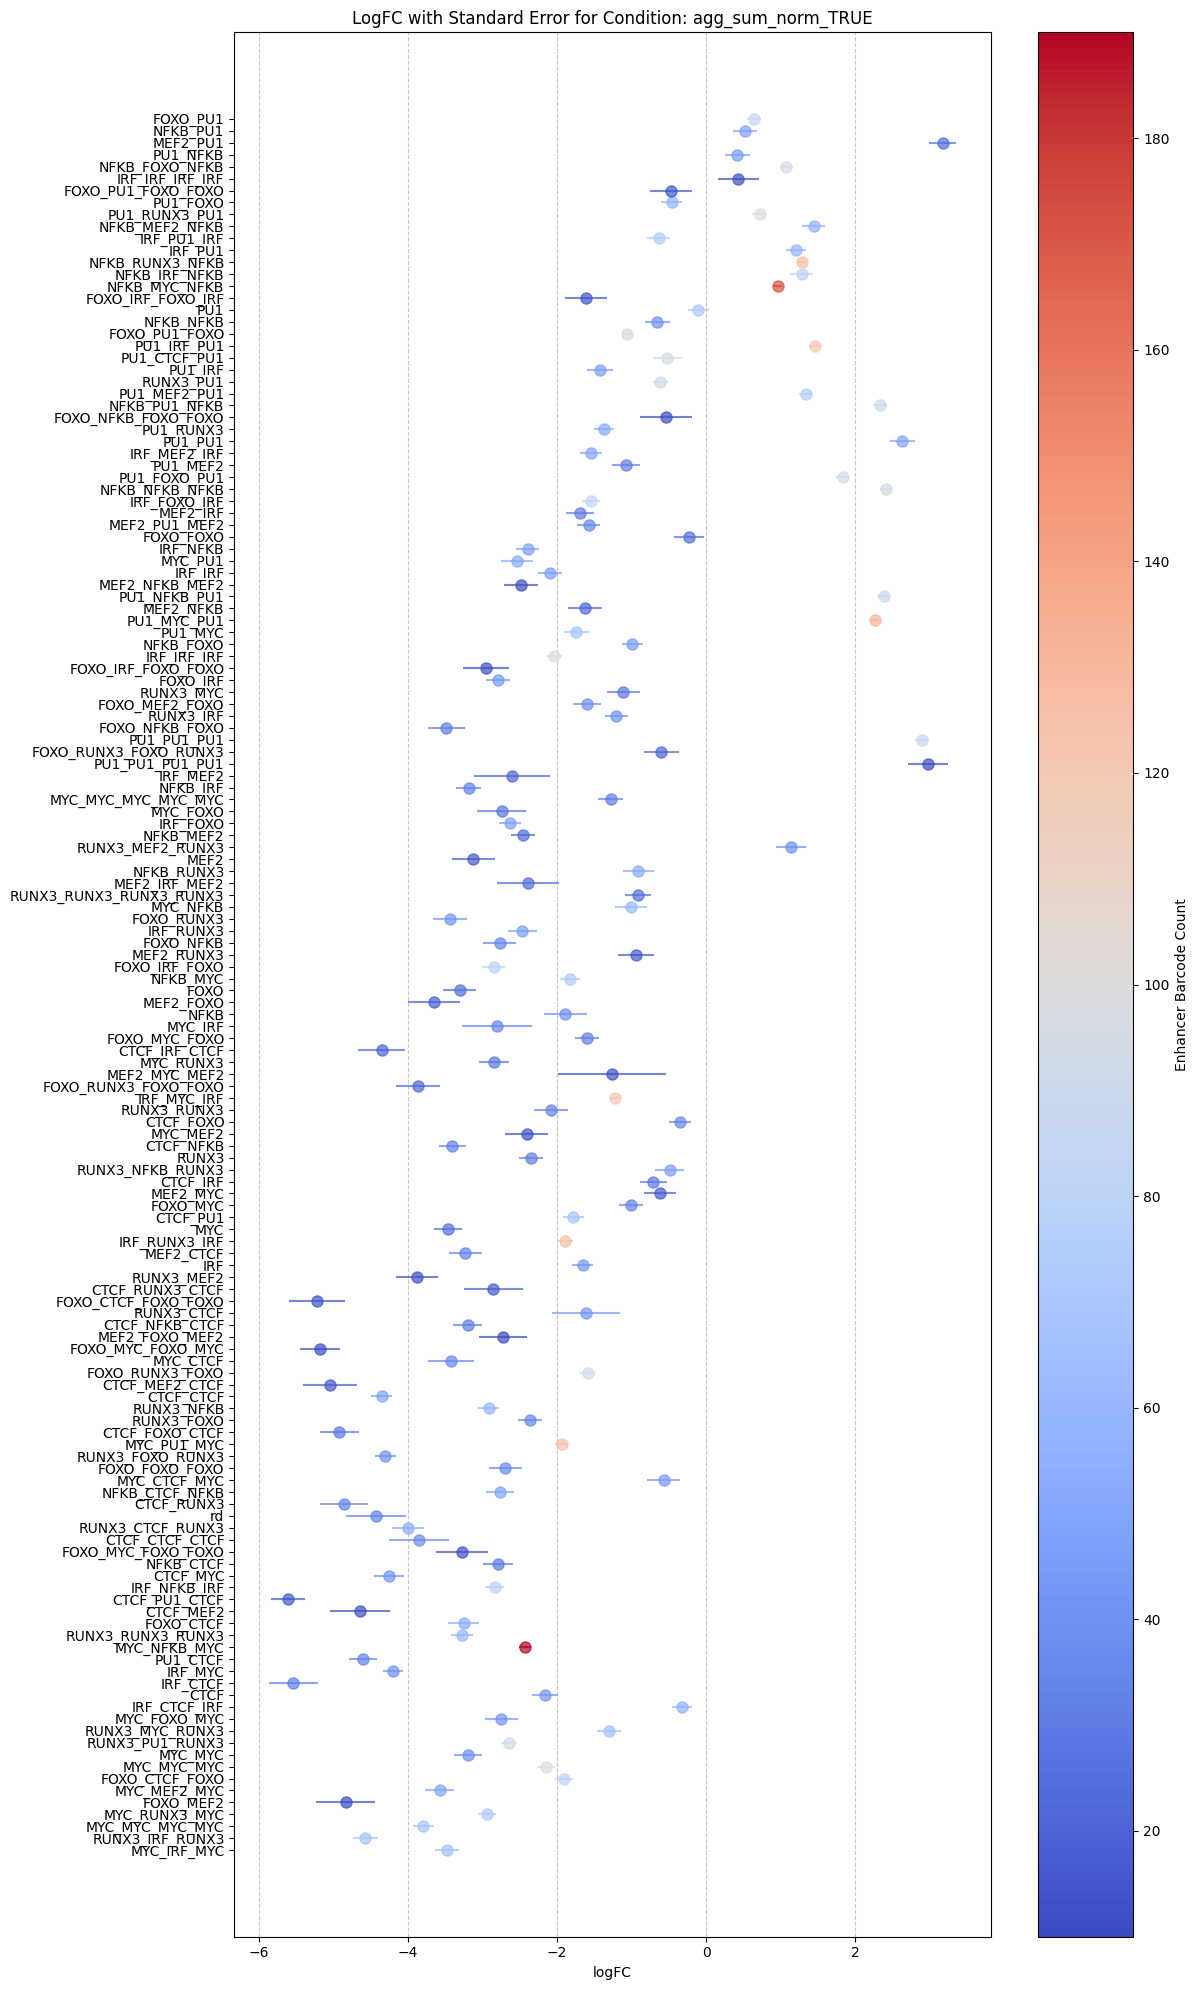

In [5]:
conditions = ['agg_mean_norm_FALSE', 'agg_mean_norm_TRUE', 
              'agg_sum_norm_FALSE', 'agg_sum_norm_TRUE']

for i, condition in enumerate(conditions):
    plt.figure(figsize=(12, 20))

    logFC_values = merged_df[f'logFC_{condition}']
    SE_values = merged_df[f'SE_{condition}']
    
    lower_bound = logFC_values - SE_values
    upper_bound = logFC_values + SE_values
    
    colors = cmap(norm(merged_df['Enhancer_barcode_count']))

    for idx in range(len(merged_df)):
        plt.errorbar(
            logFC_values.iloc[idx], idx,  # x-coordinate: logFC value, y-coordinate: index of enhancer
            xerr=[[logFC_values.iloc[idx] - lower_bound.iloc[idx]], [upper_bound.iloc[idx] - logFC_values.iloc[idx]]],  # Horizontal error bars
            fmt='o',  # Marker type: dot
            color=colors[idx],  # Color by barcode count
            markersize=8,  # Size of the dots
            alpha=0.7  # Transparency of dots
        )
    
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=plt.gca())
    cbar.set_label('Enhancer Barcode Count')

    plt.xlabel('logFC')
    plt.title(f'LogFC with Standard Error for Condition: {condition}')
    
    plt.yticks(np.arange(len(merged_df)), merged_df['Enhancer'])
    
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    plot_filename = f"{condition}_logFC_with_SE_horizontal.png"
    plt.tight_layout()
    # plt.save_fig(plot_filename)
    plt.show()
    plt.close()

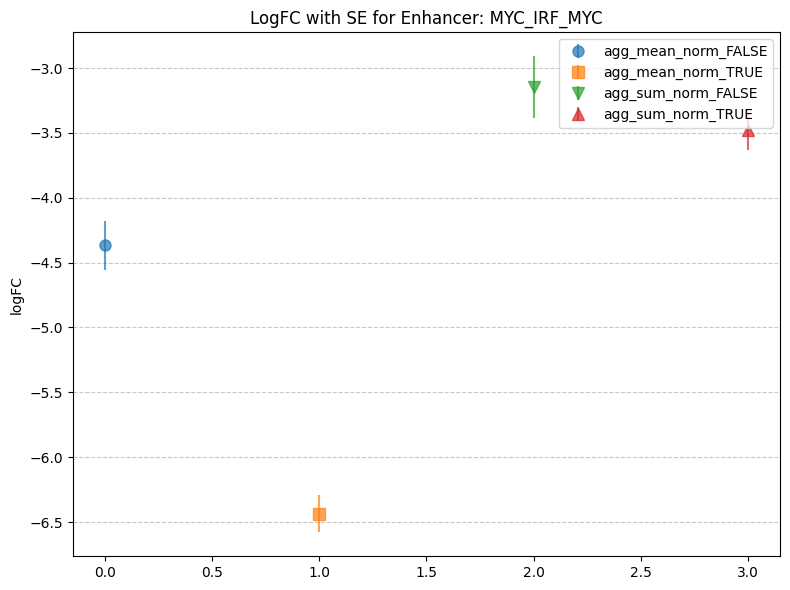

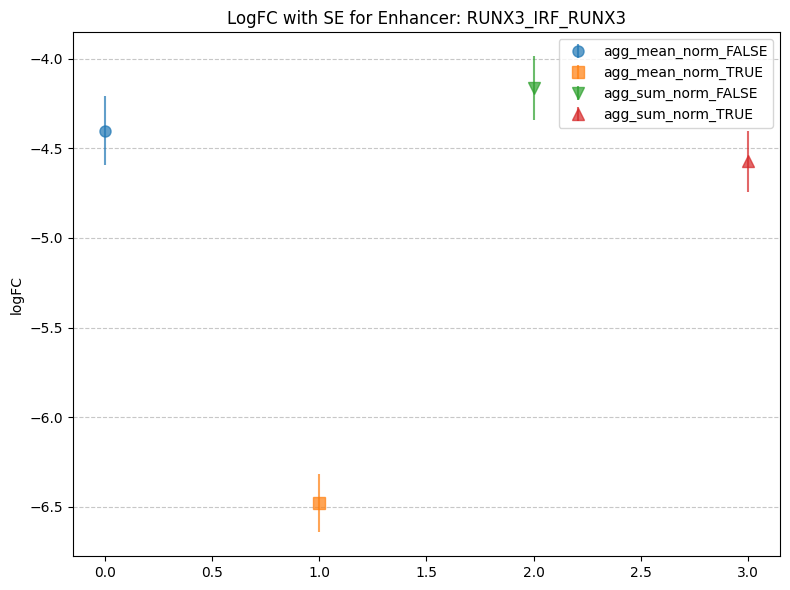

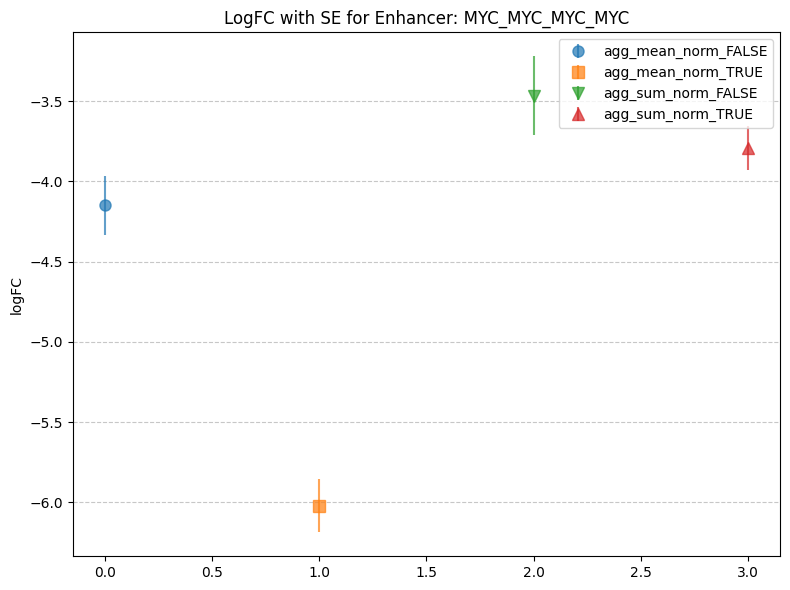

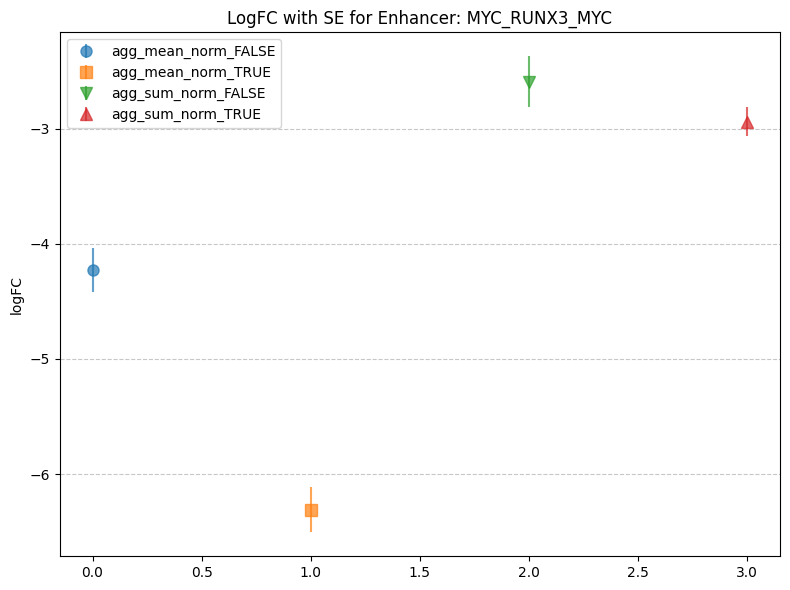

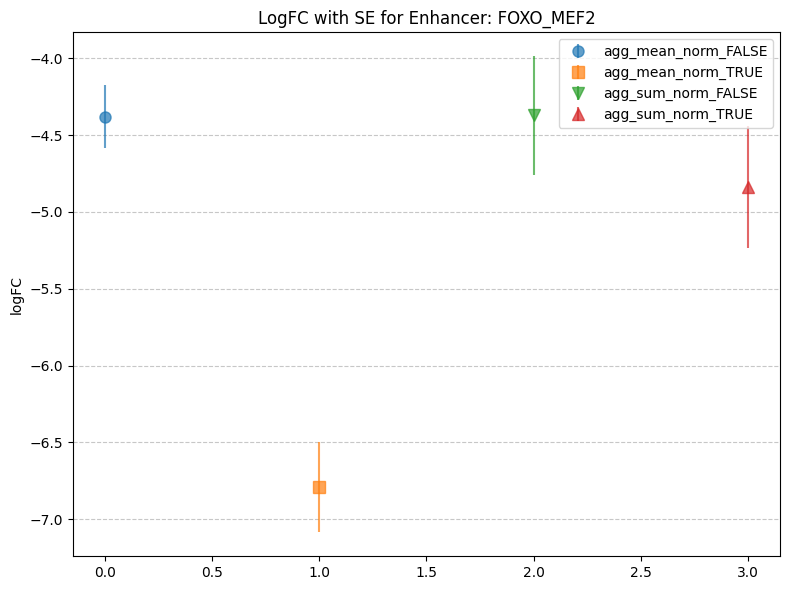

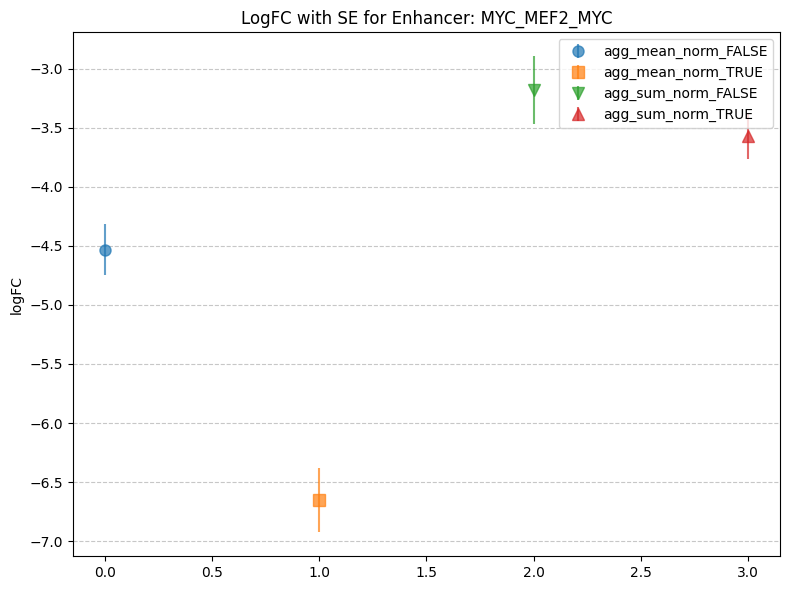

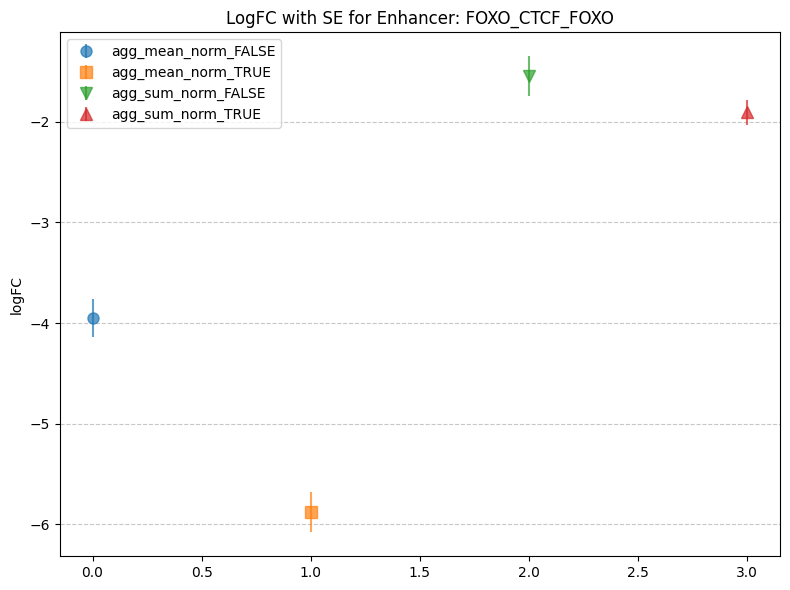

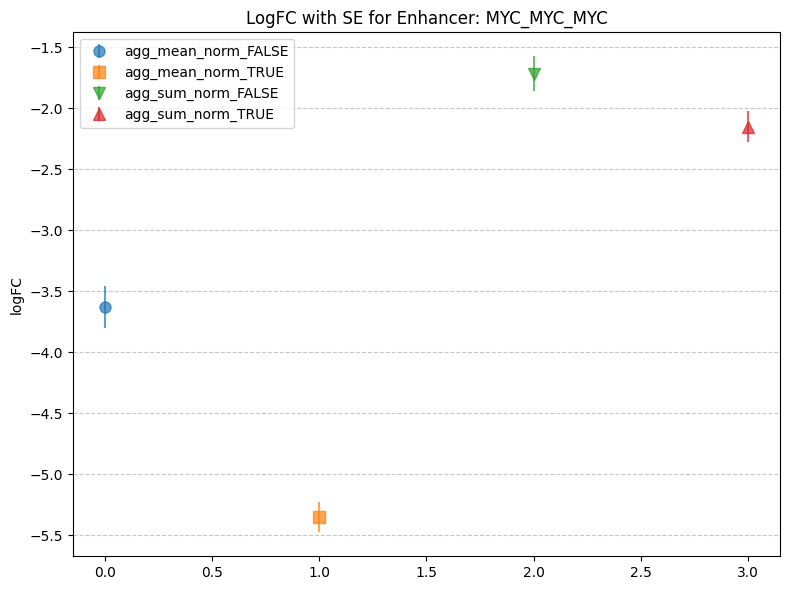

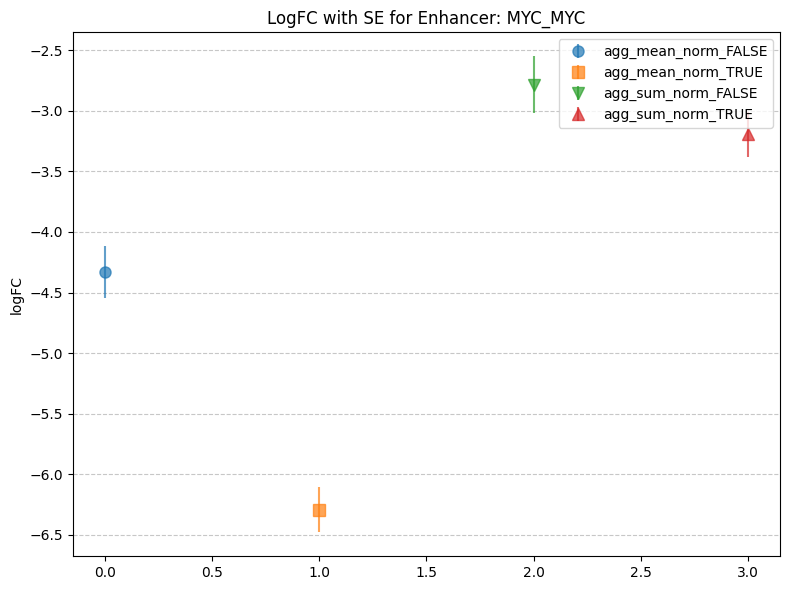

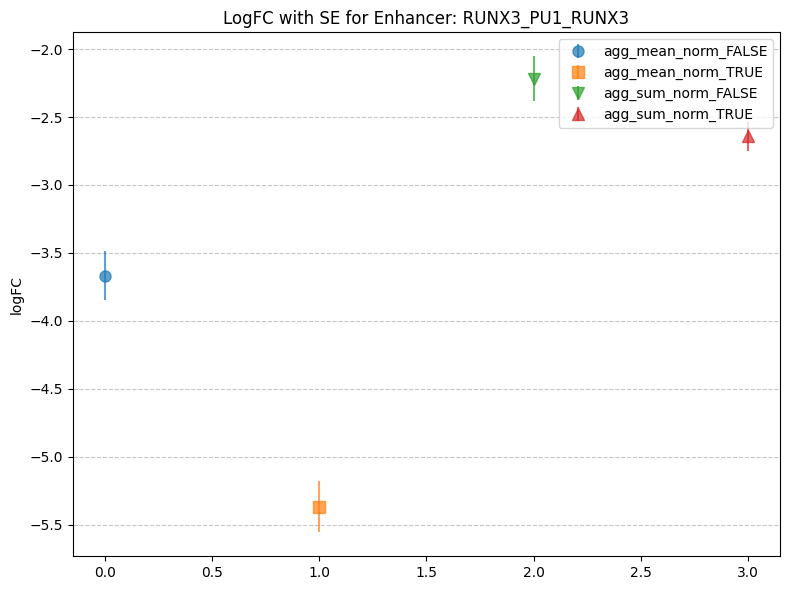

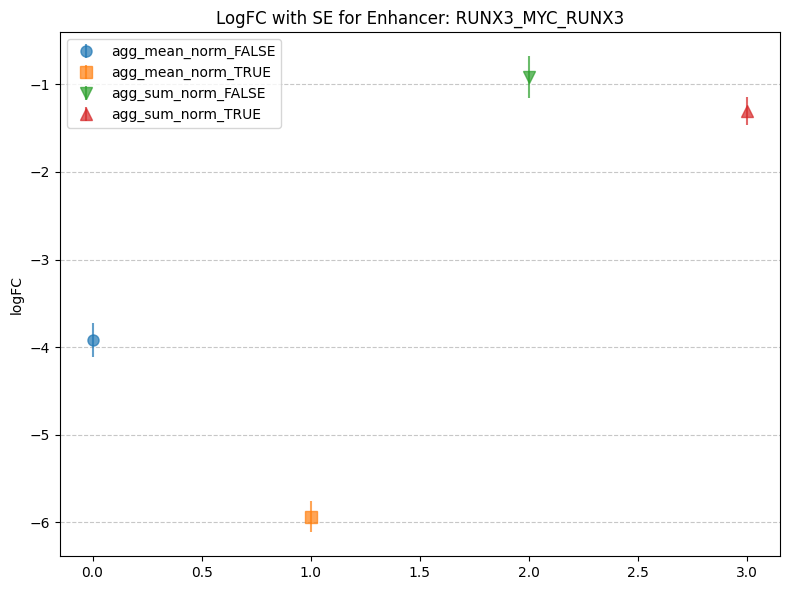

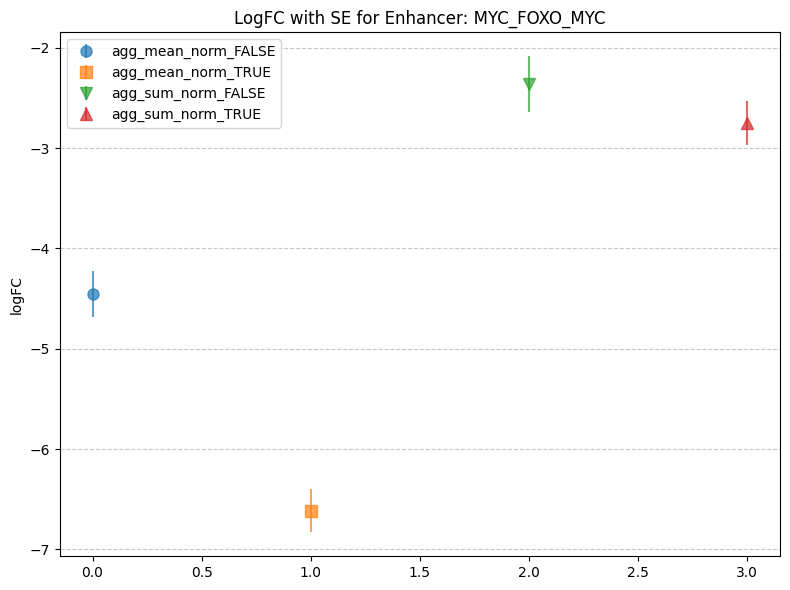

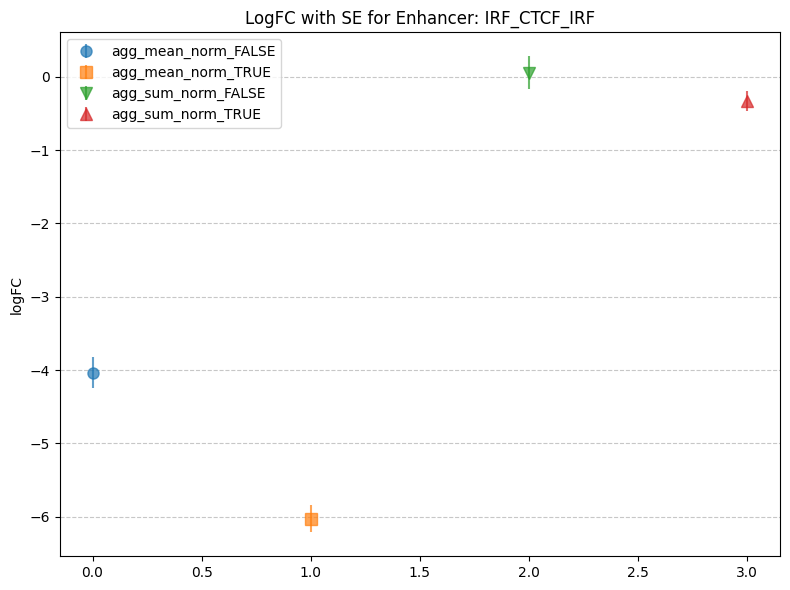

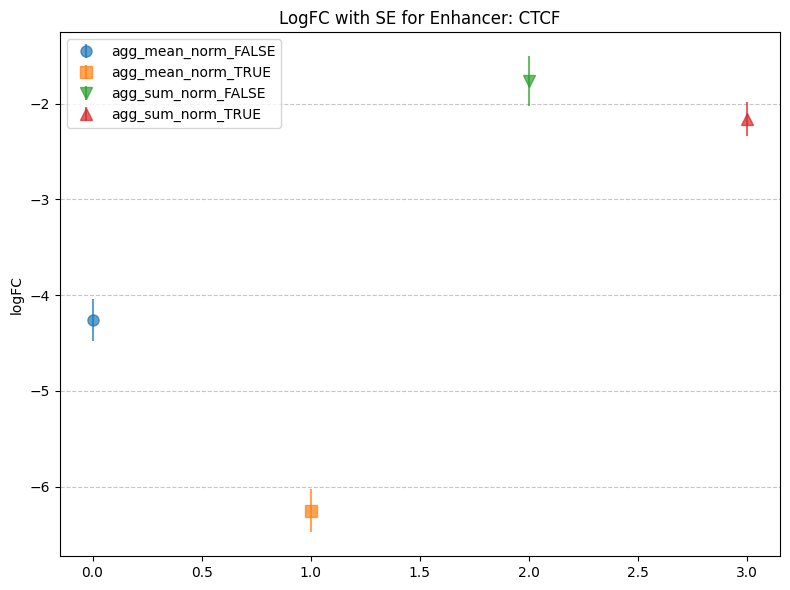

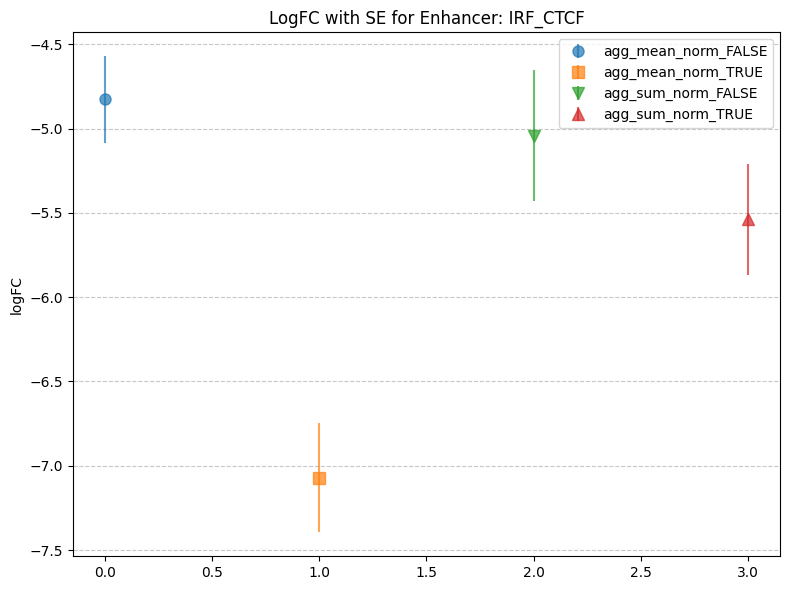

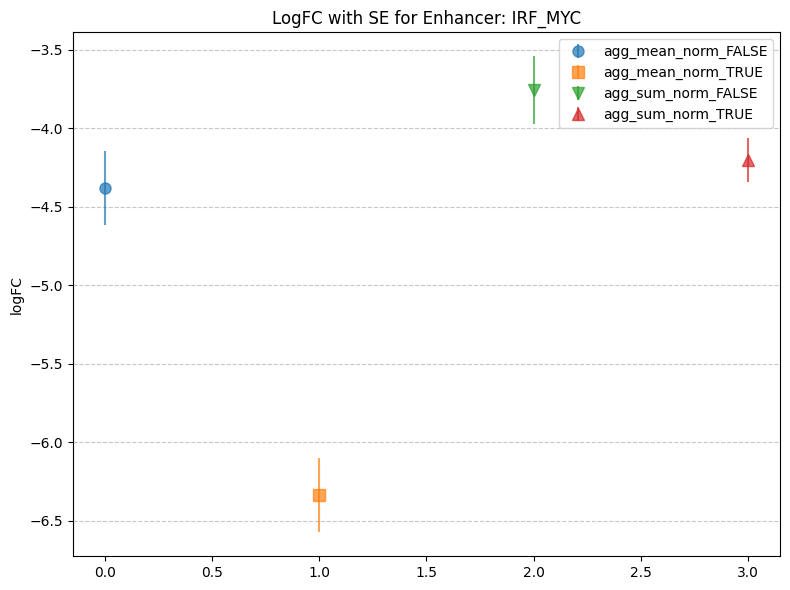

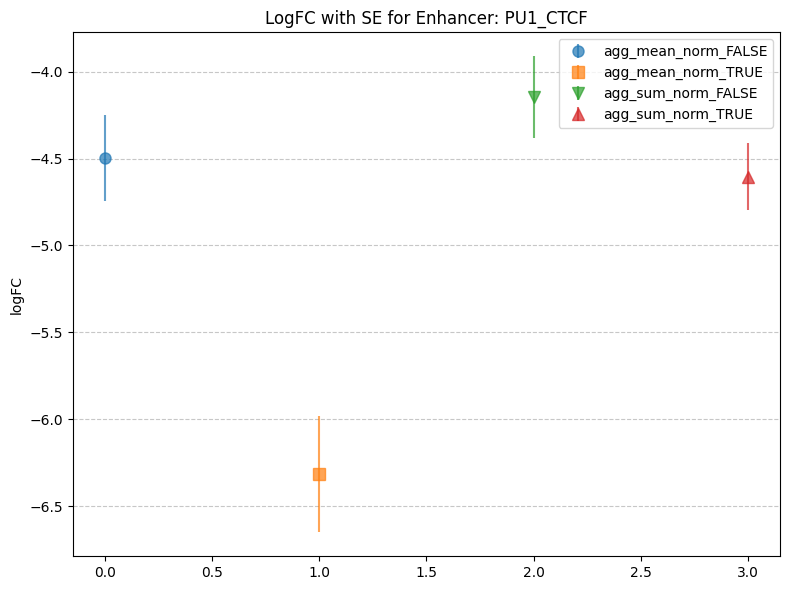

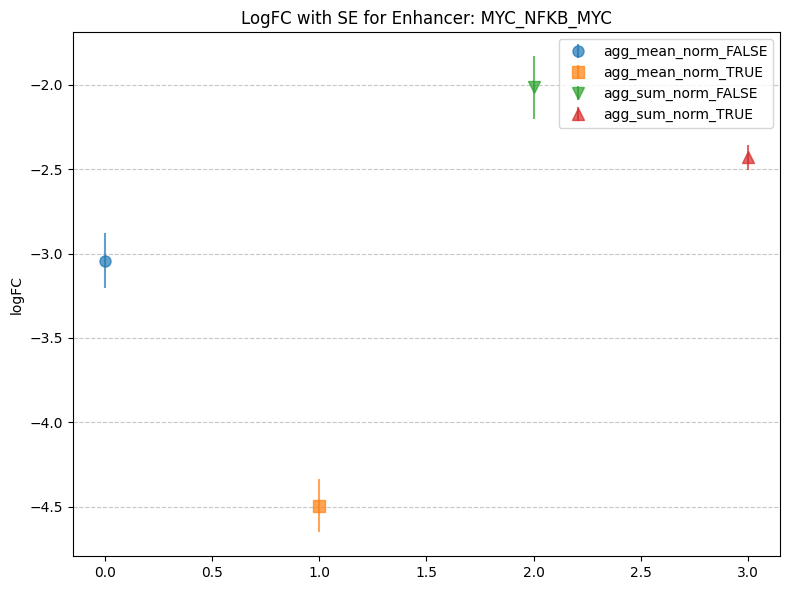

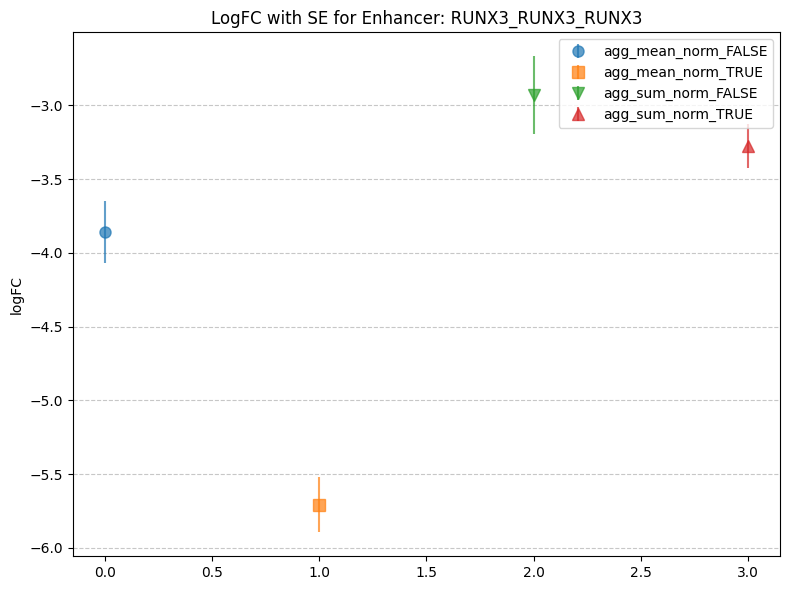

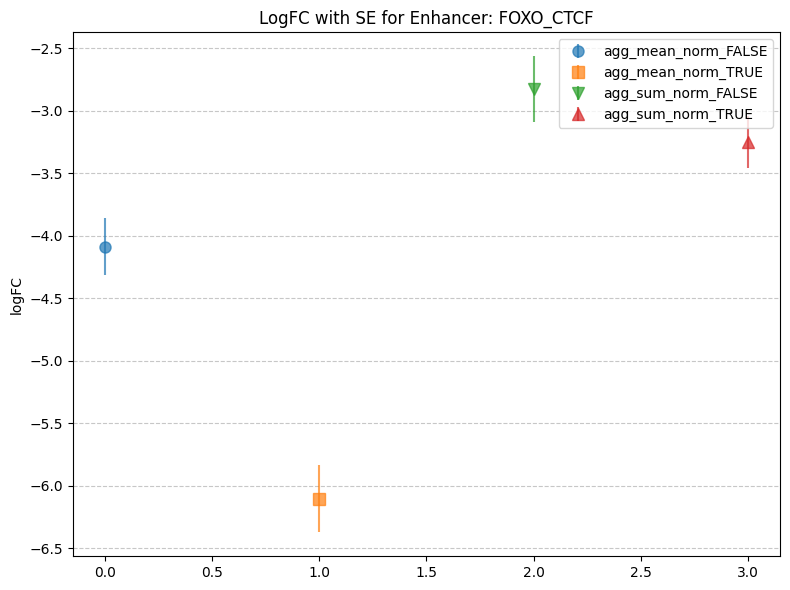

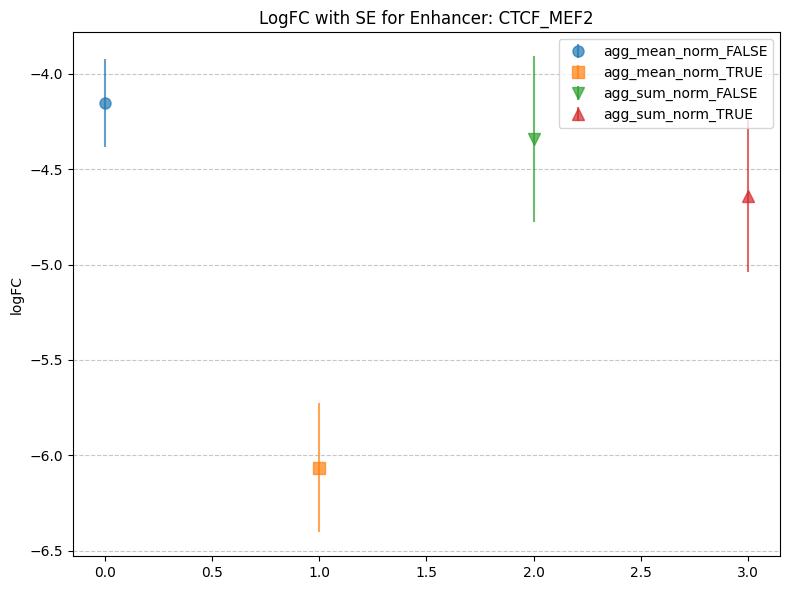

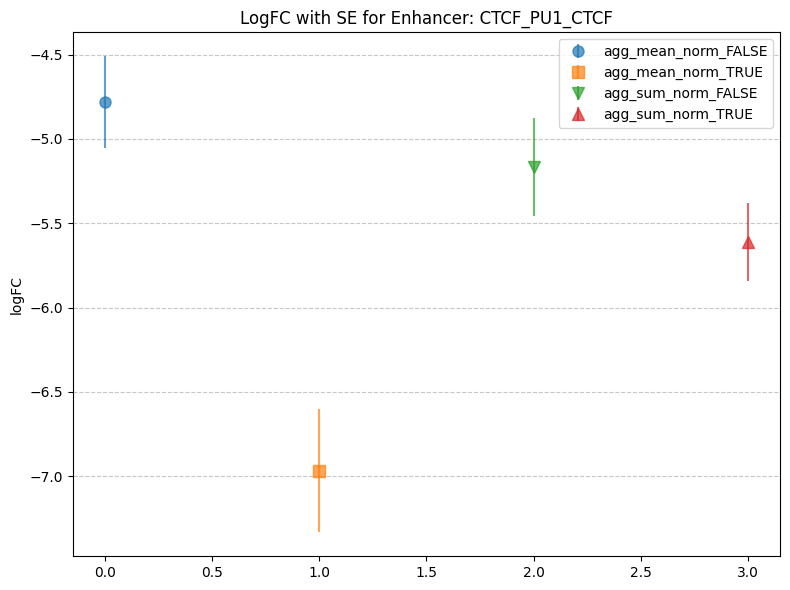

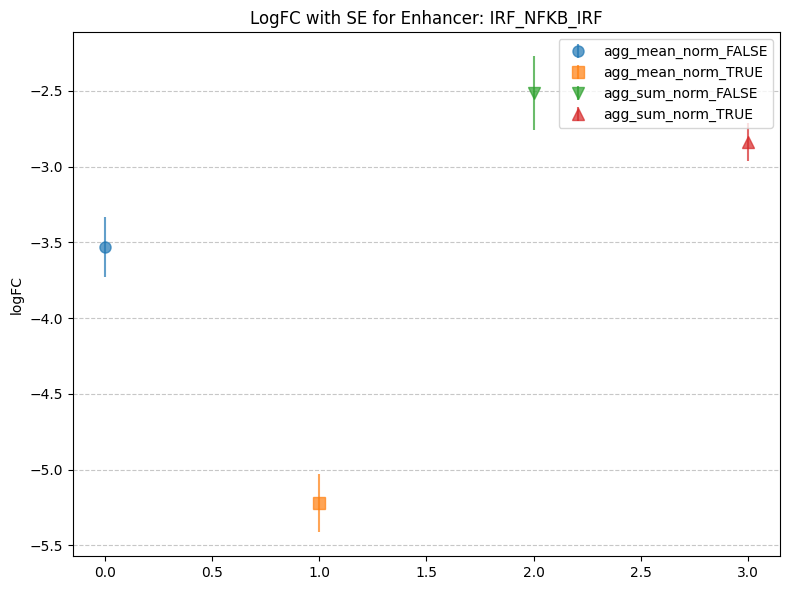

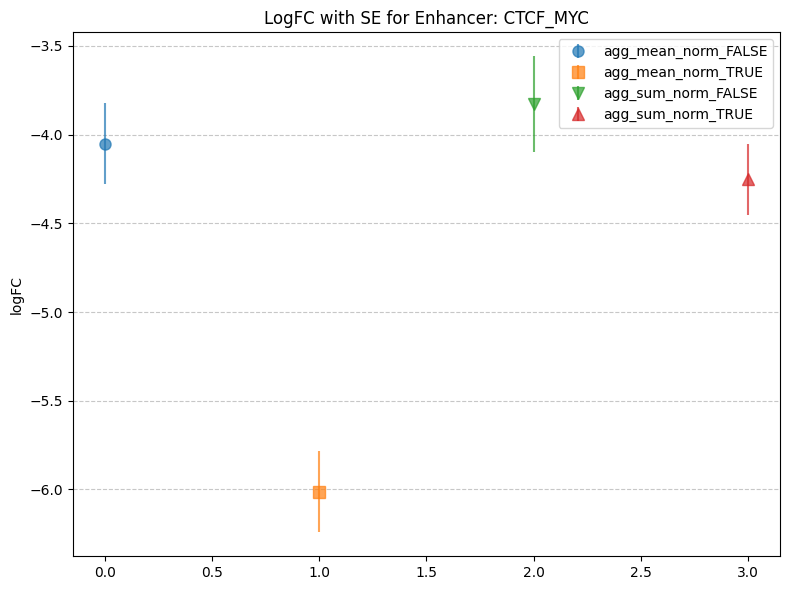

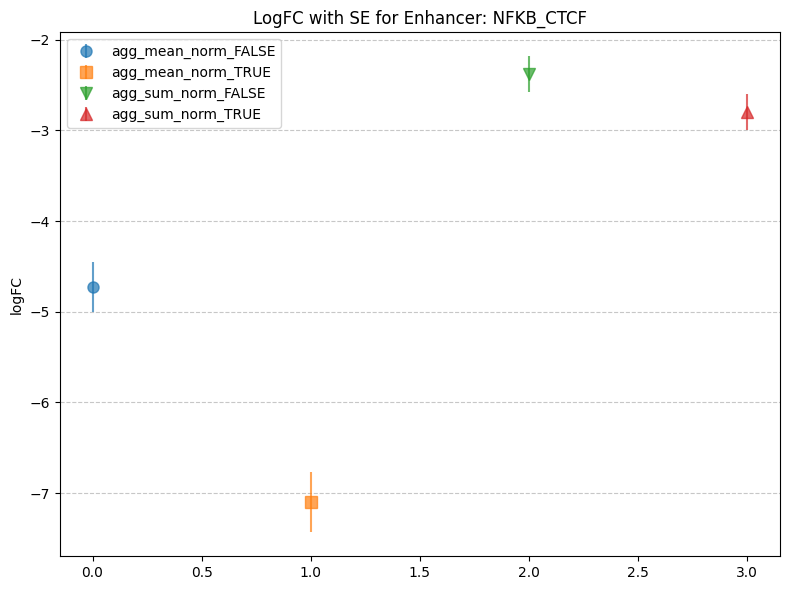

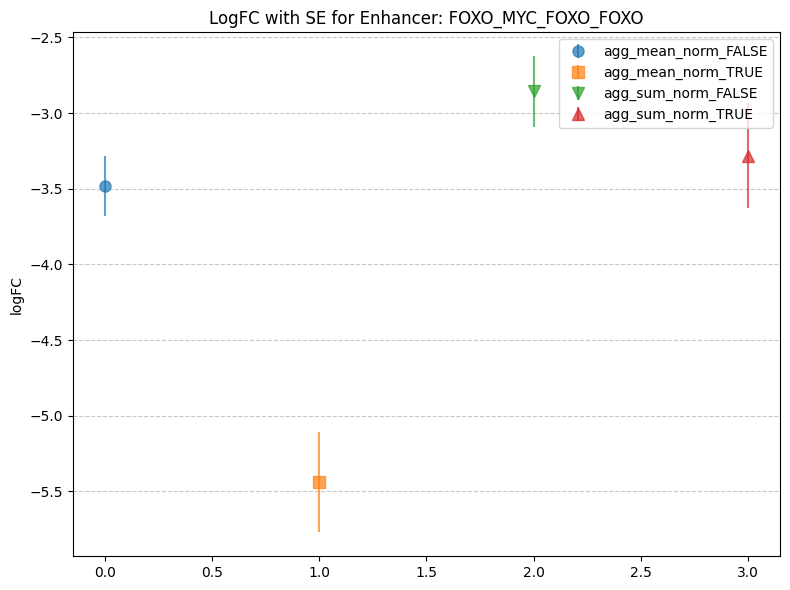

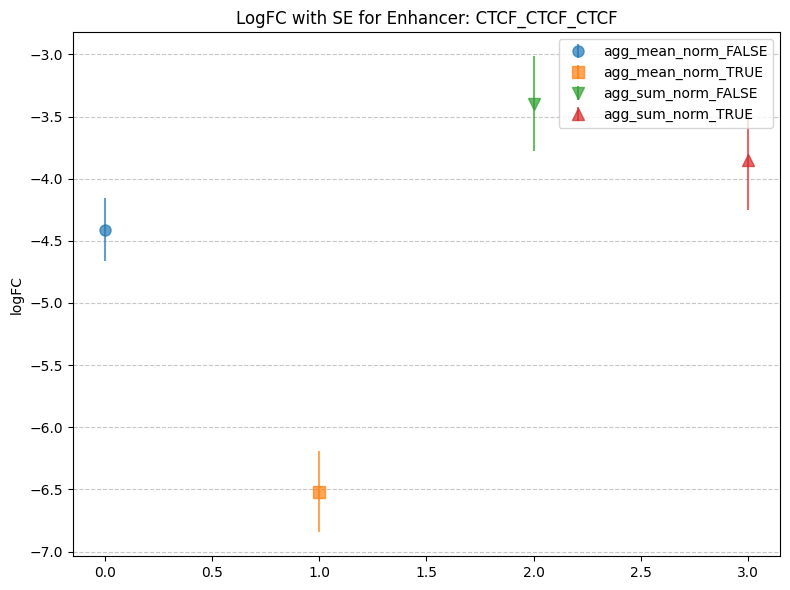

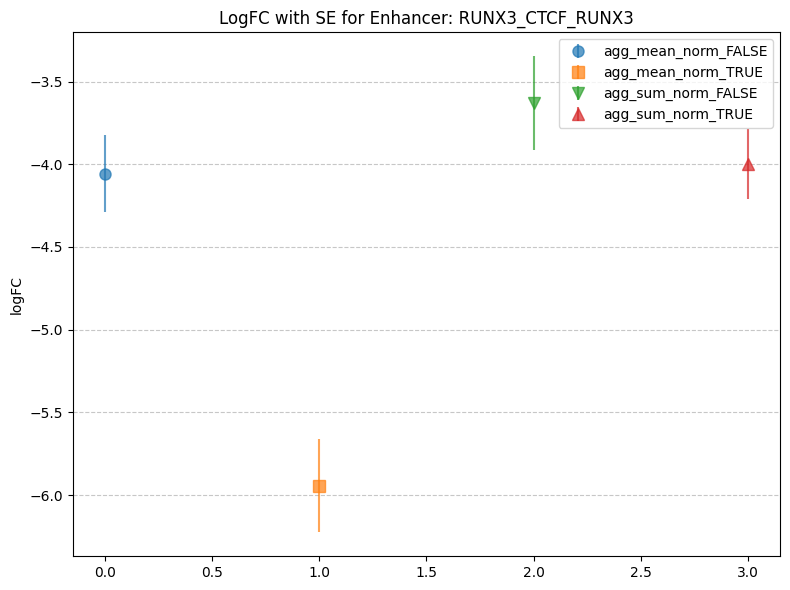

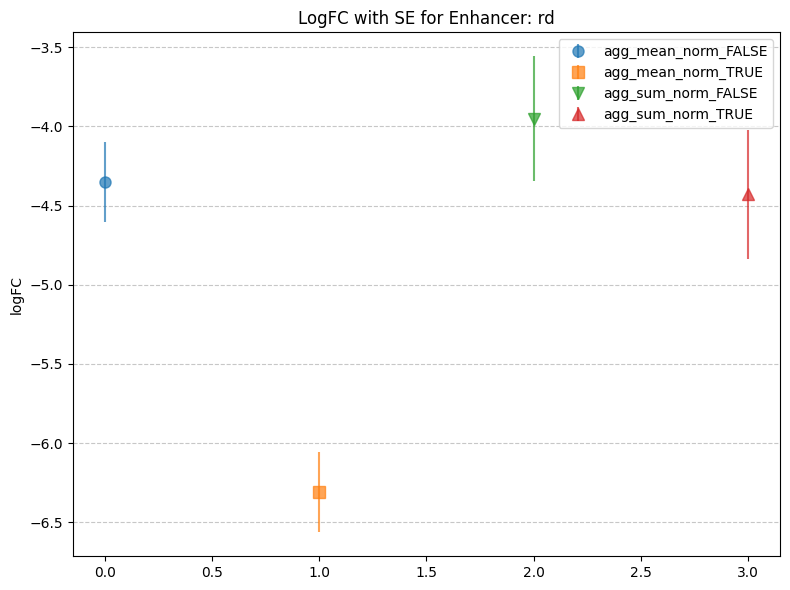

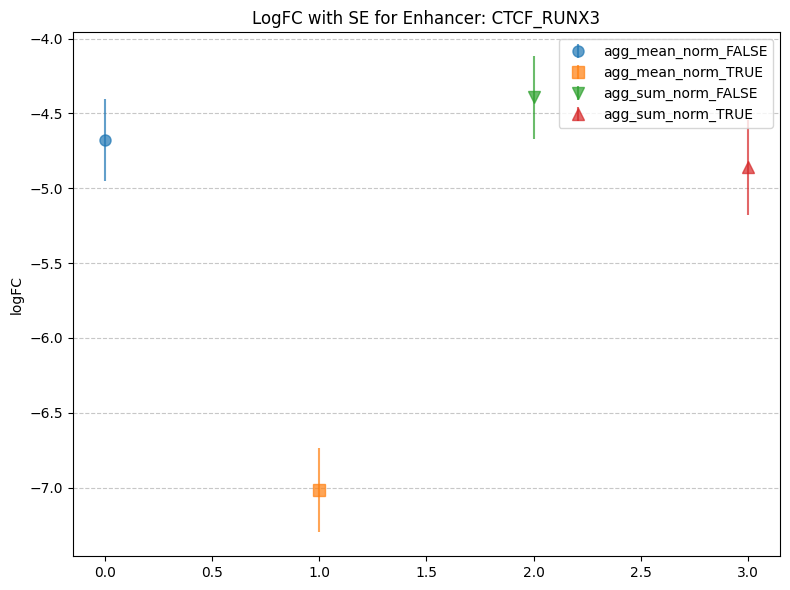

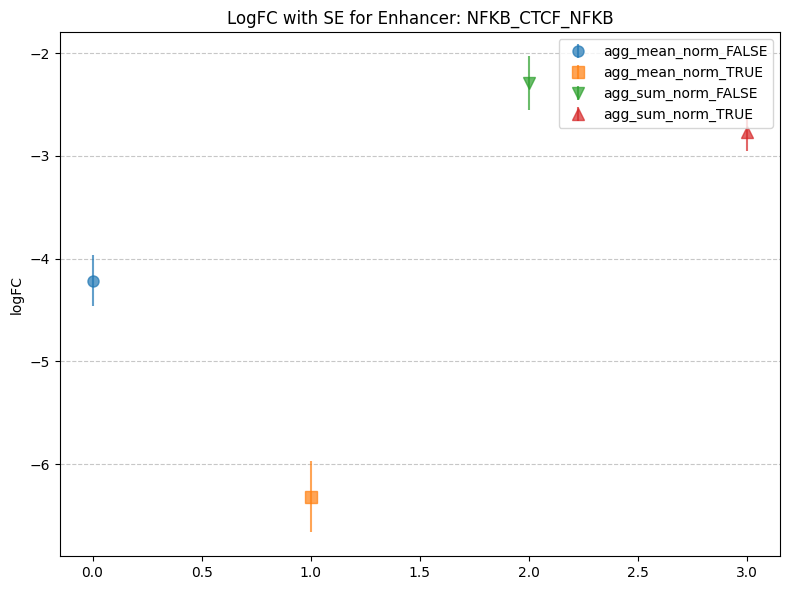

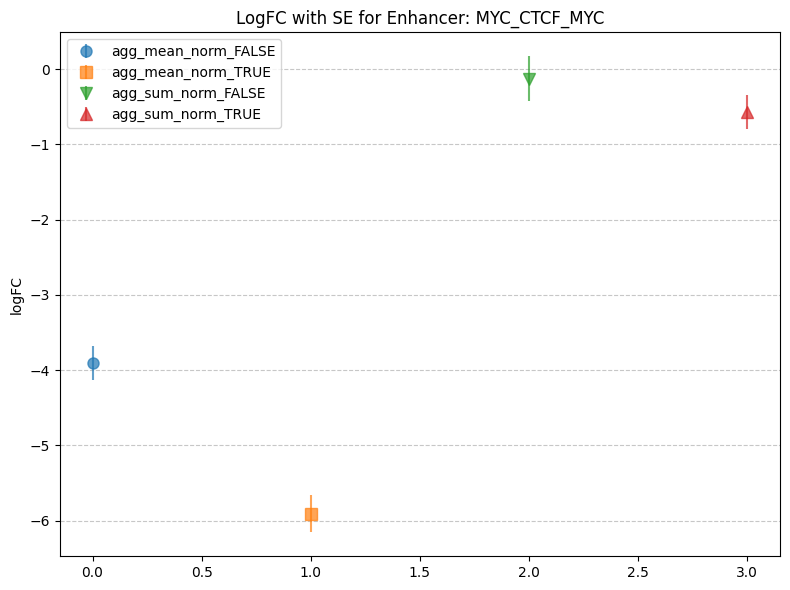

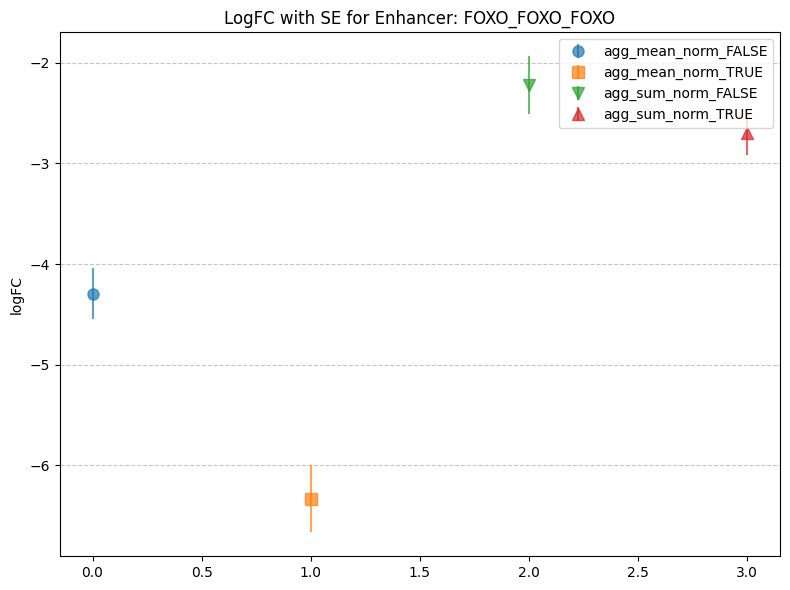

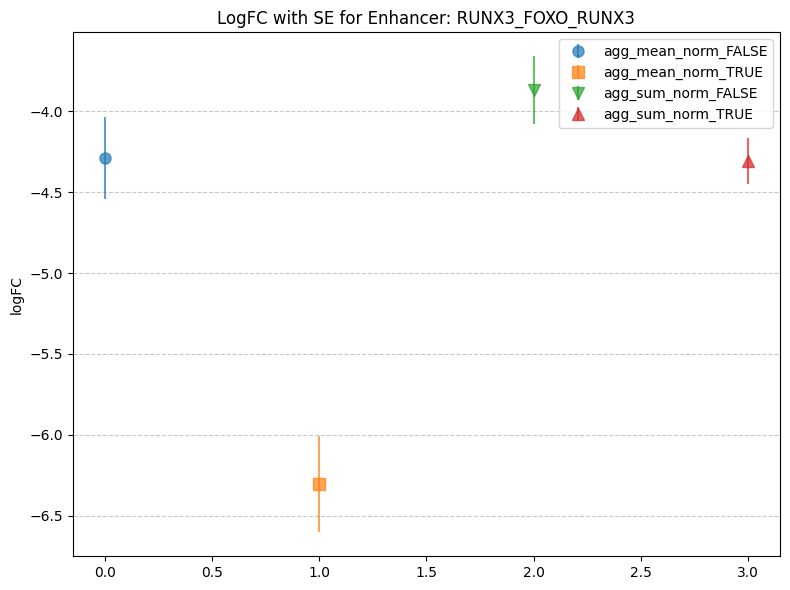

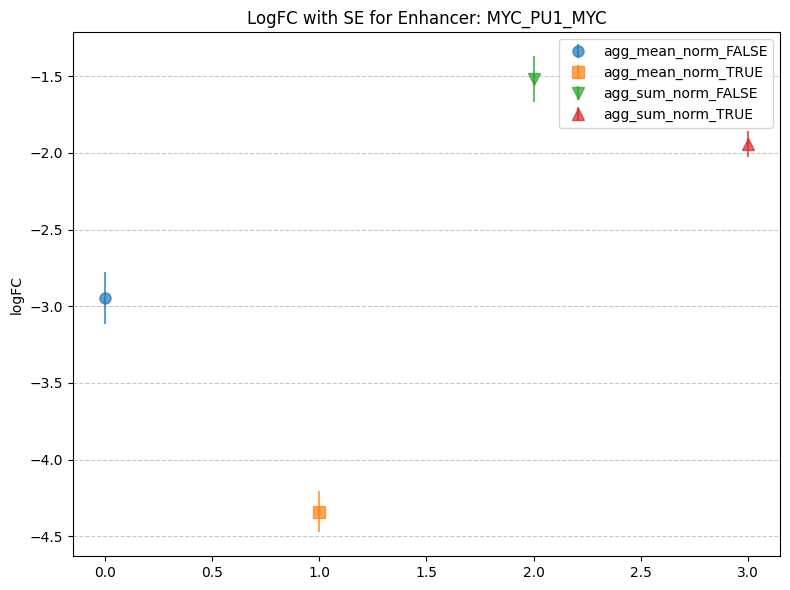

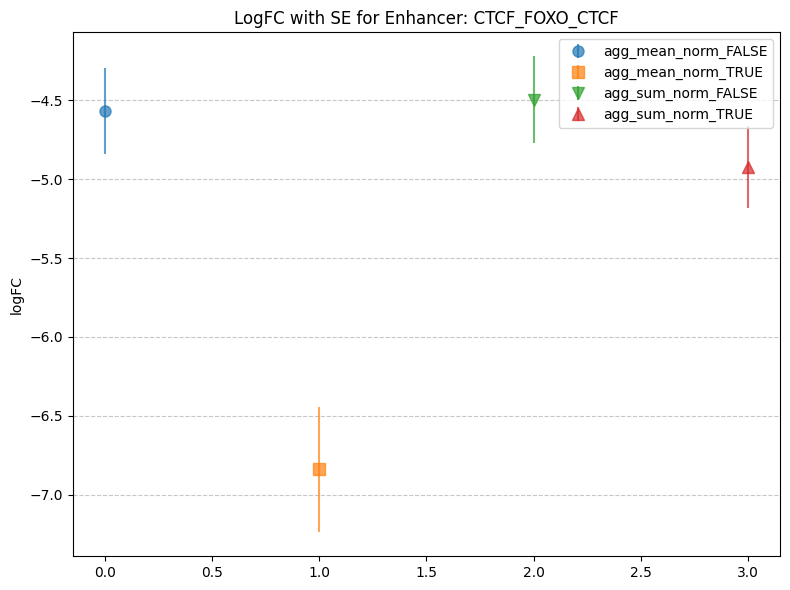

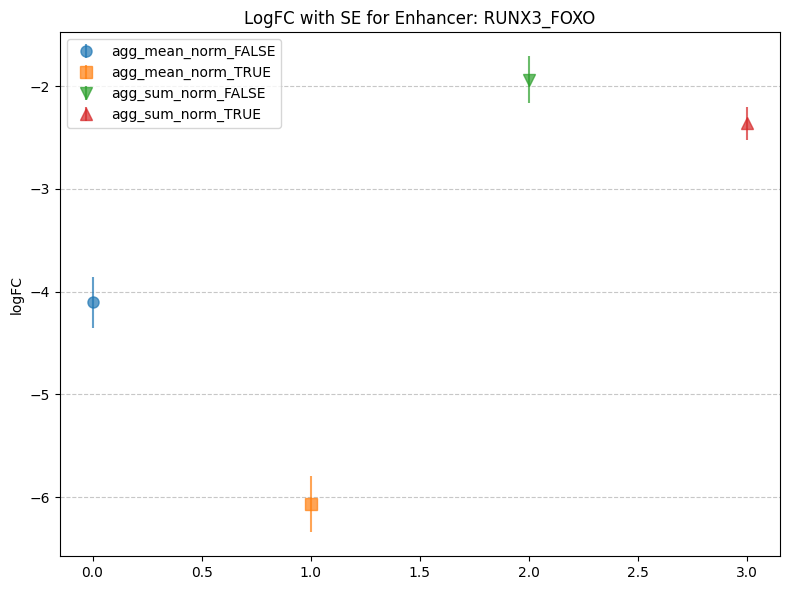

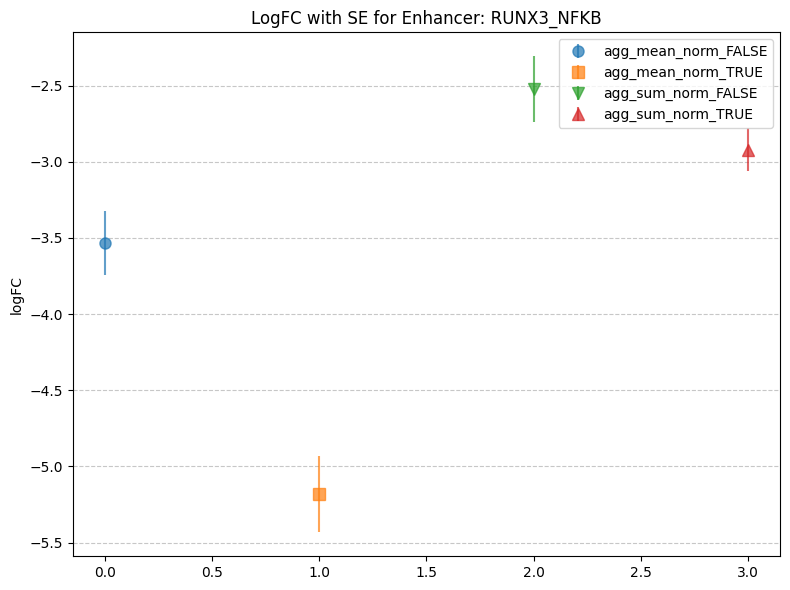

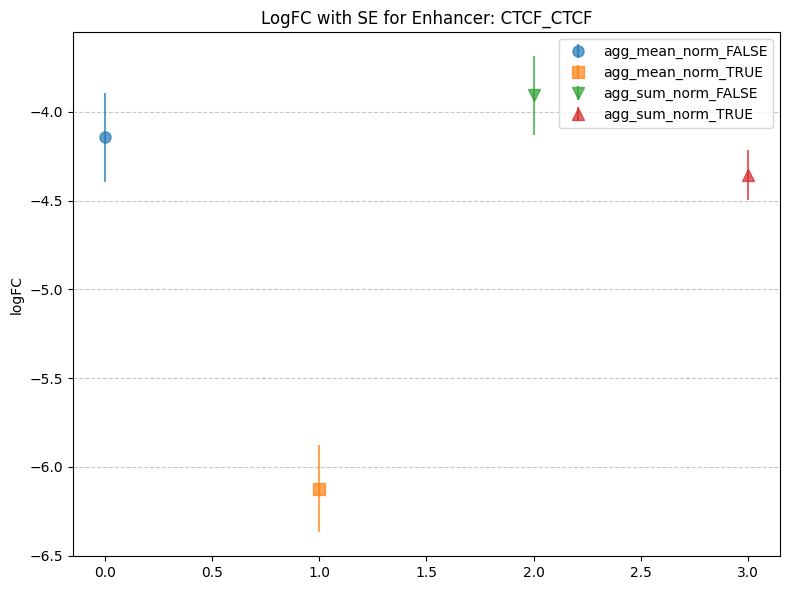

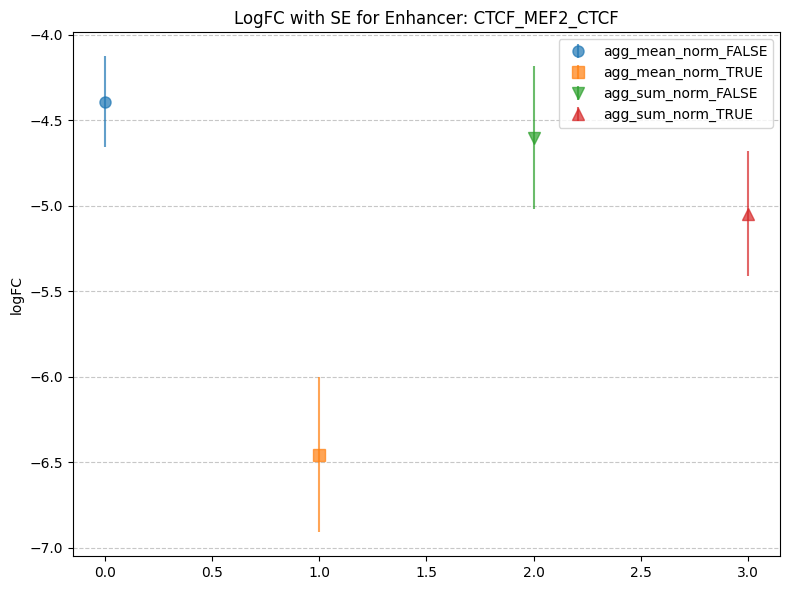

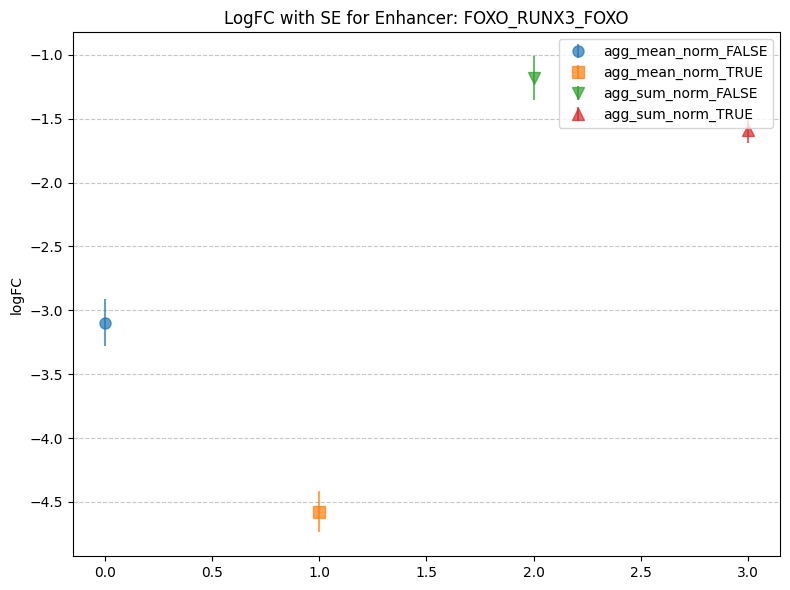

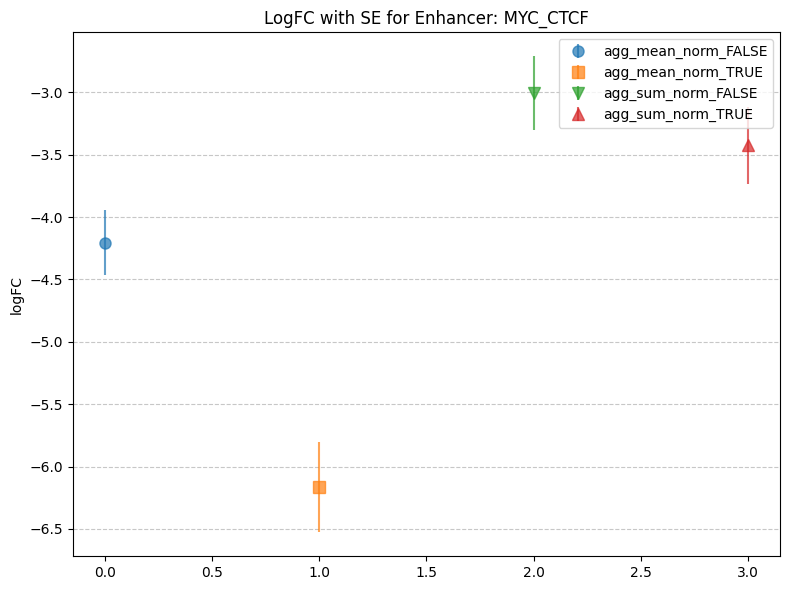

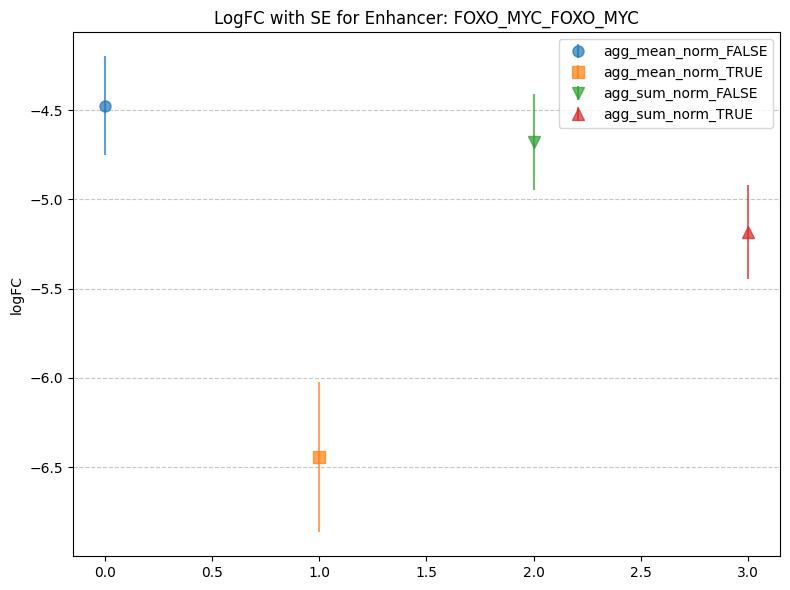

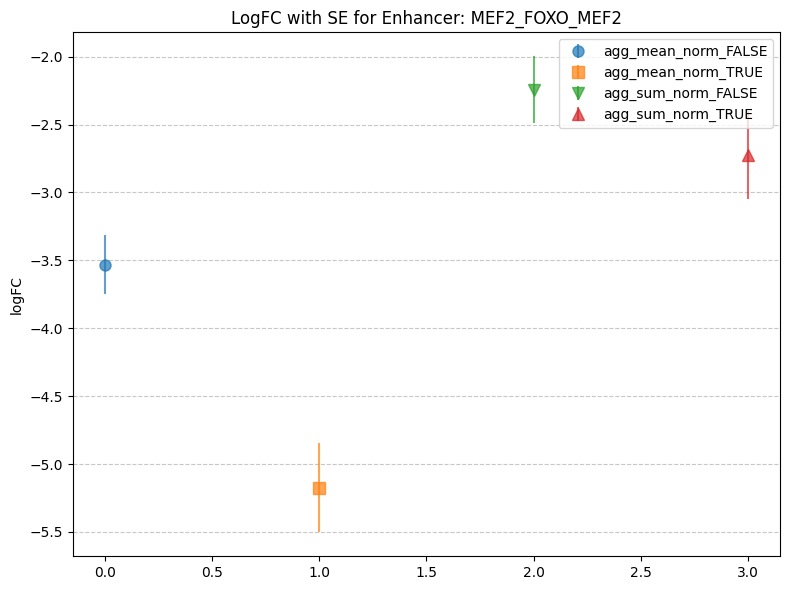

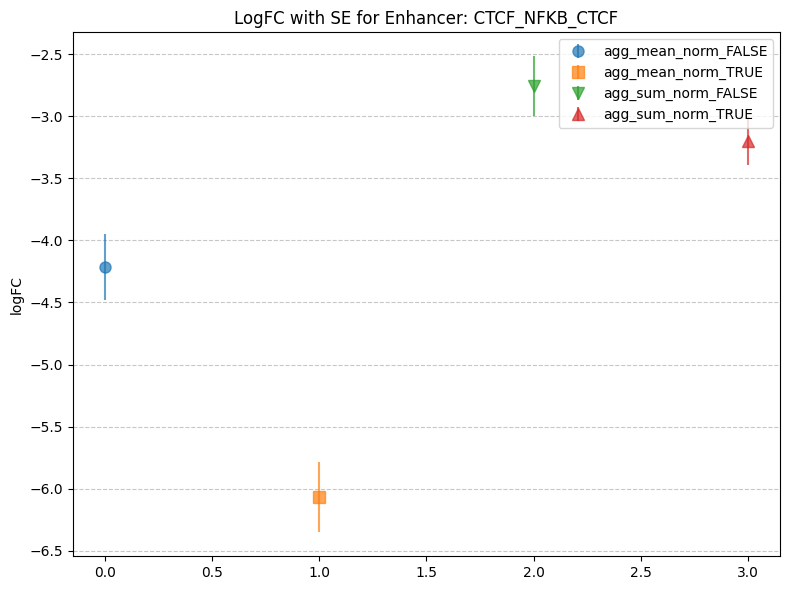

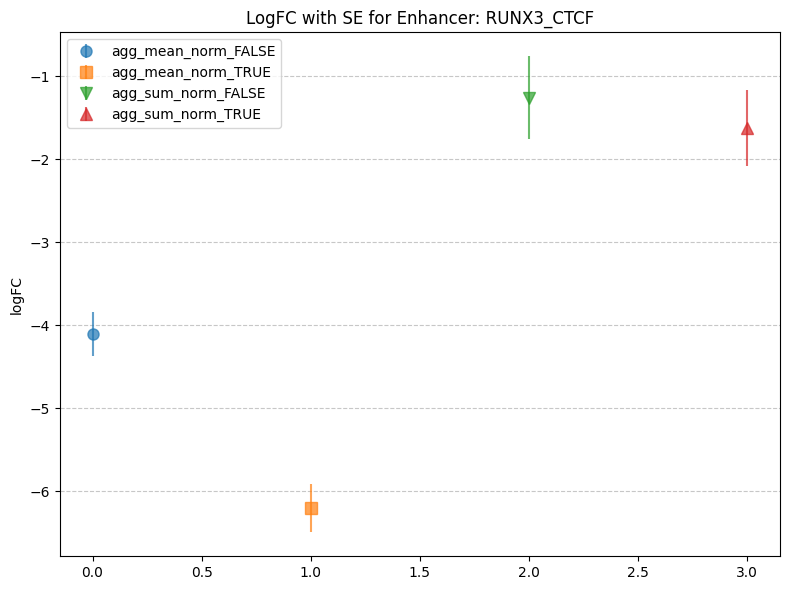

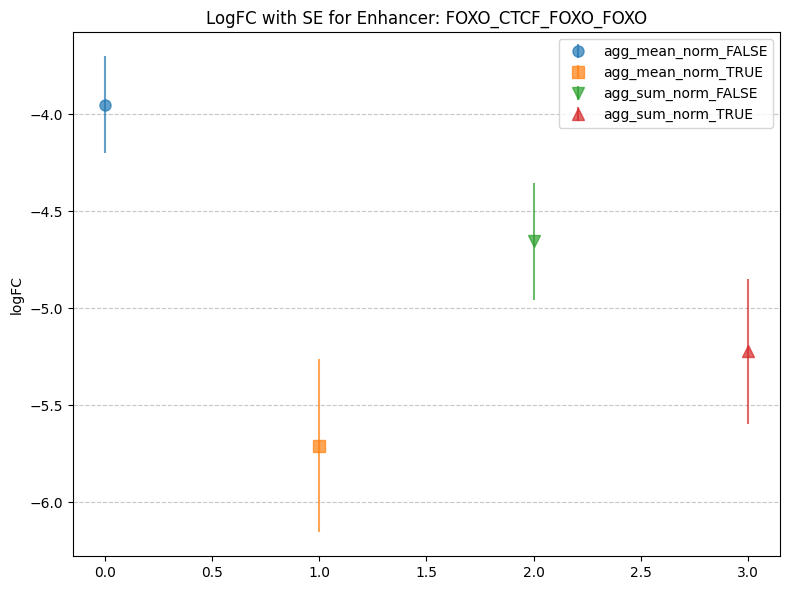

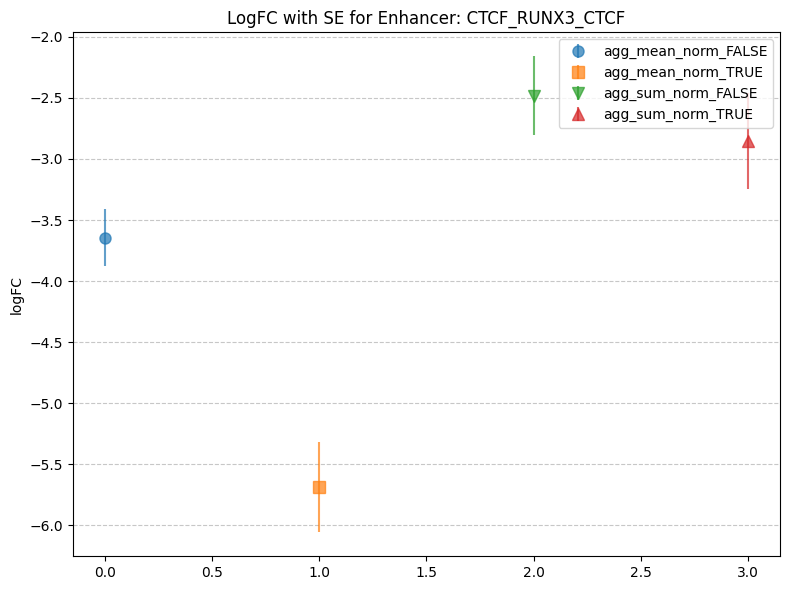

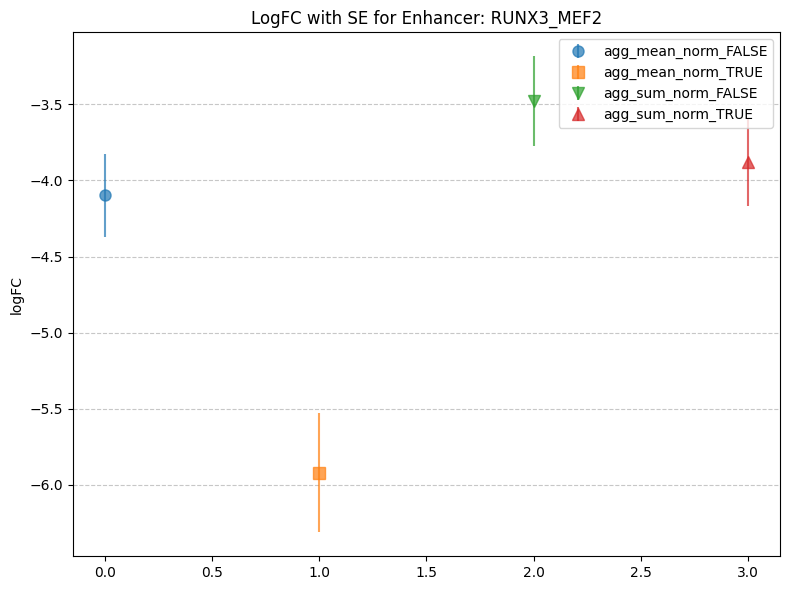

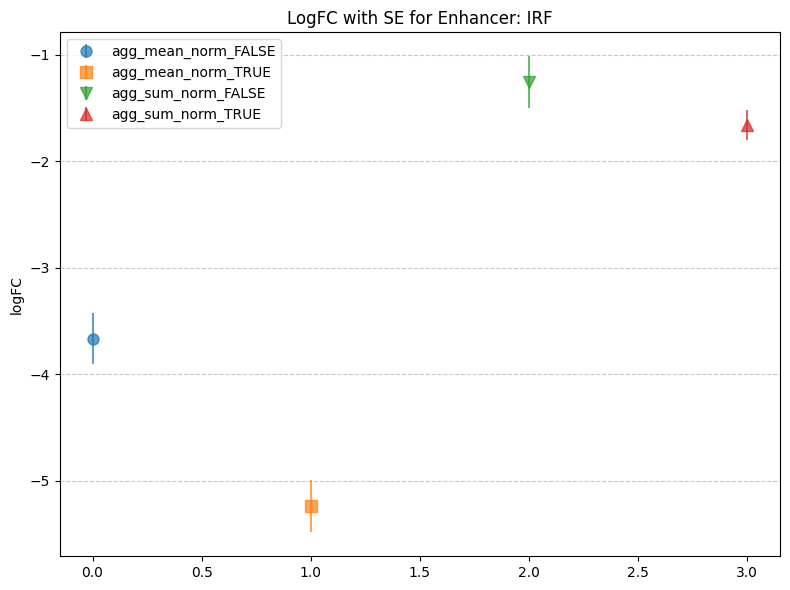

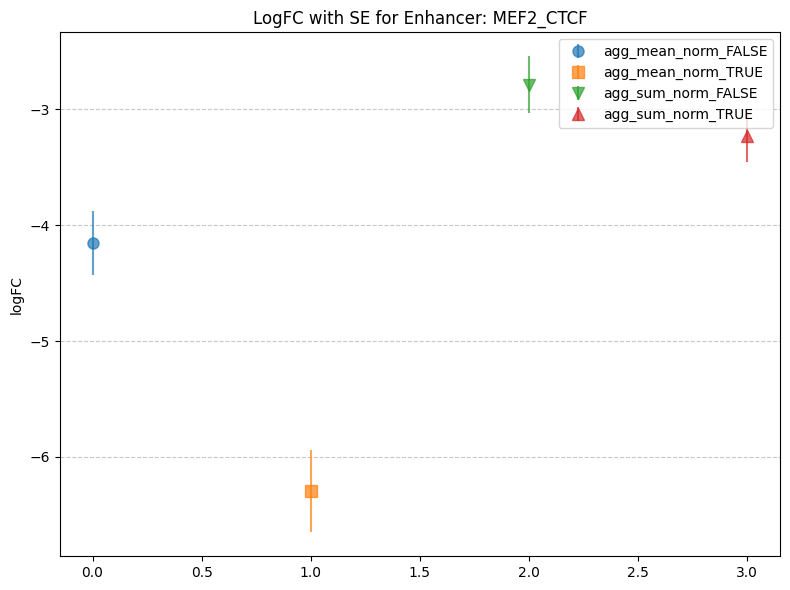

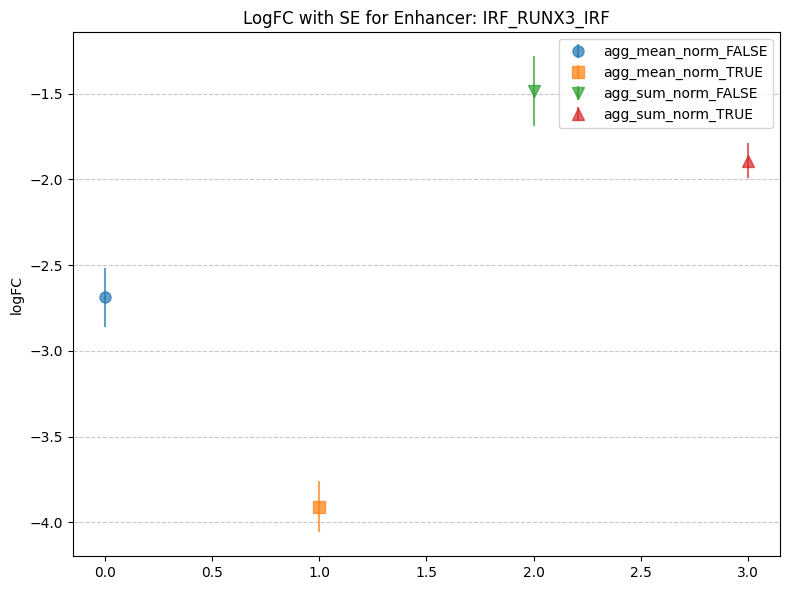

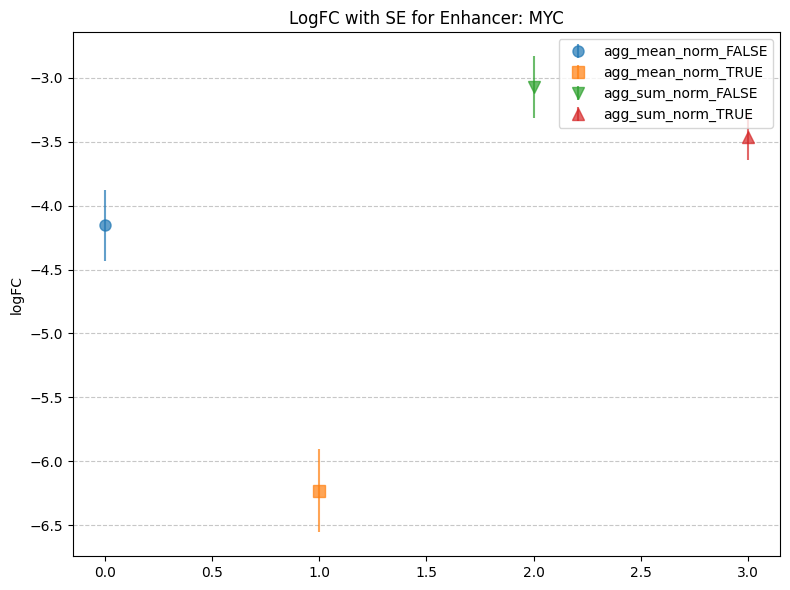

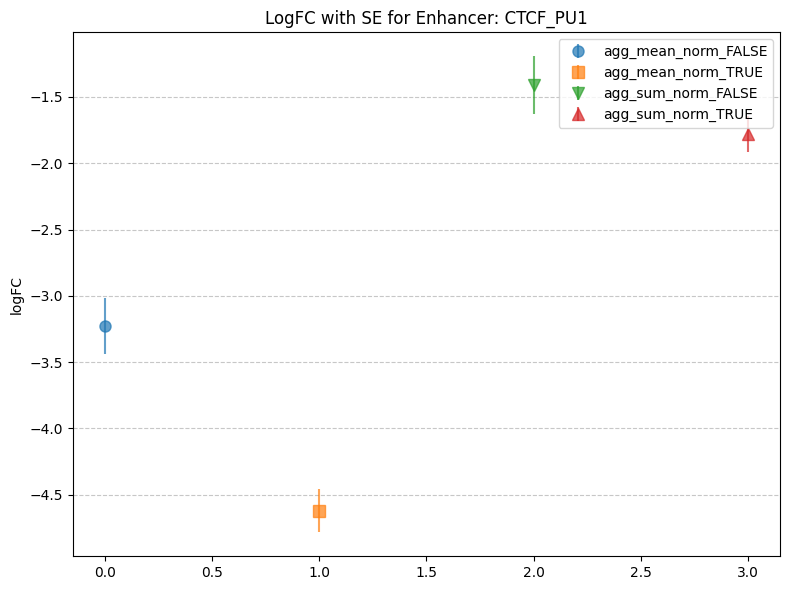

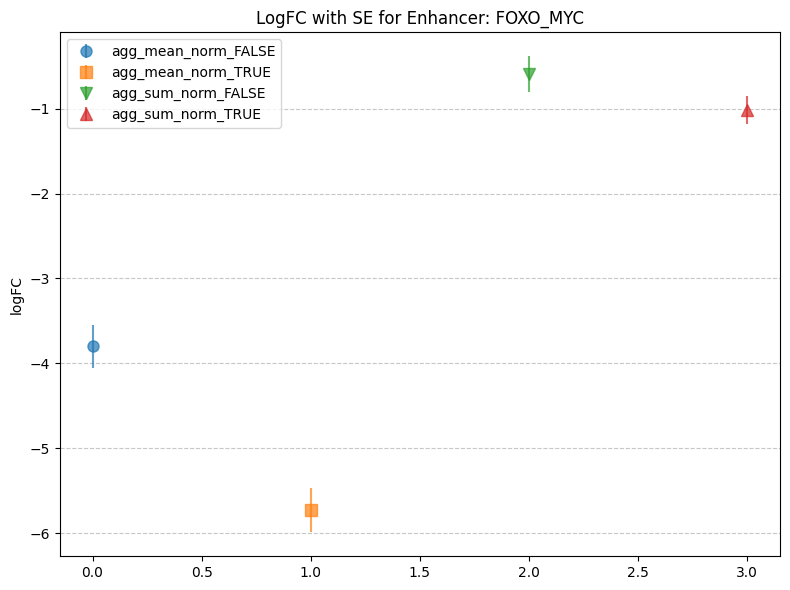

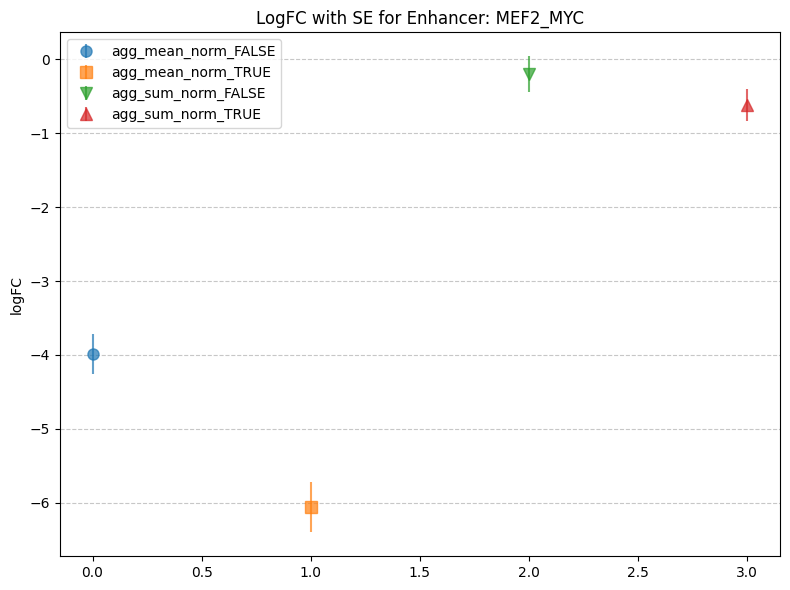

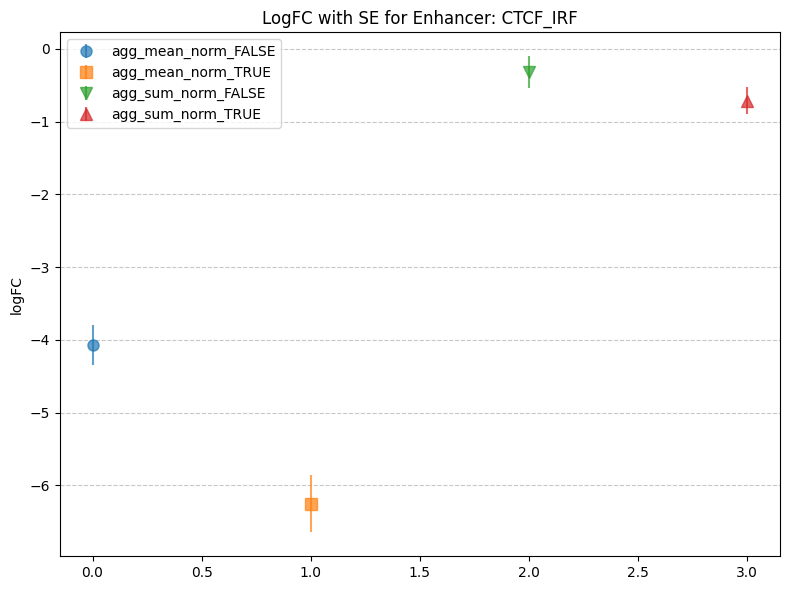

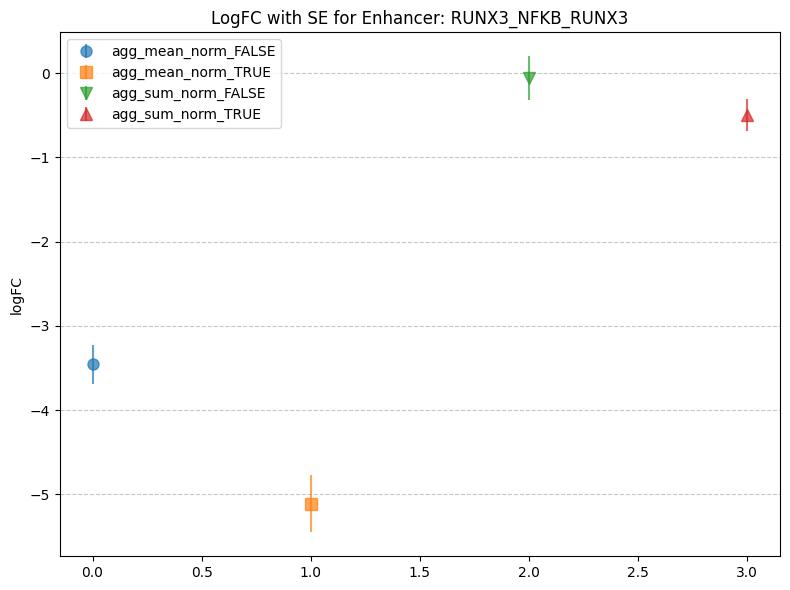

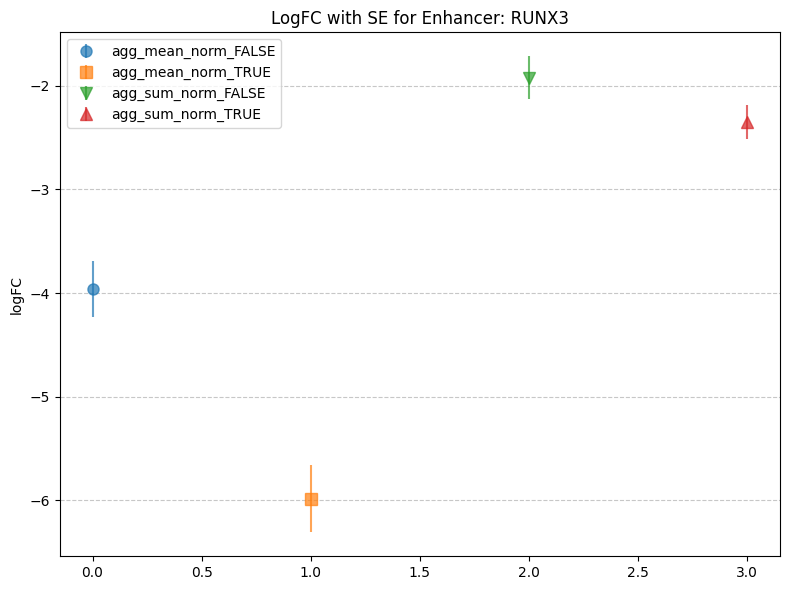

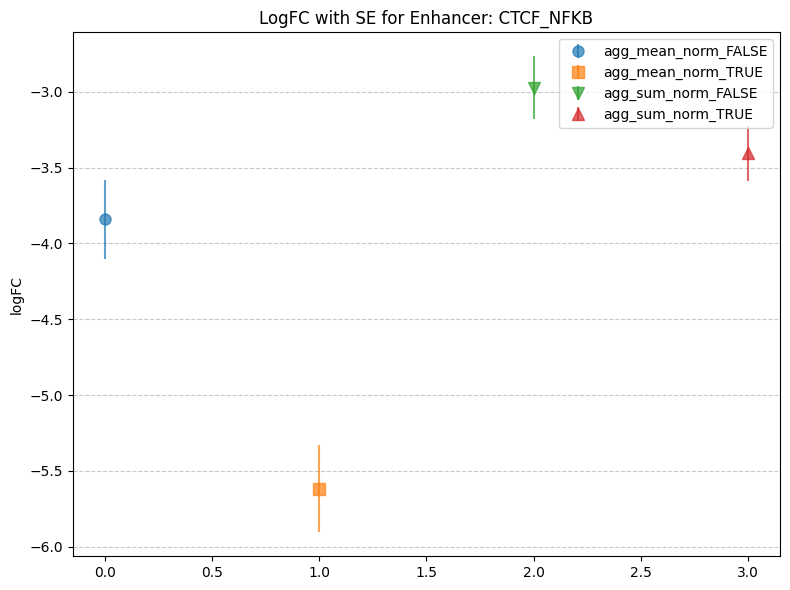

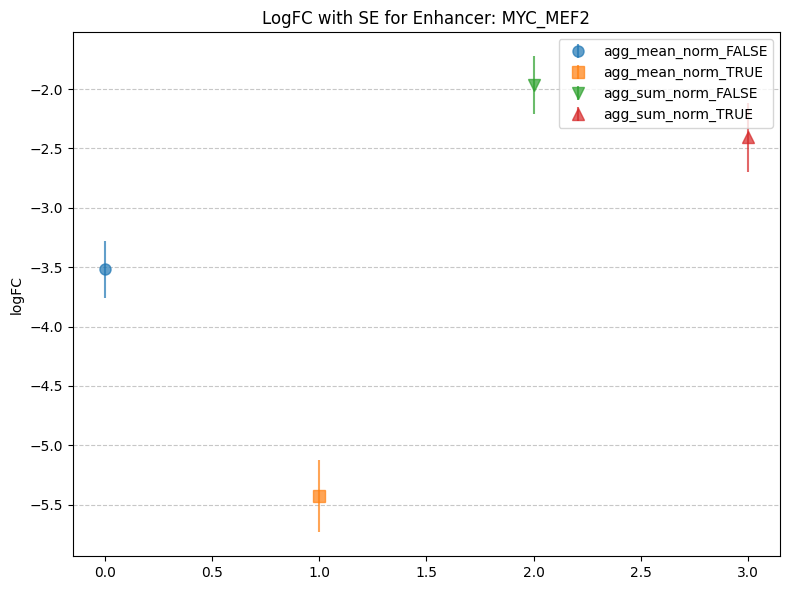

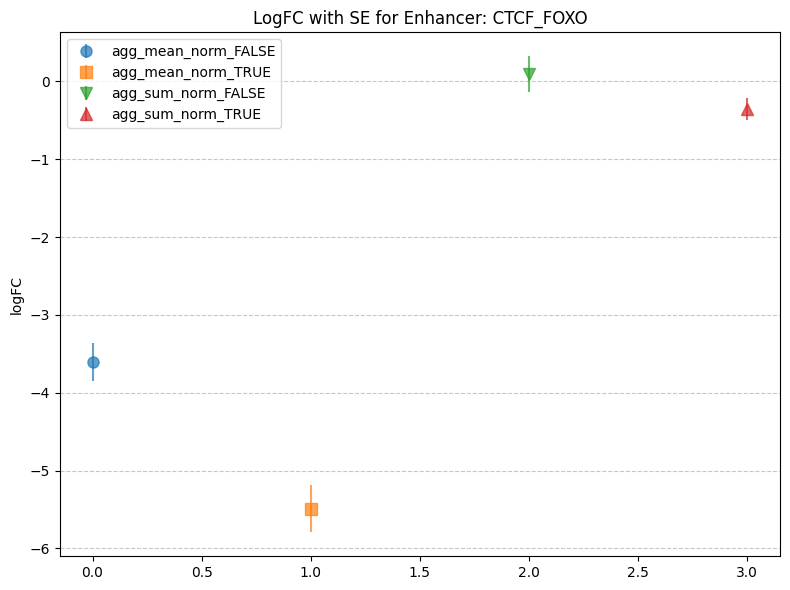

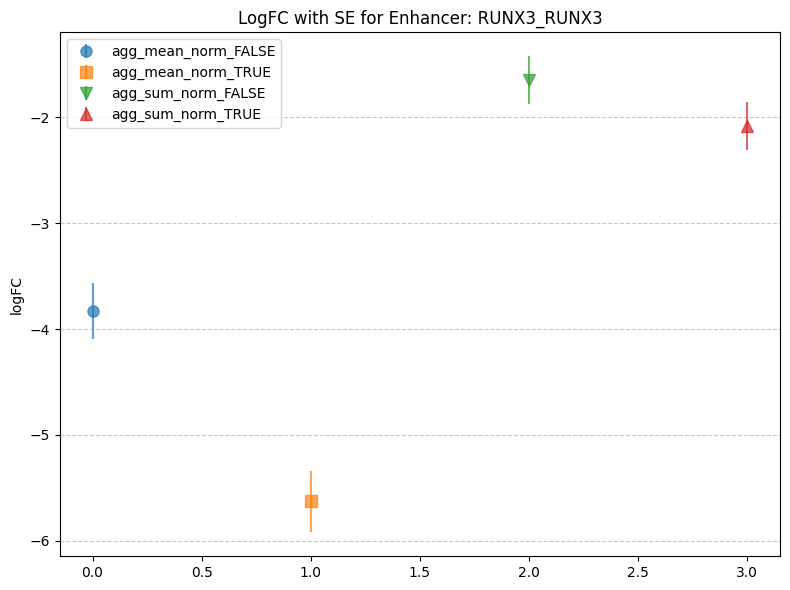

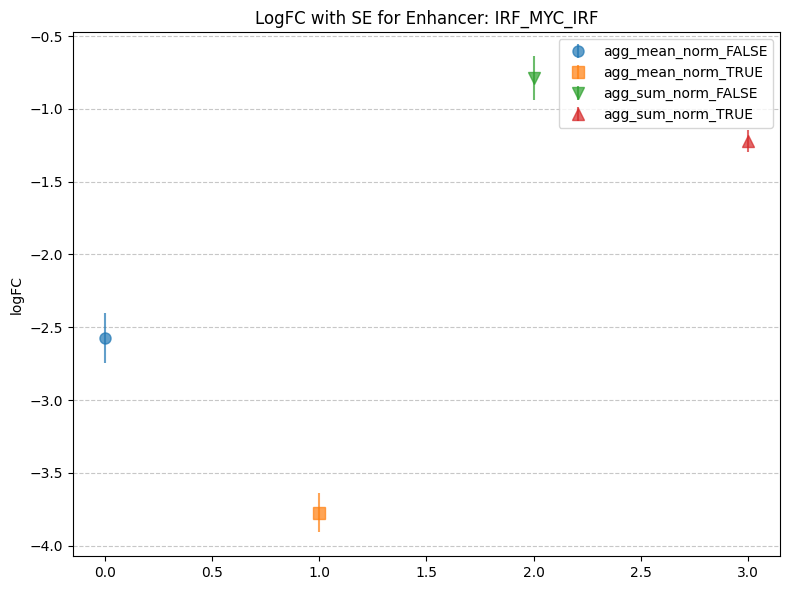

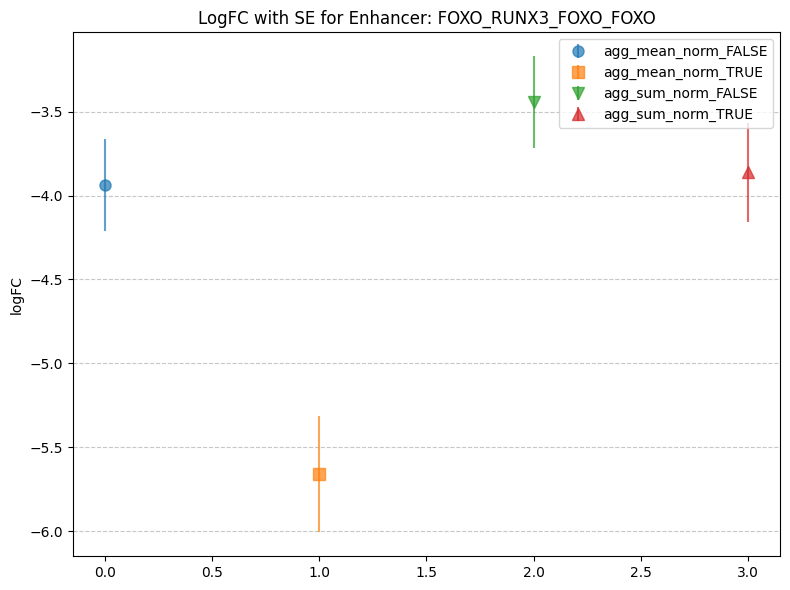

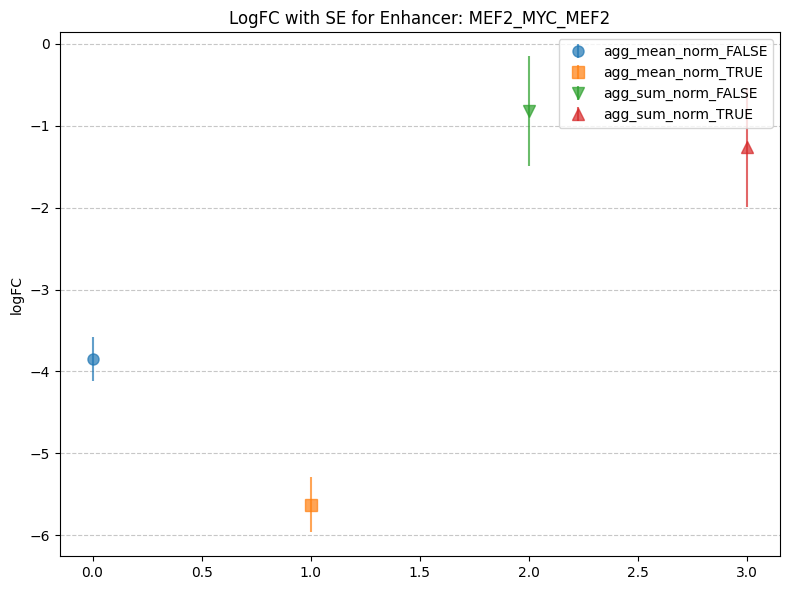

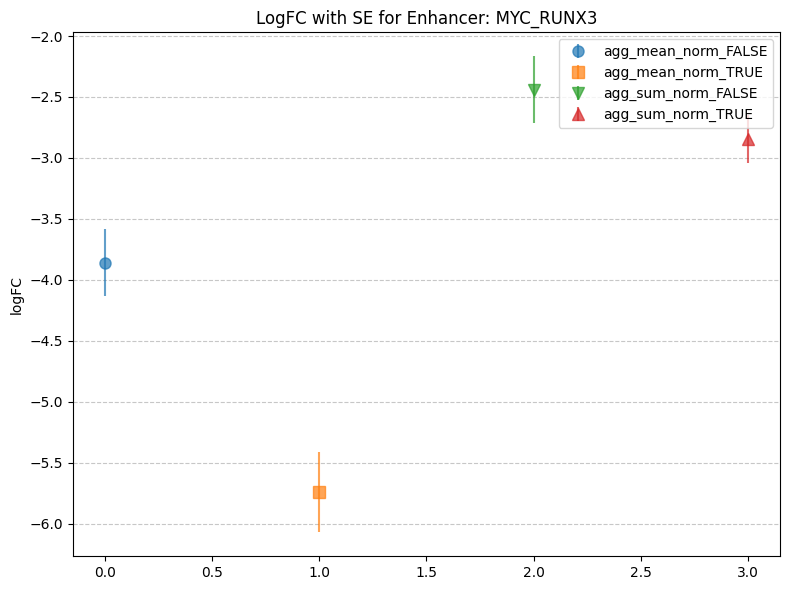

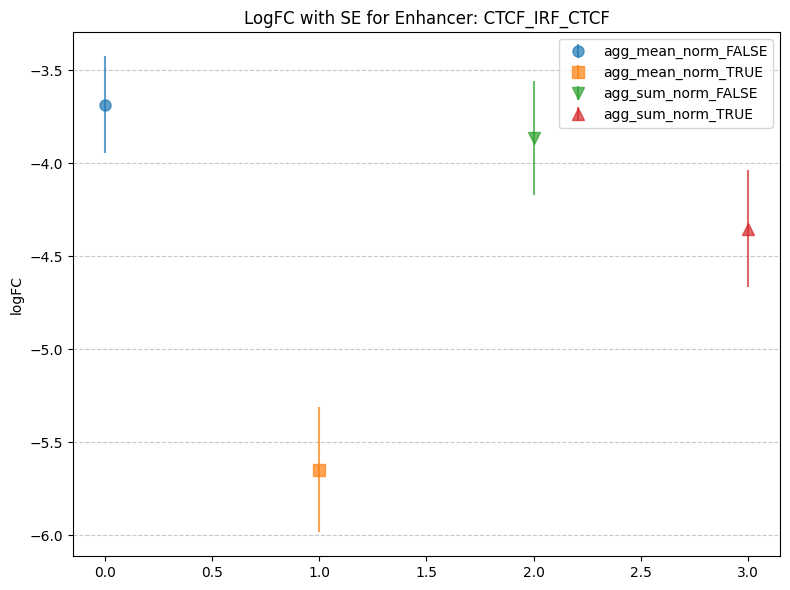

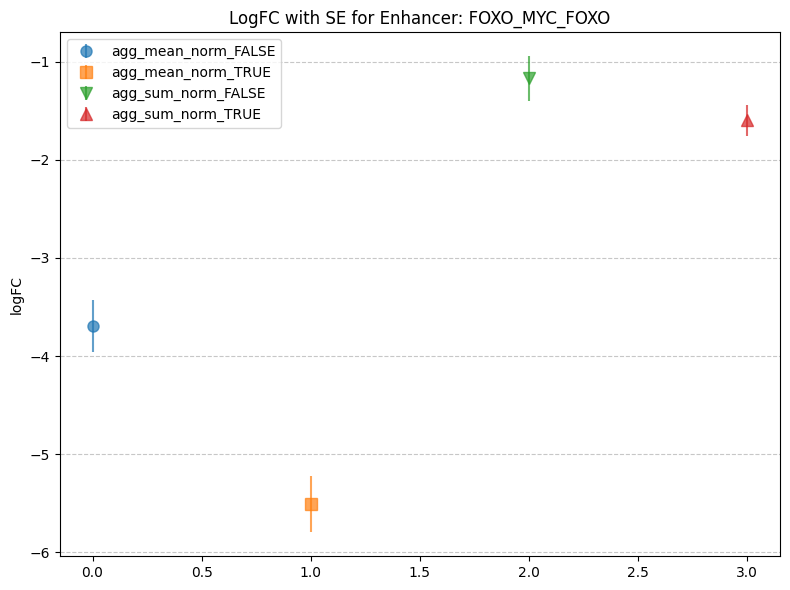

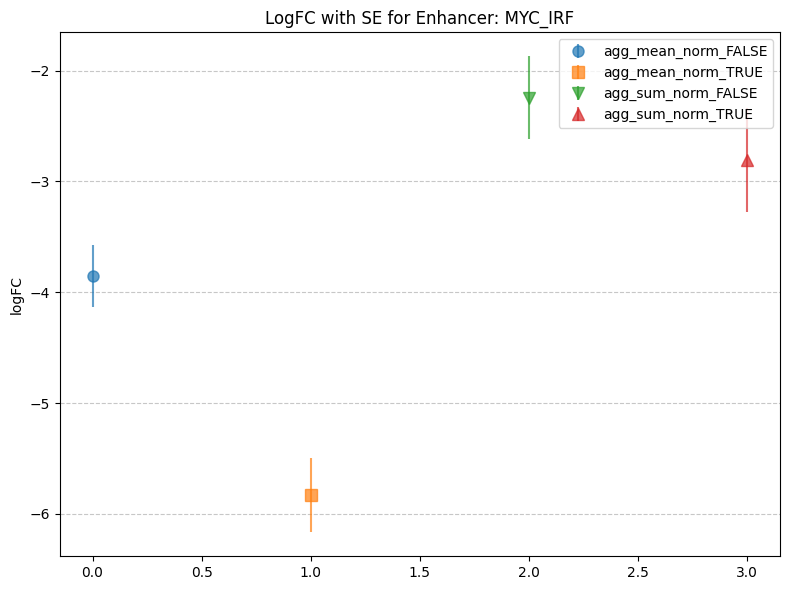

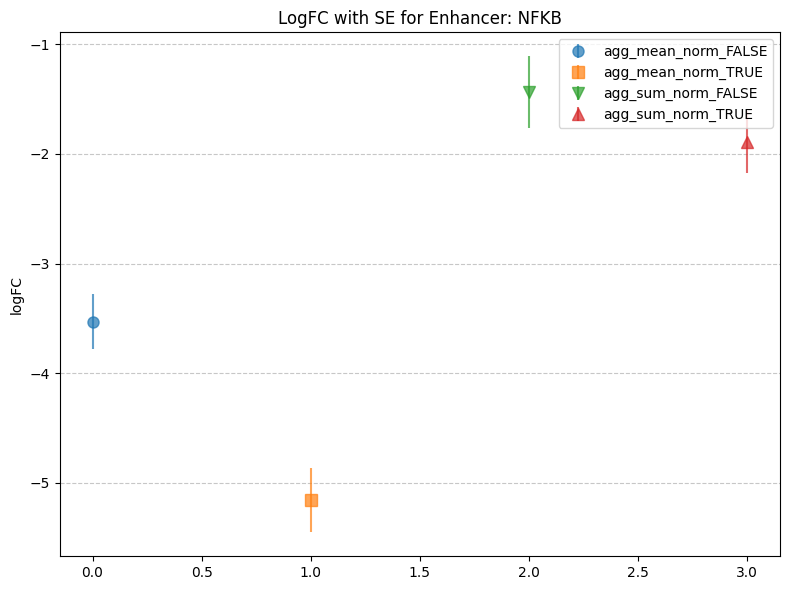

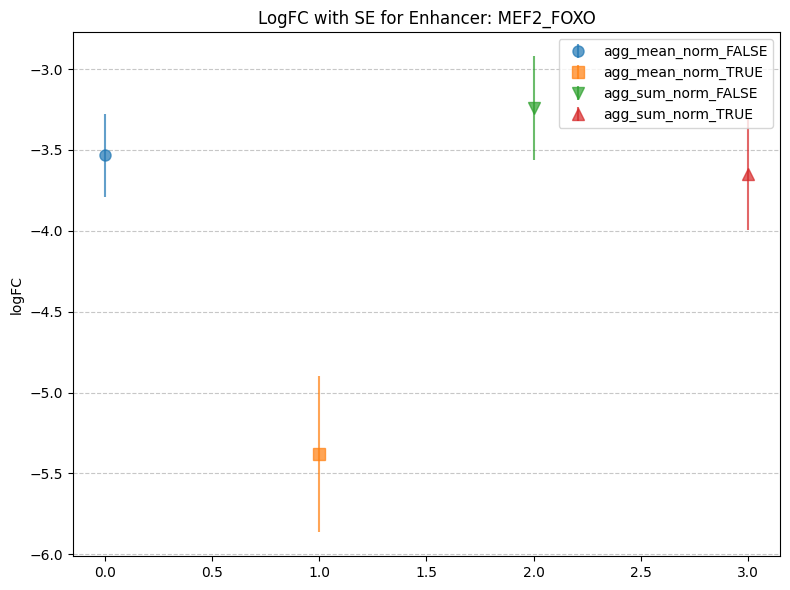

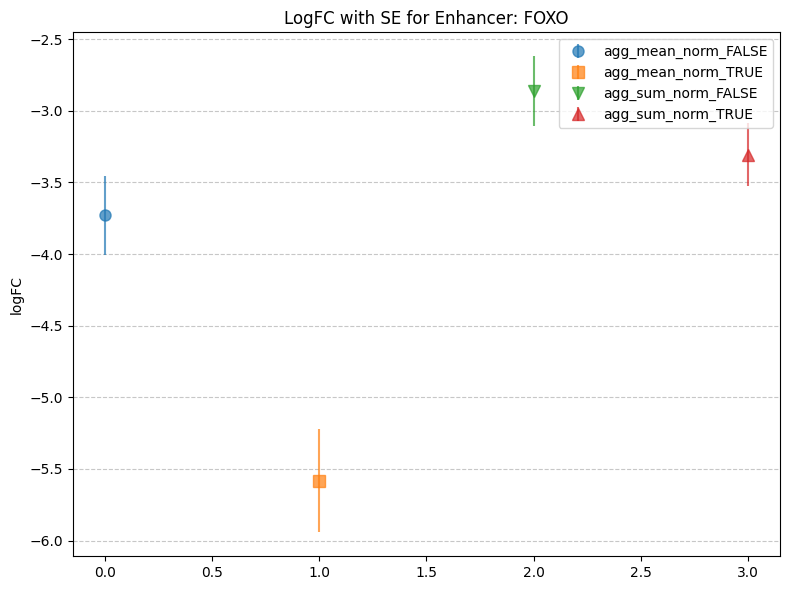

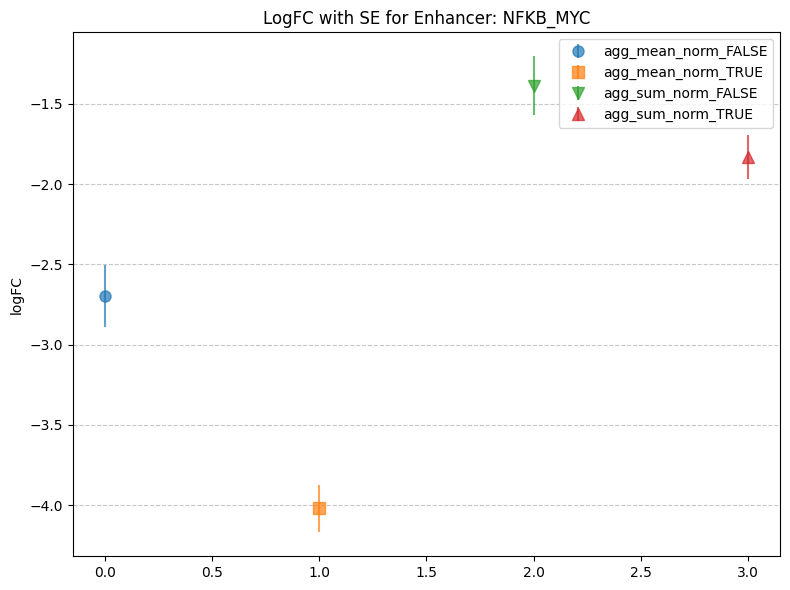

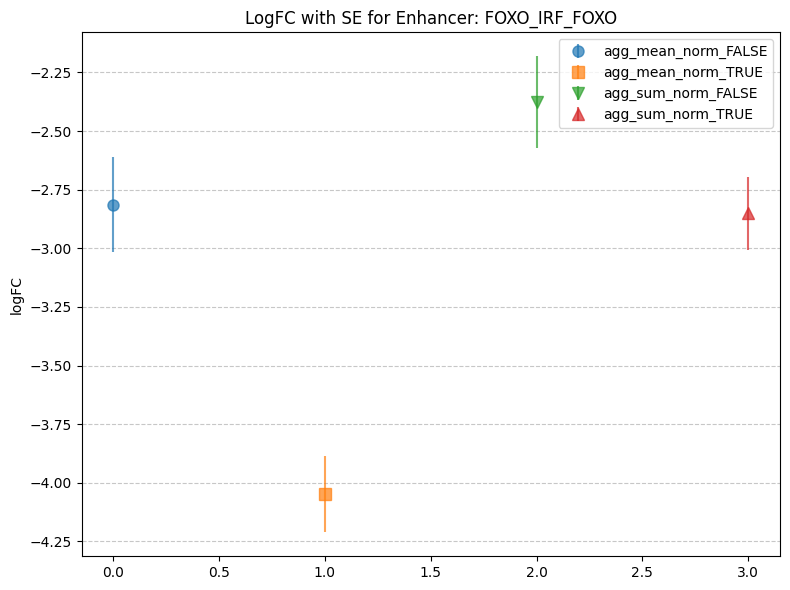

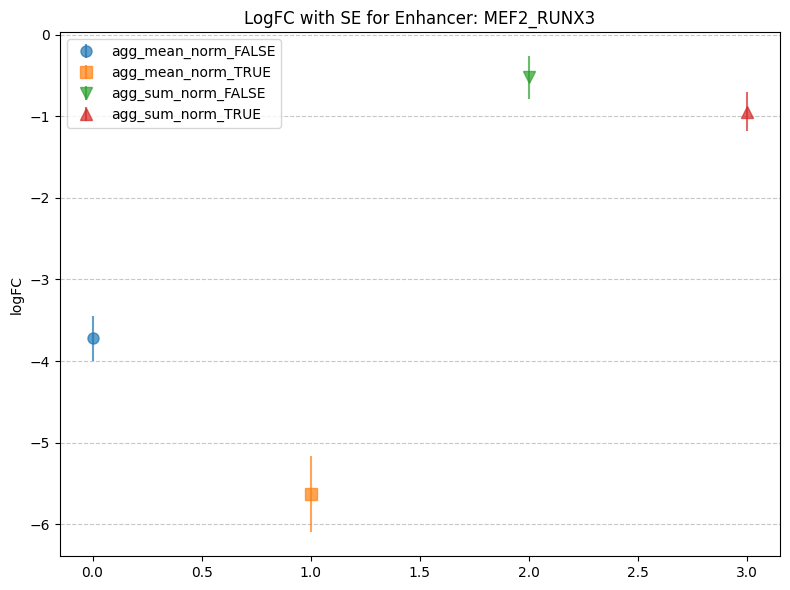

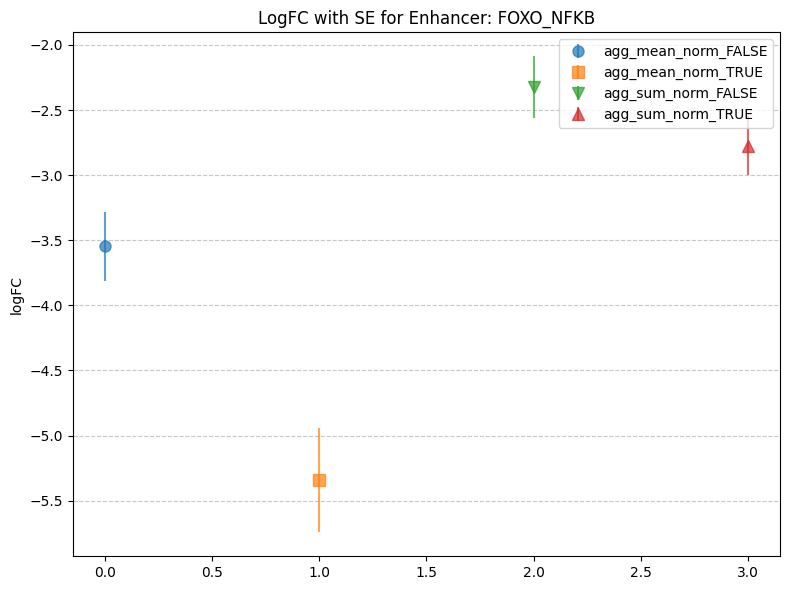

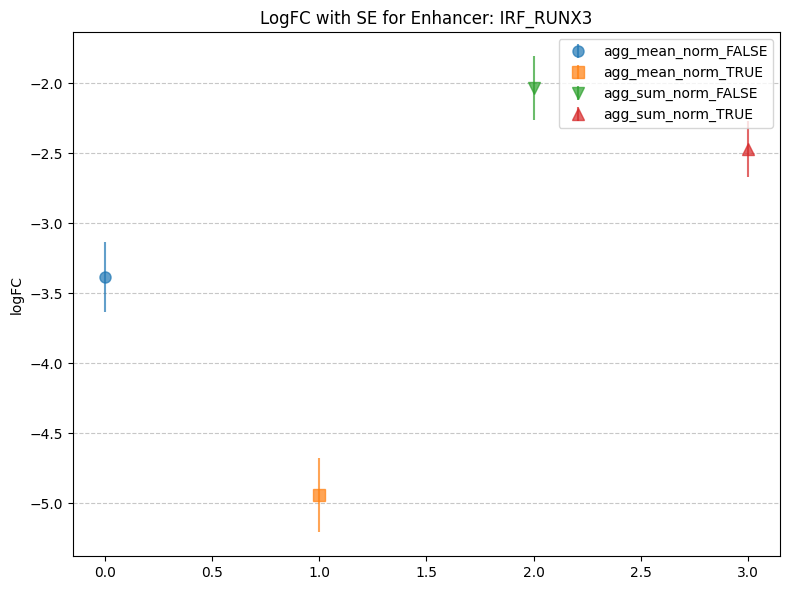

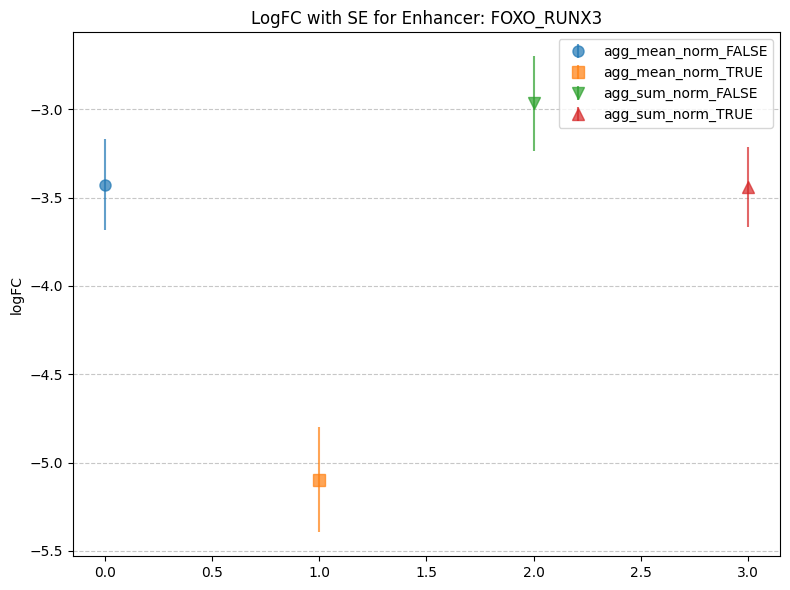

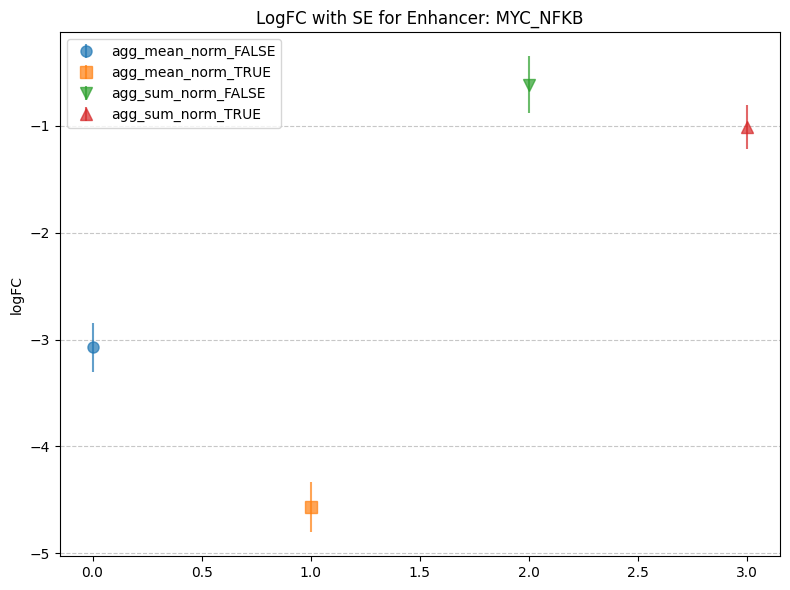

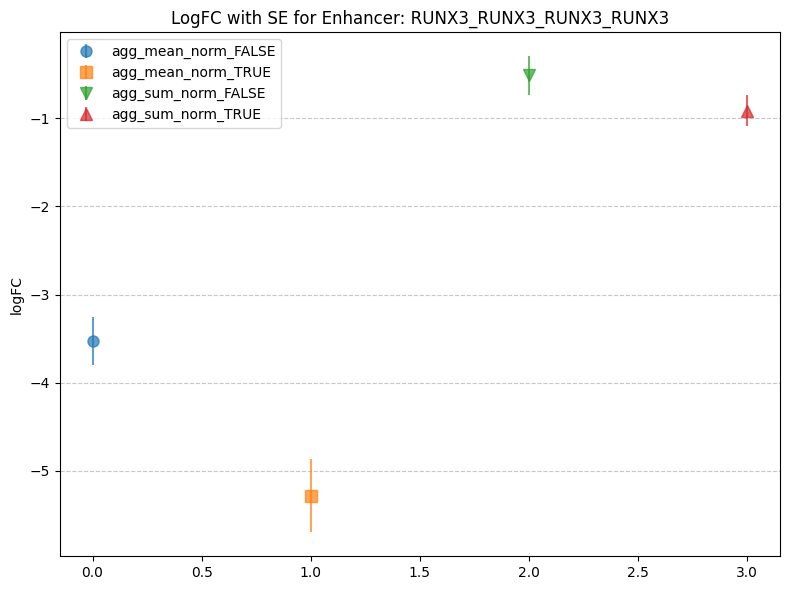

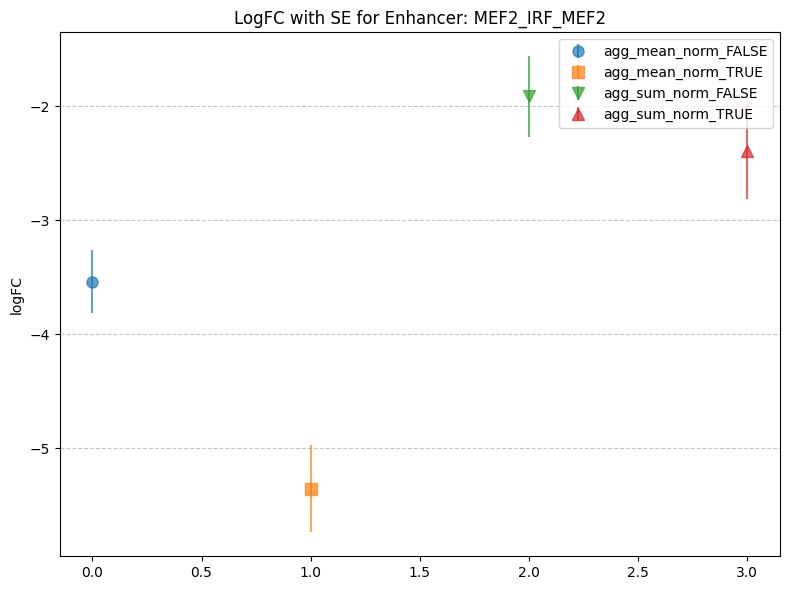

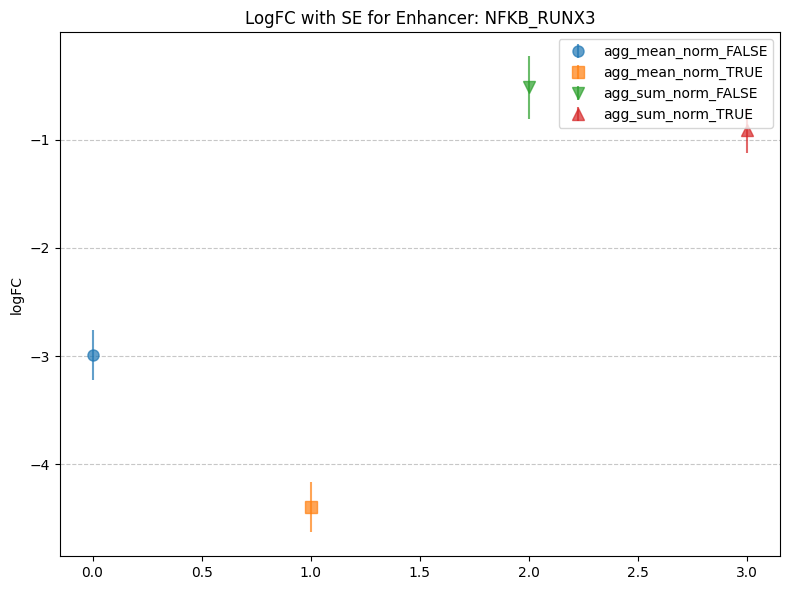

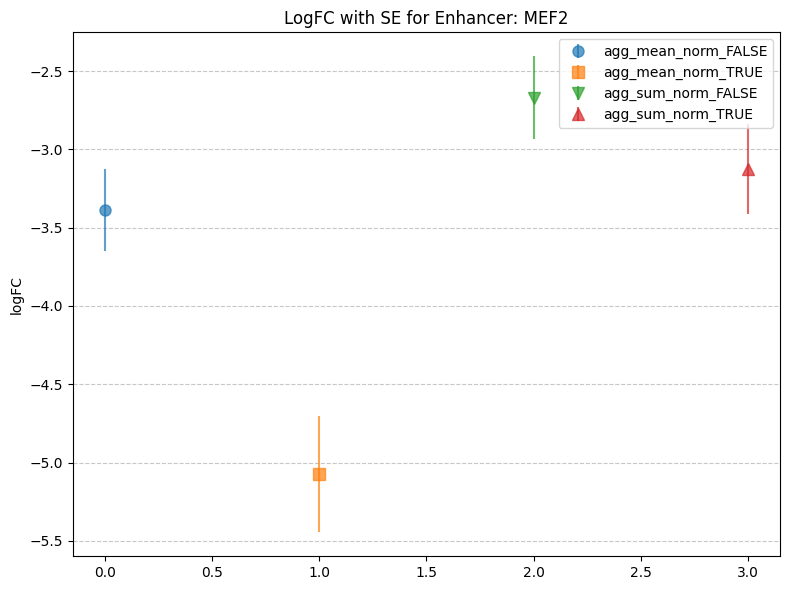

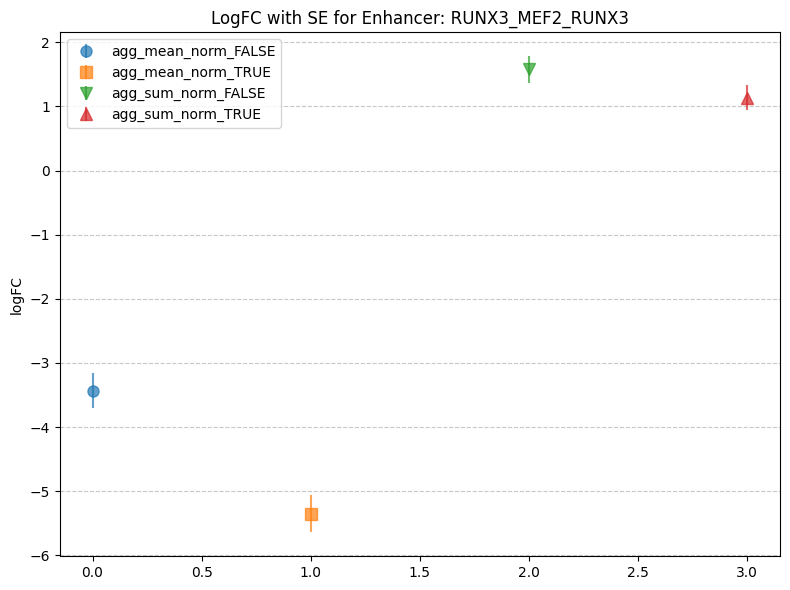

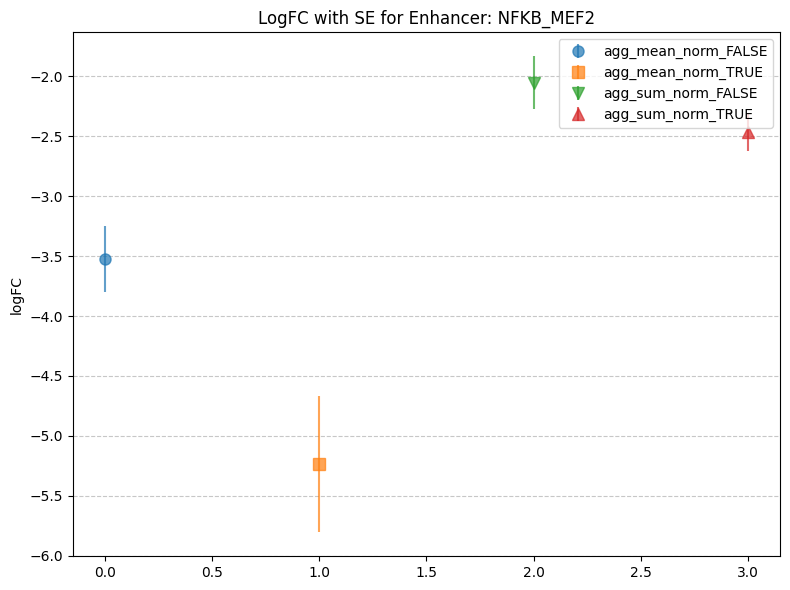

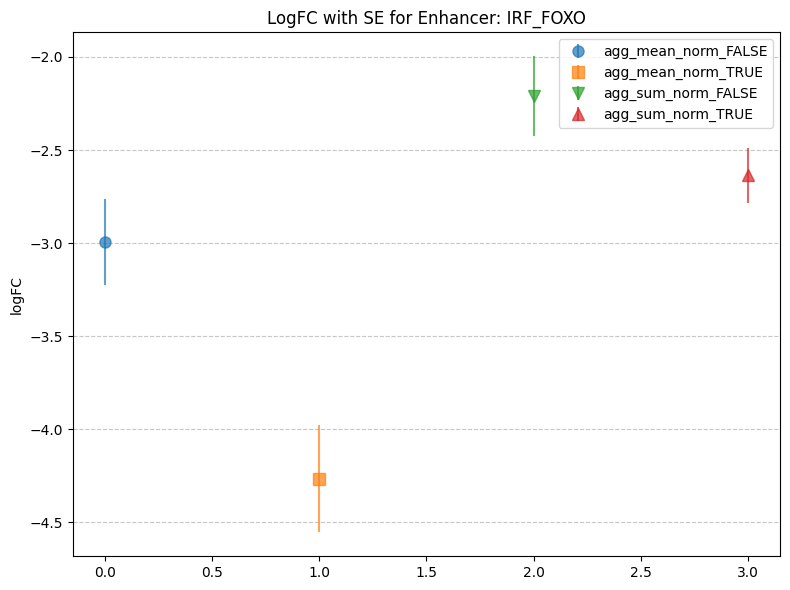

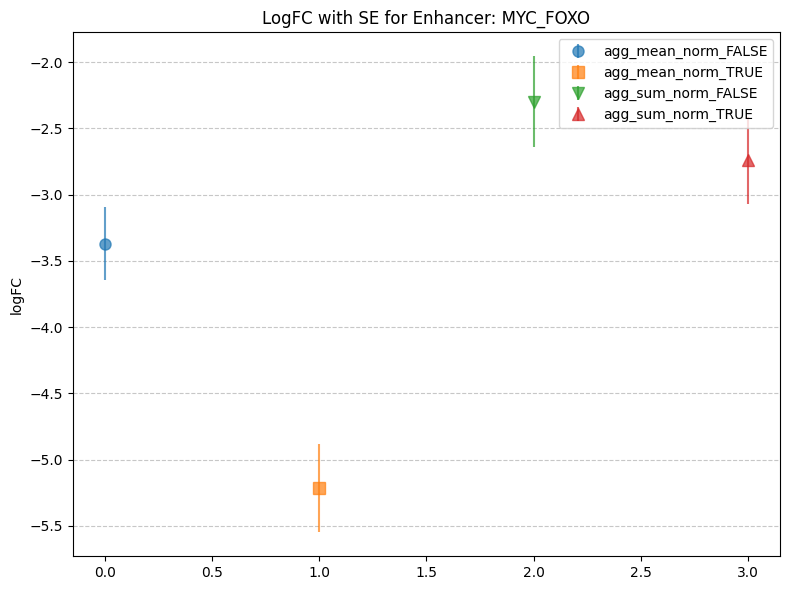

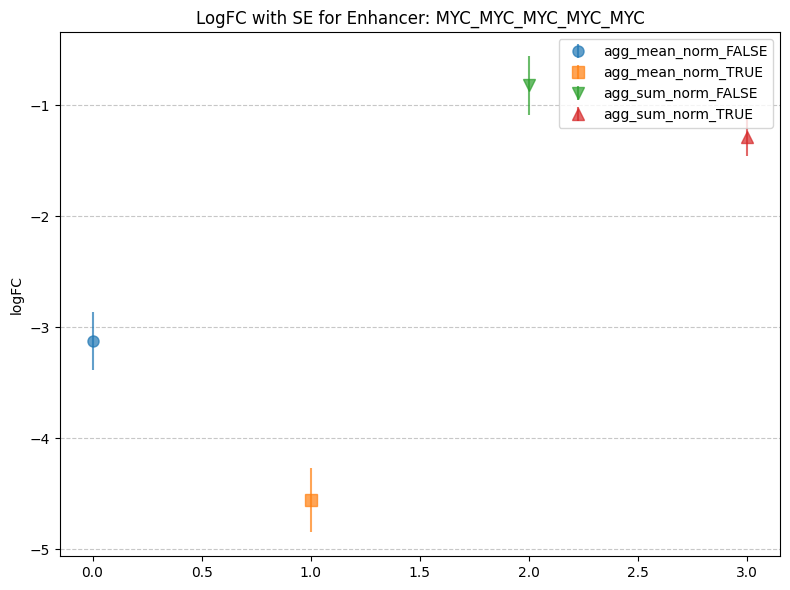

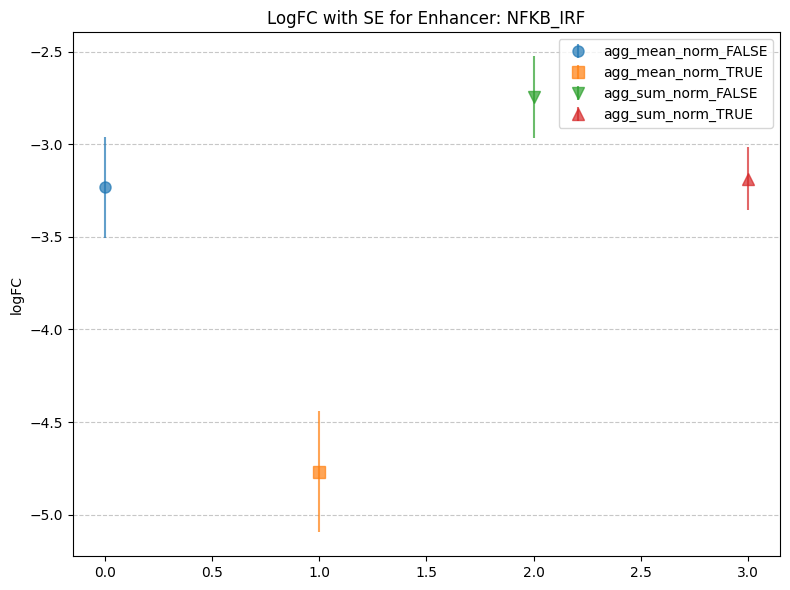

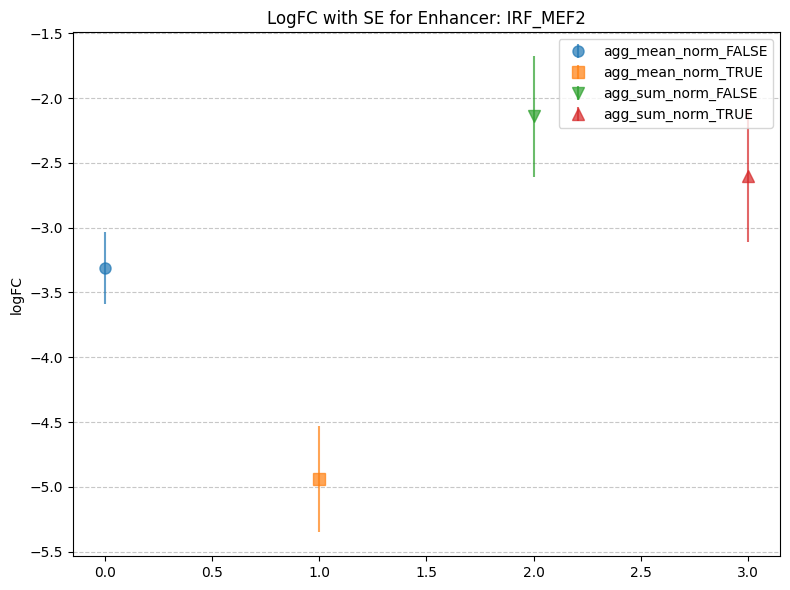

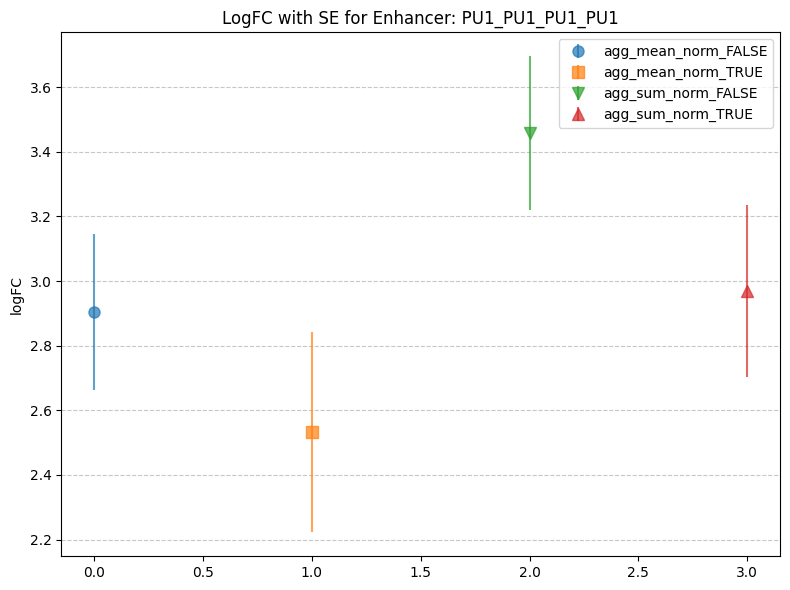

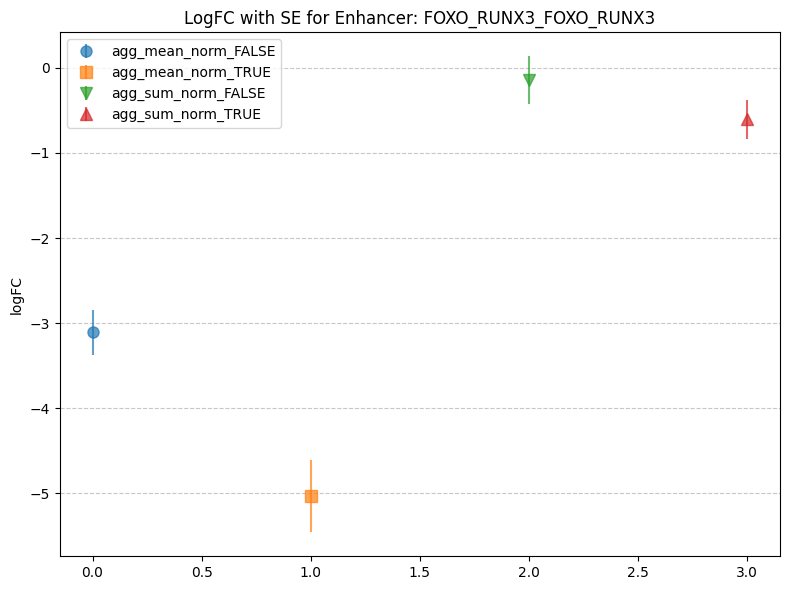

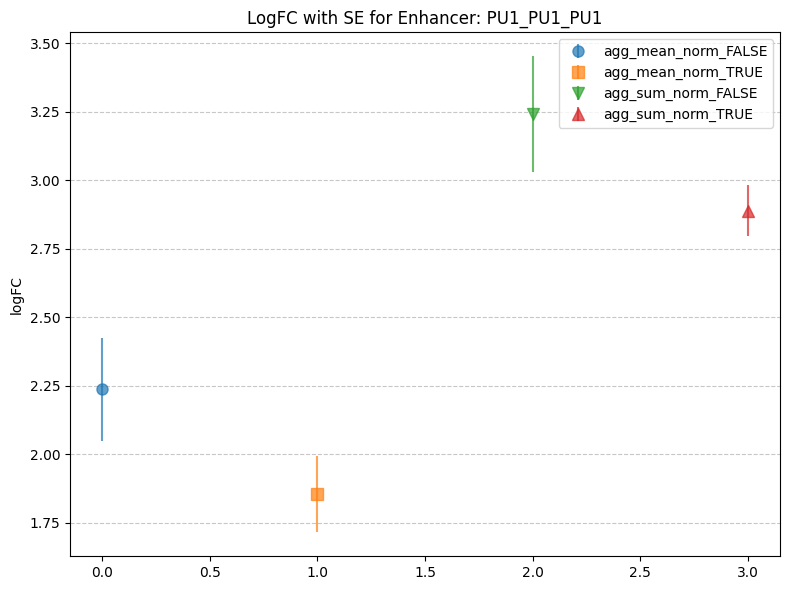

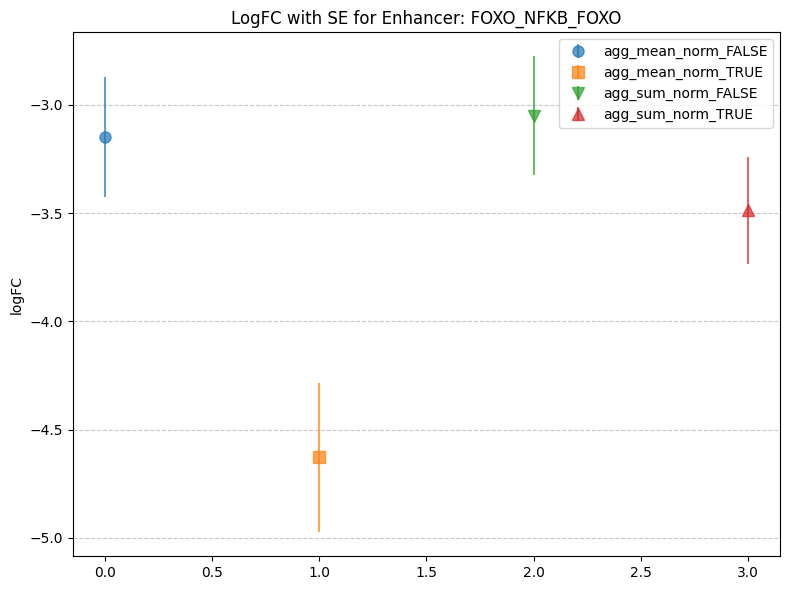

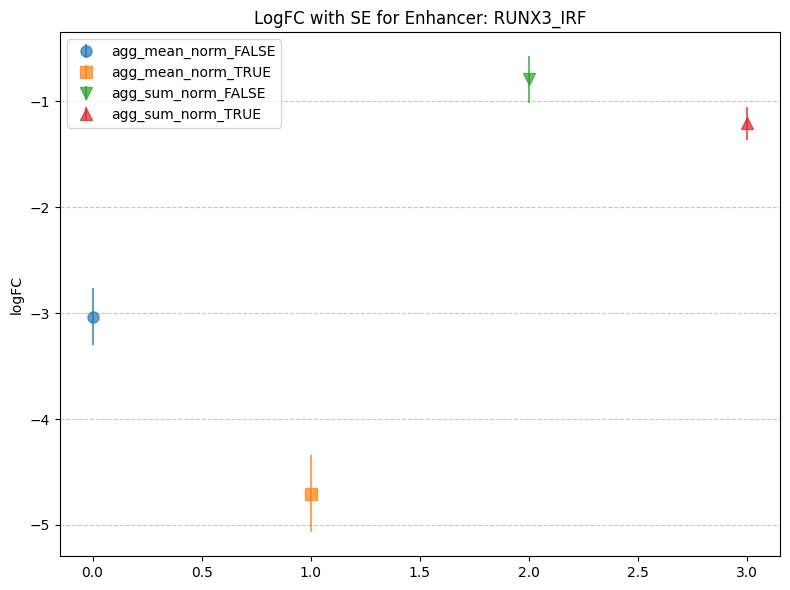

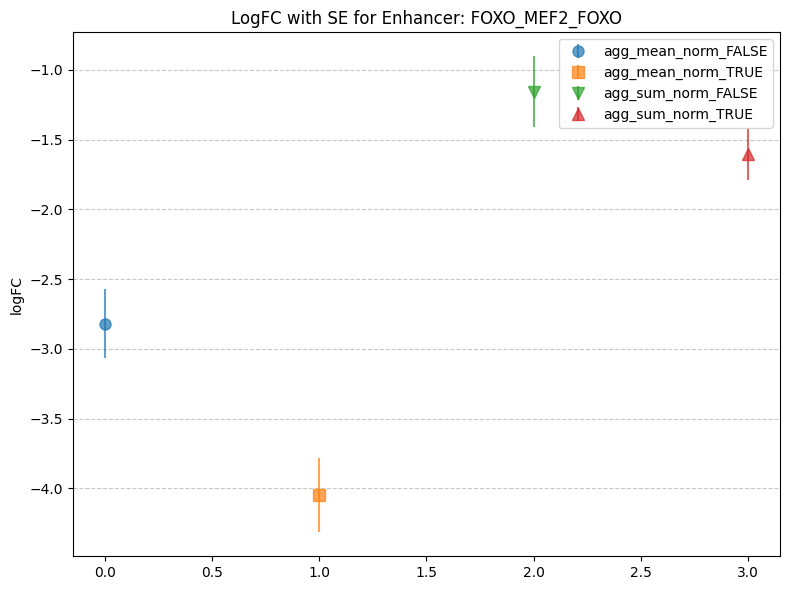

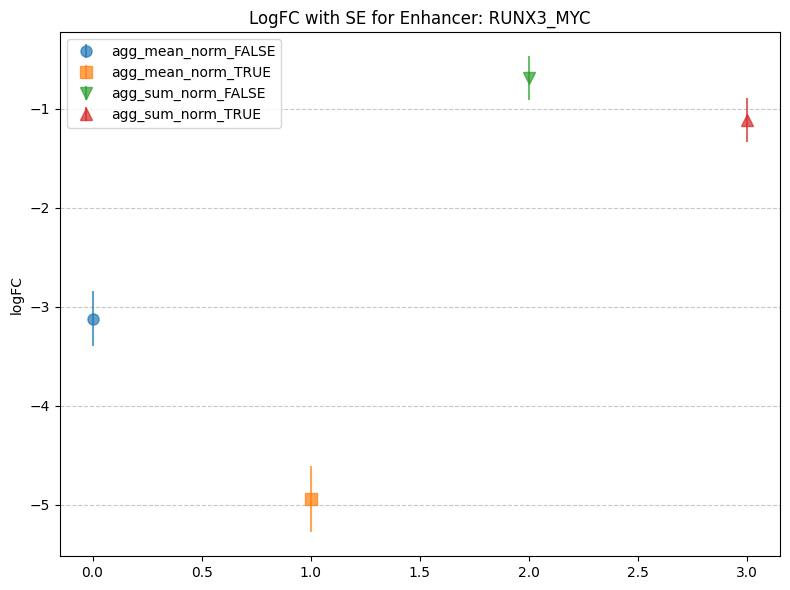

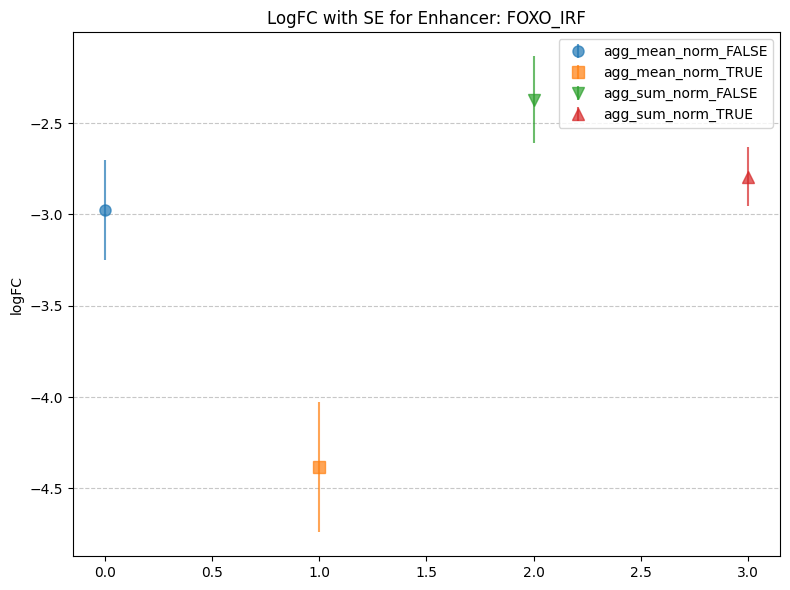

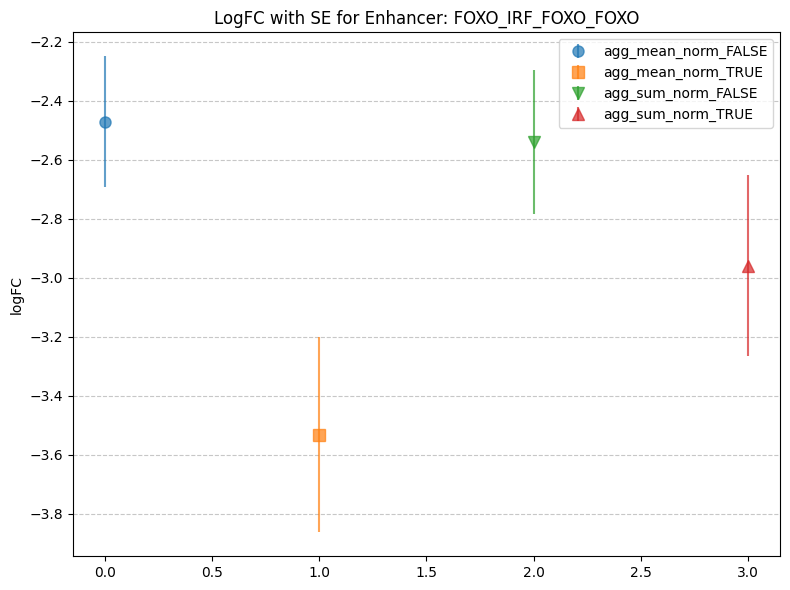

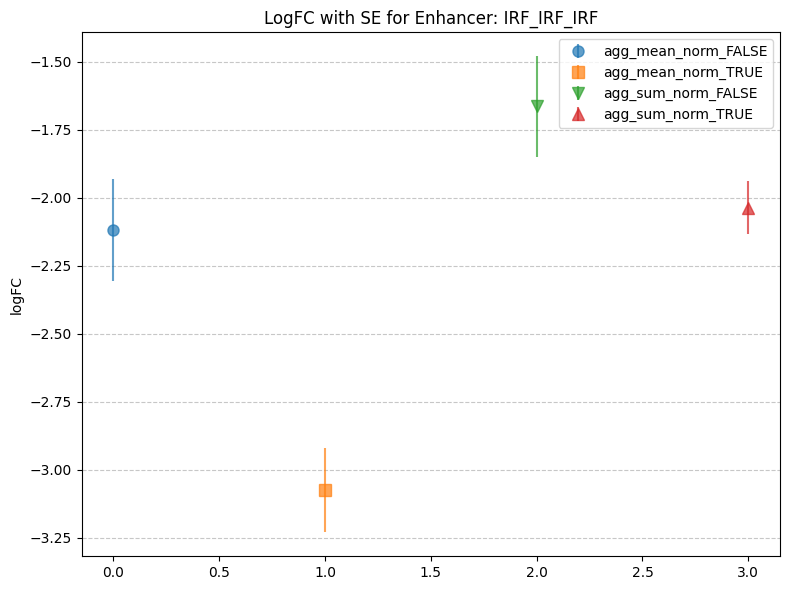

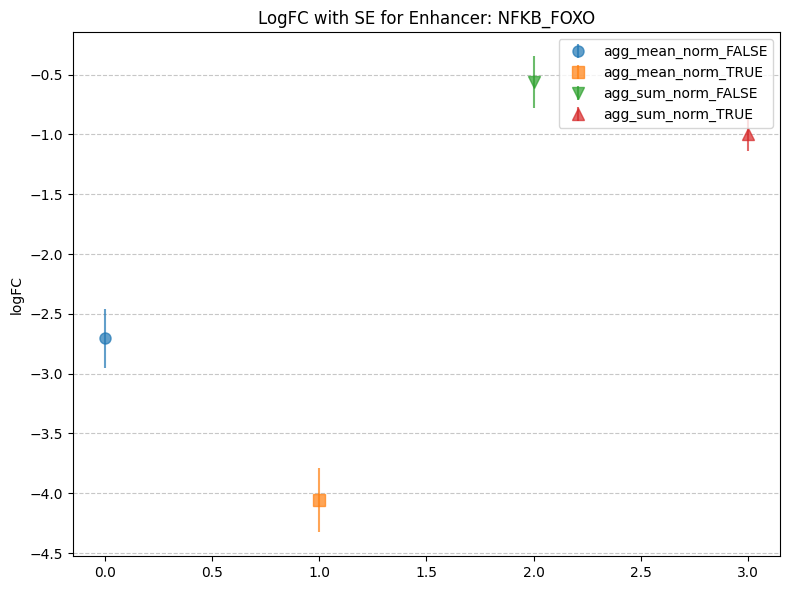

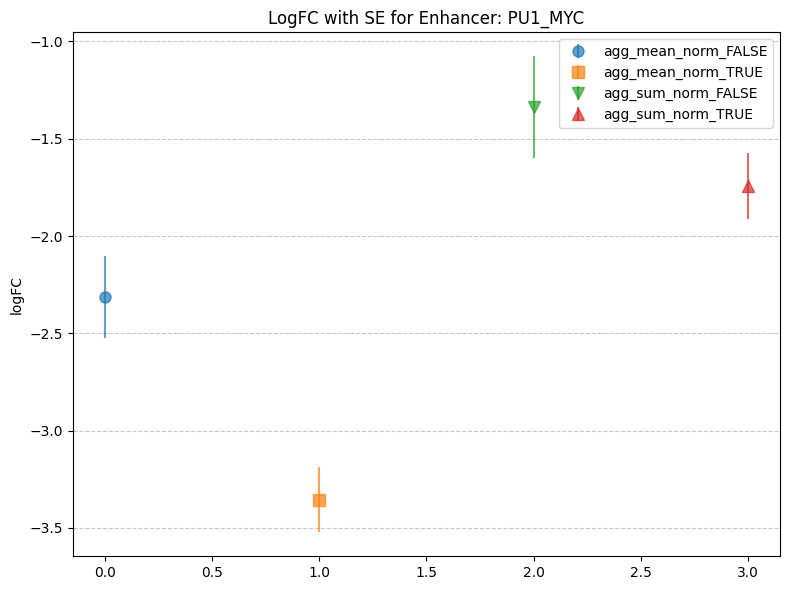

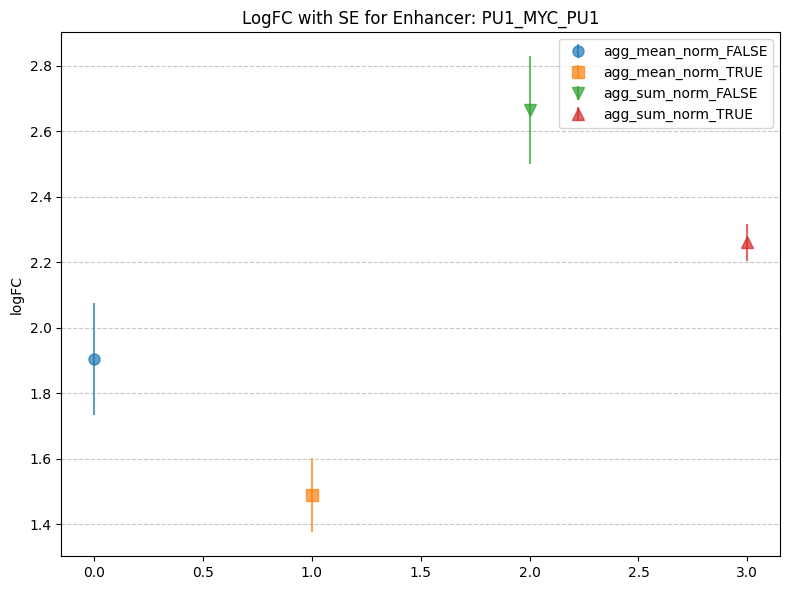

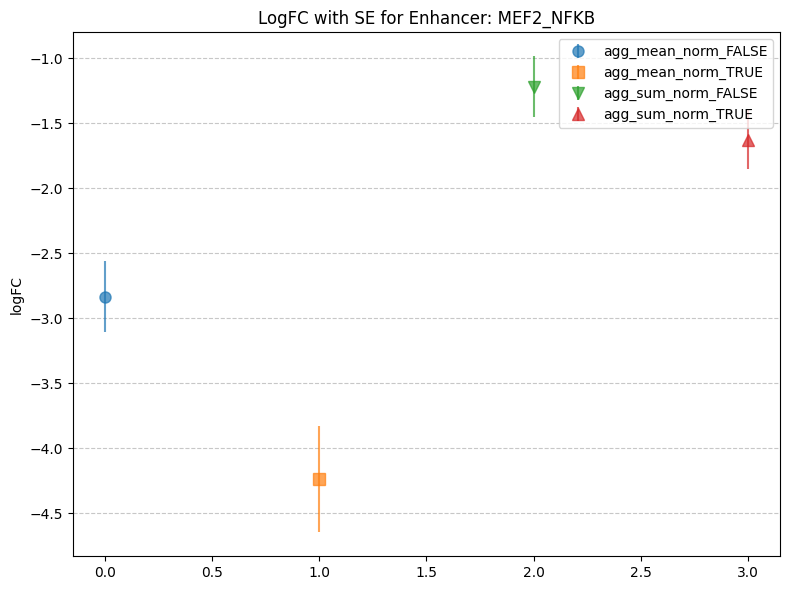

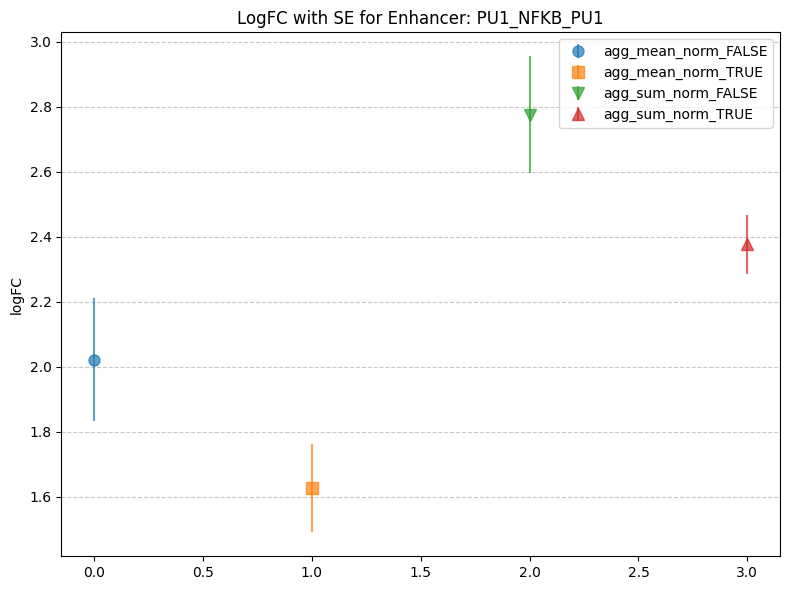

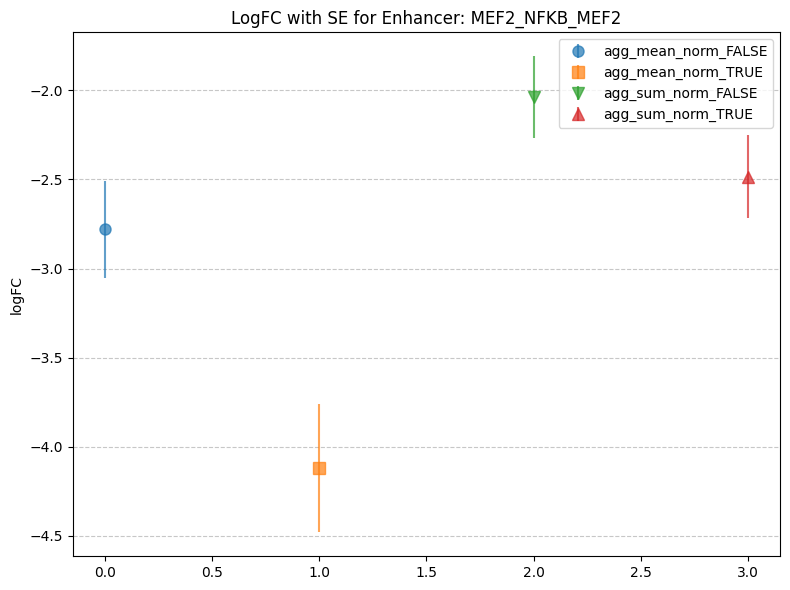

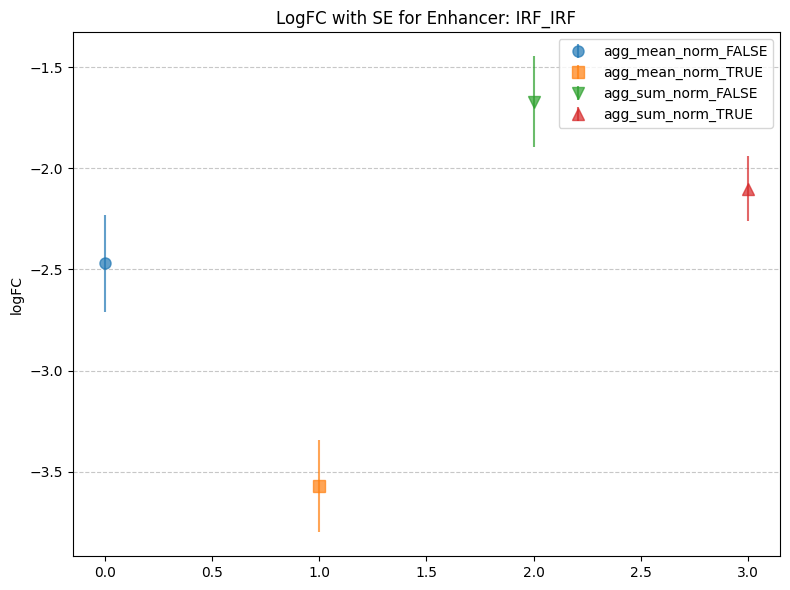

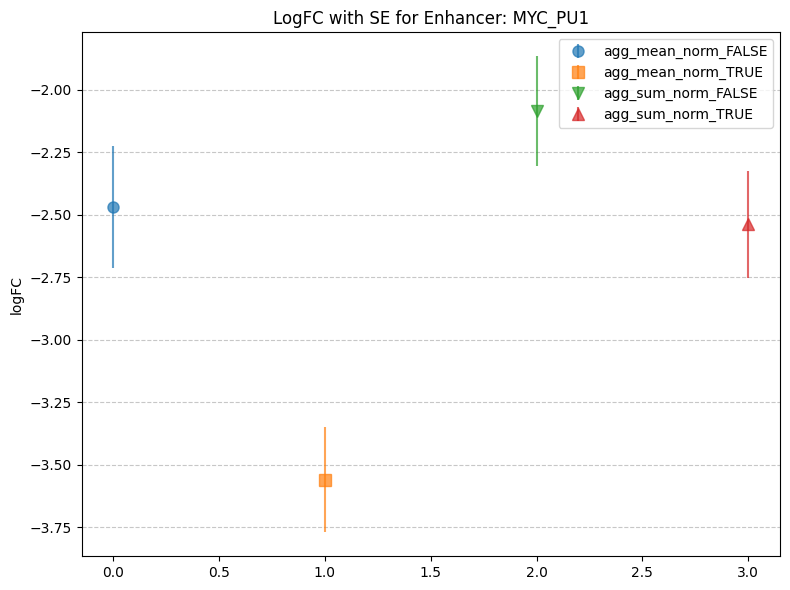

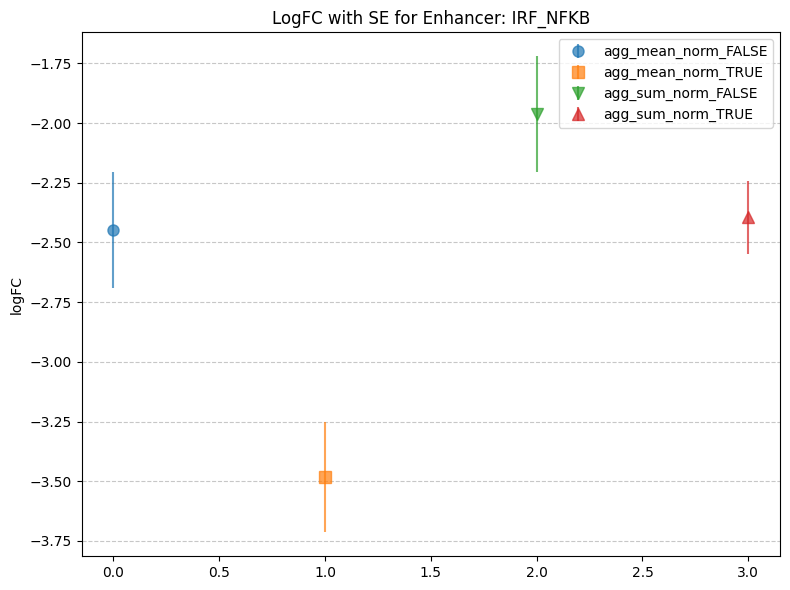

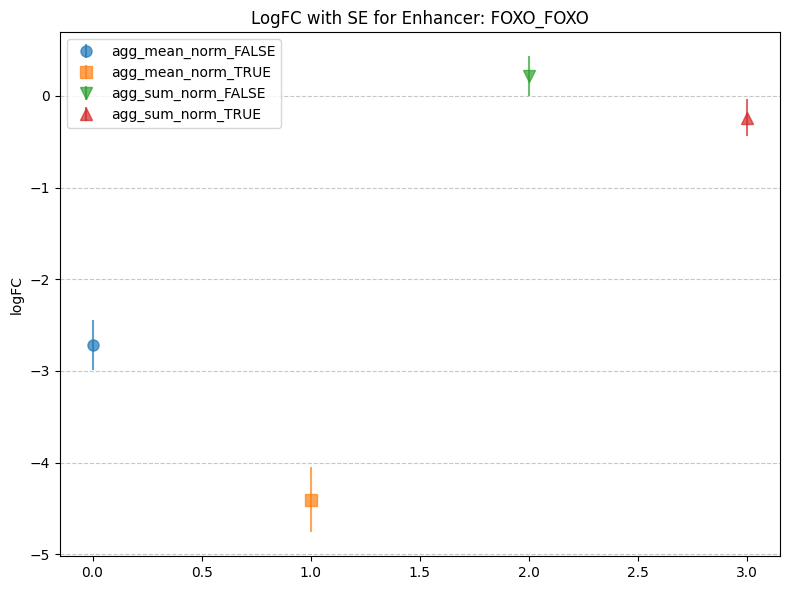

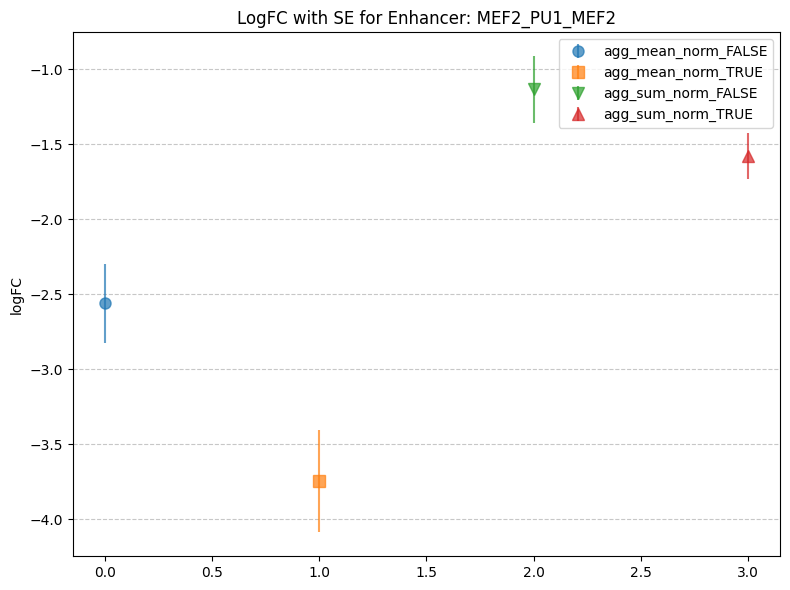

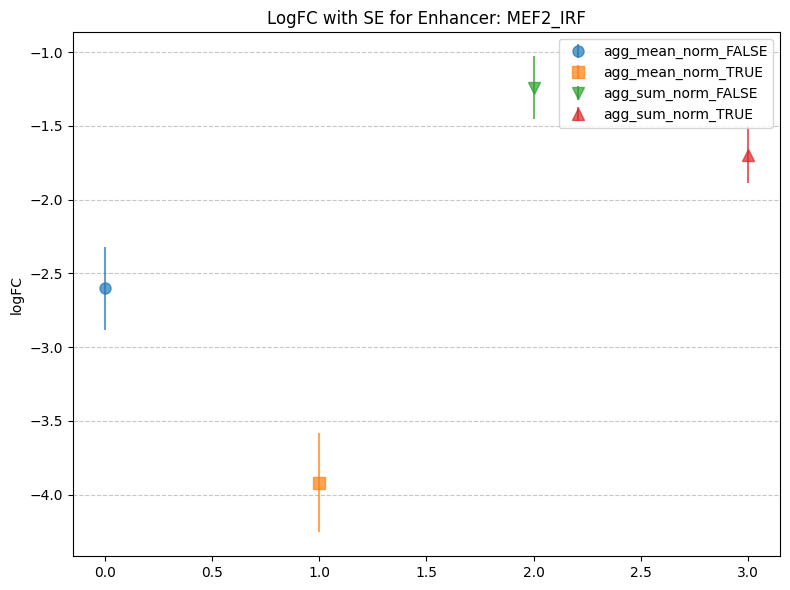

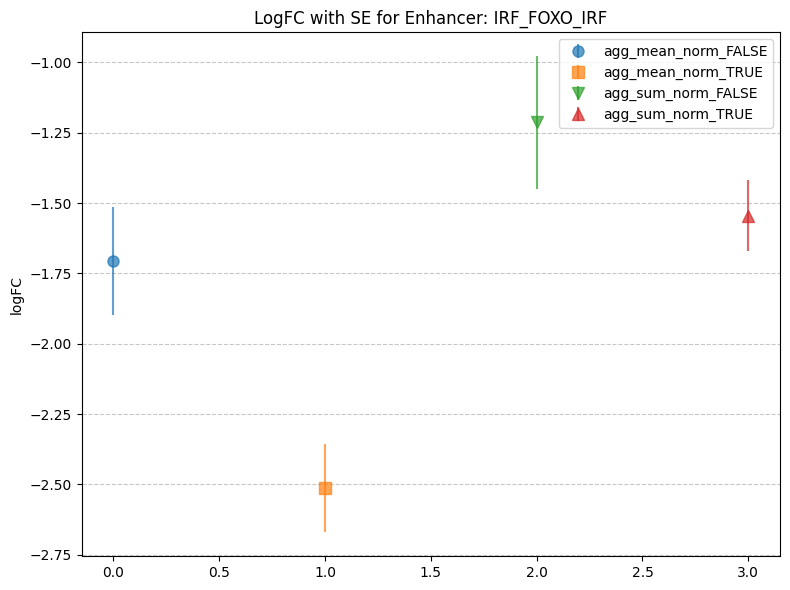

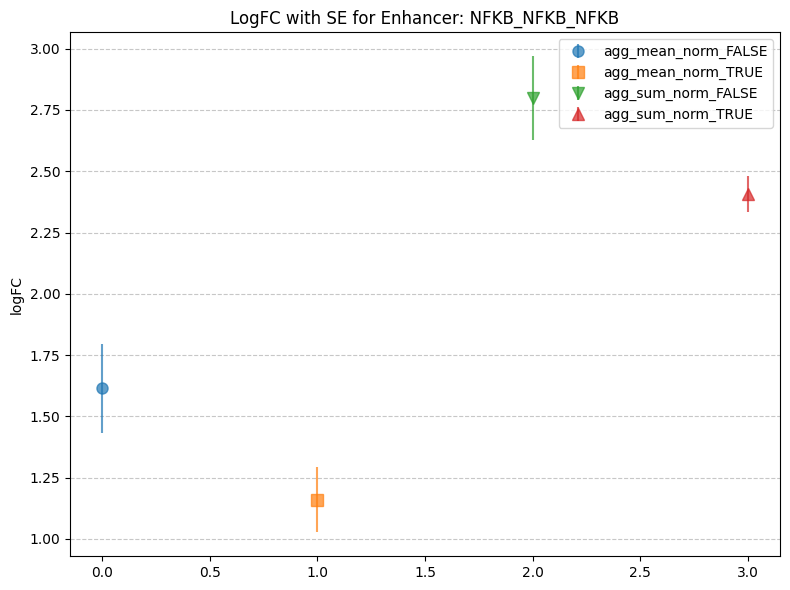

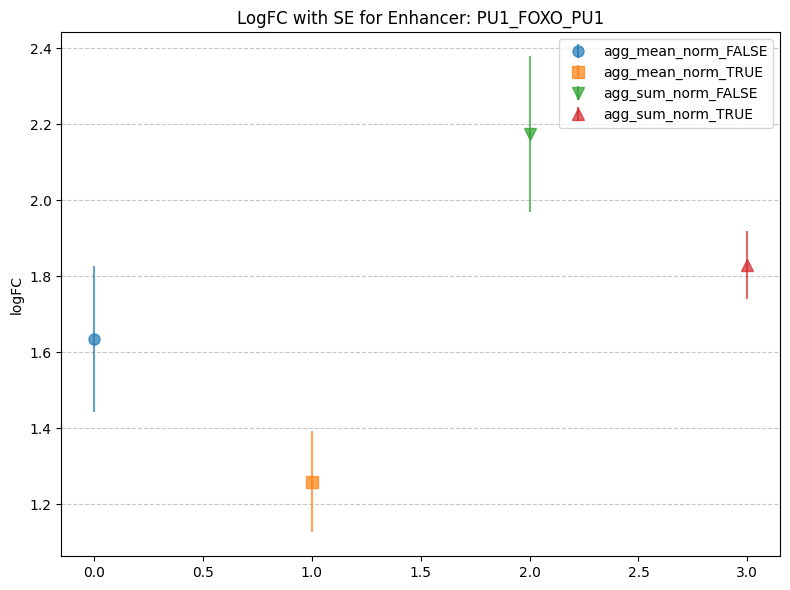

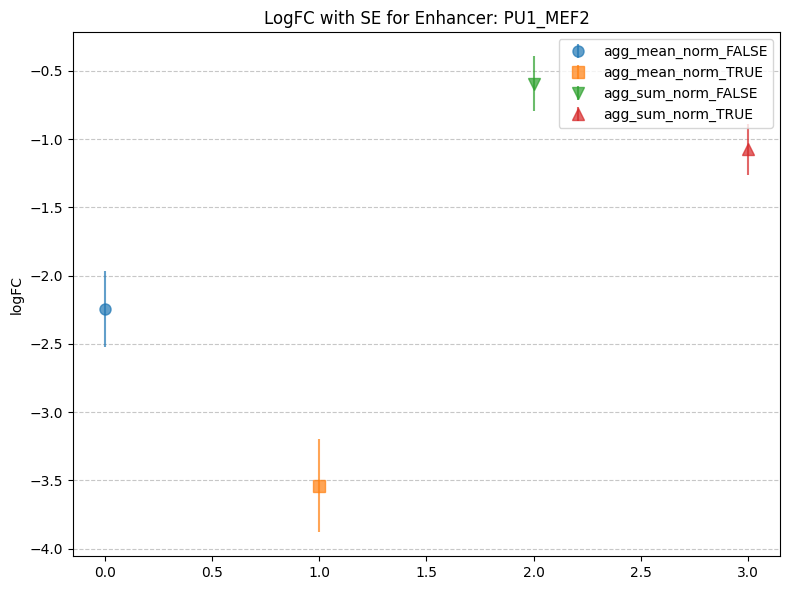

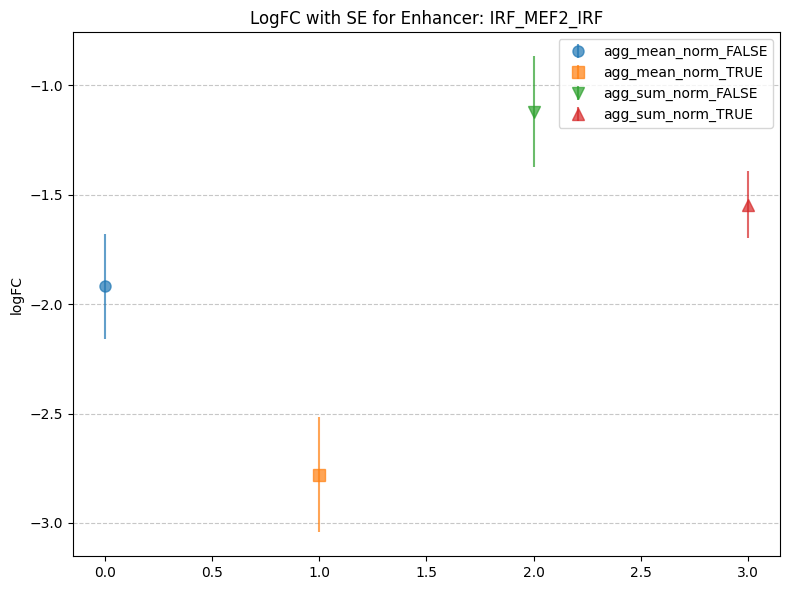

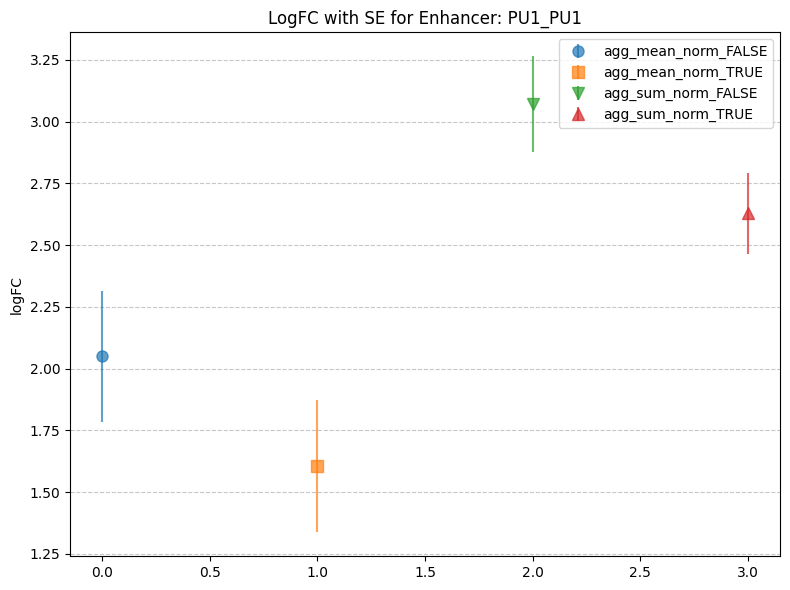

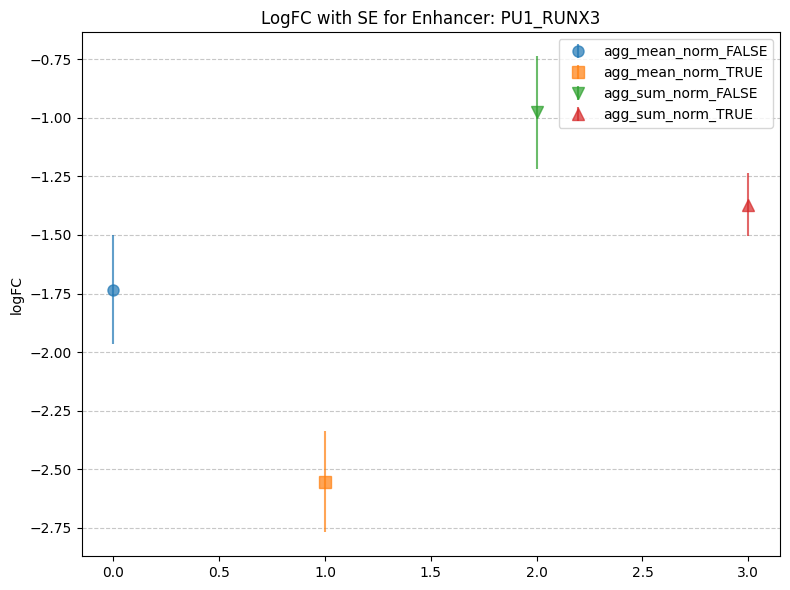

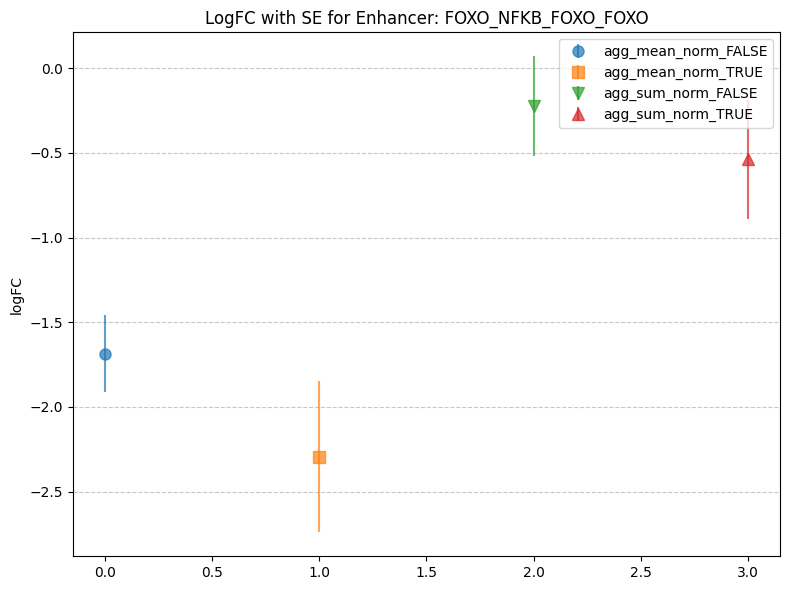

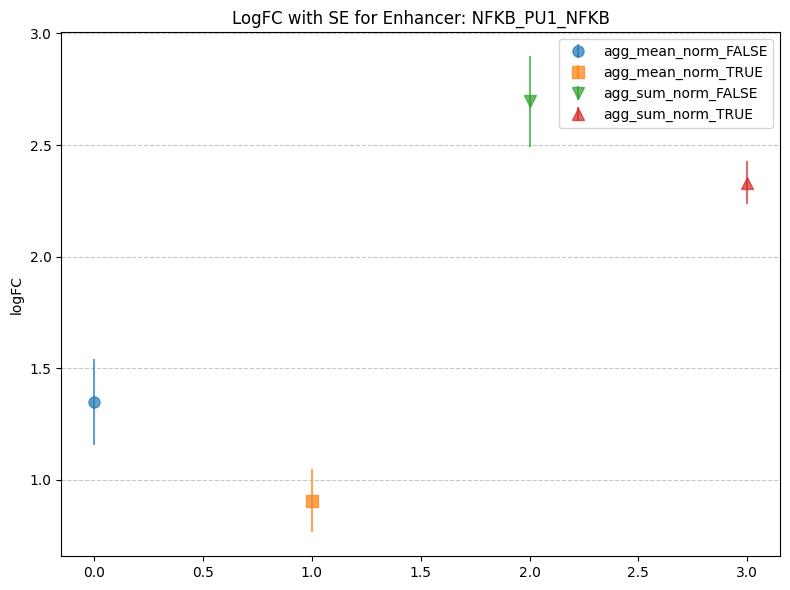

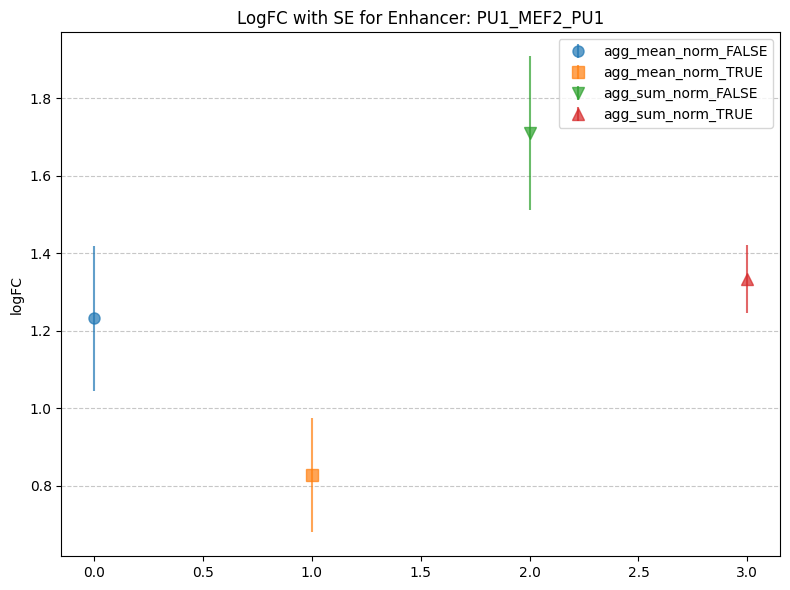

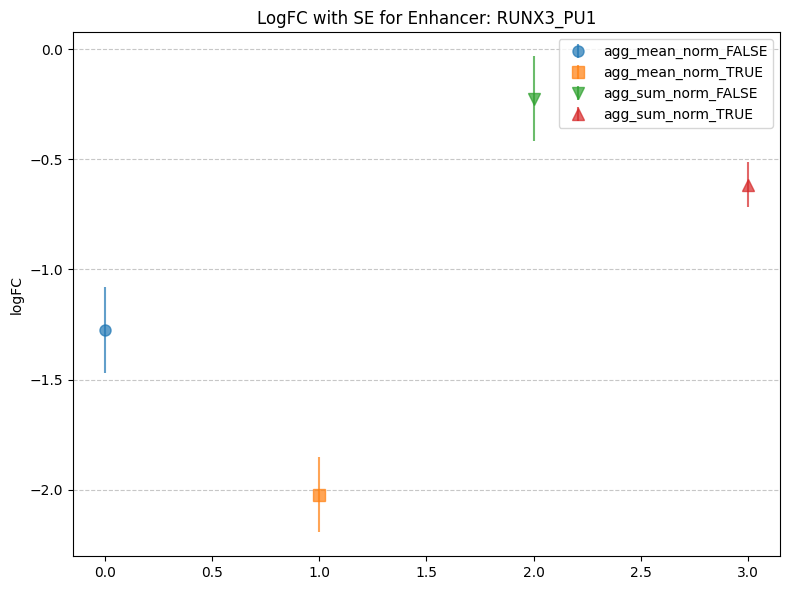

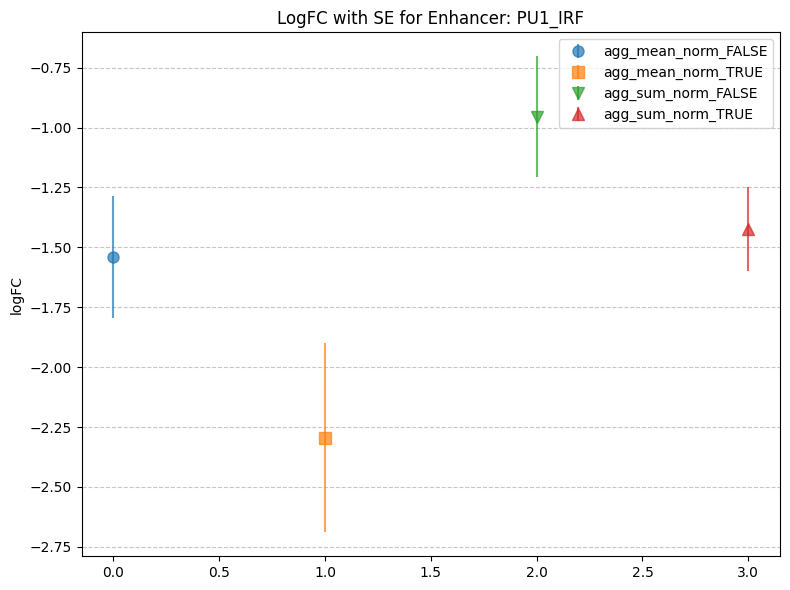

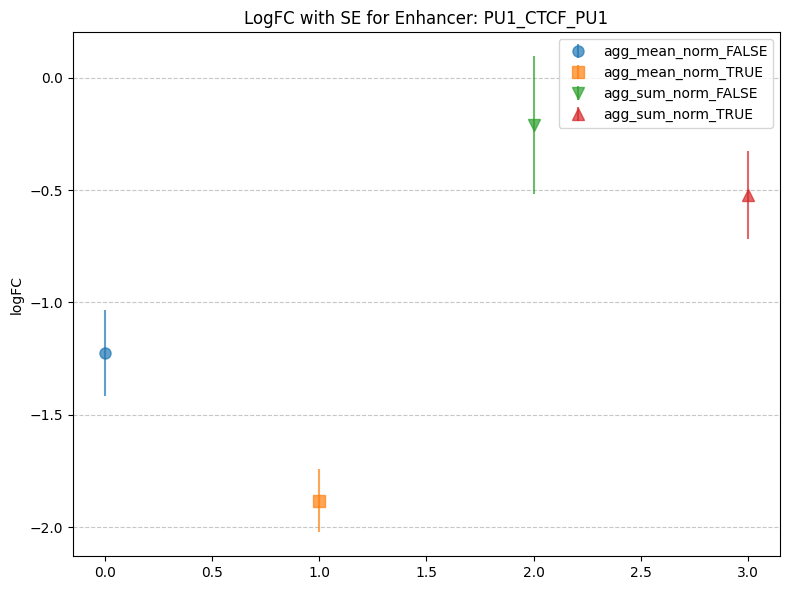

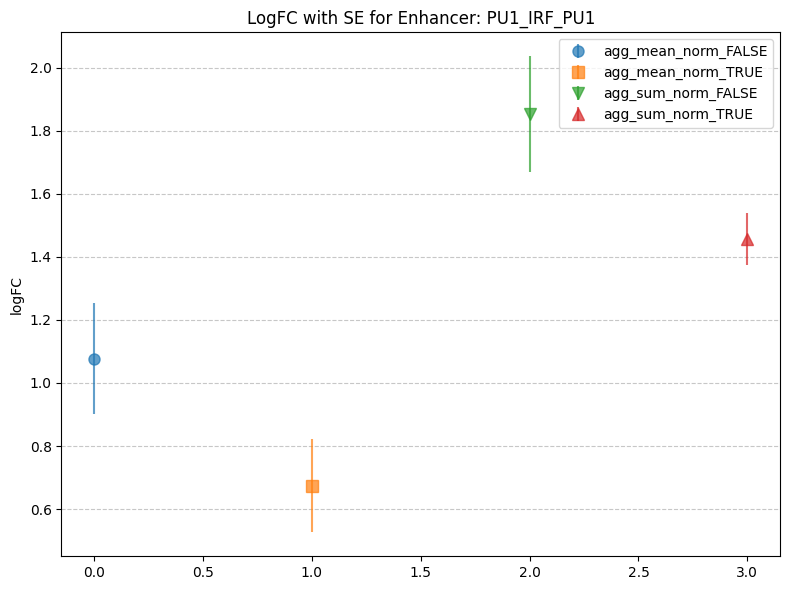

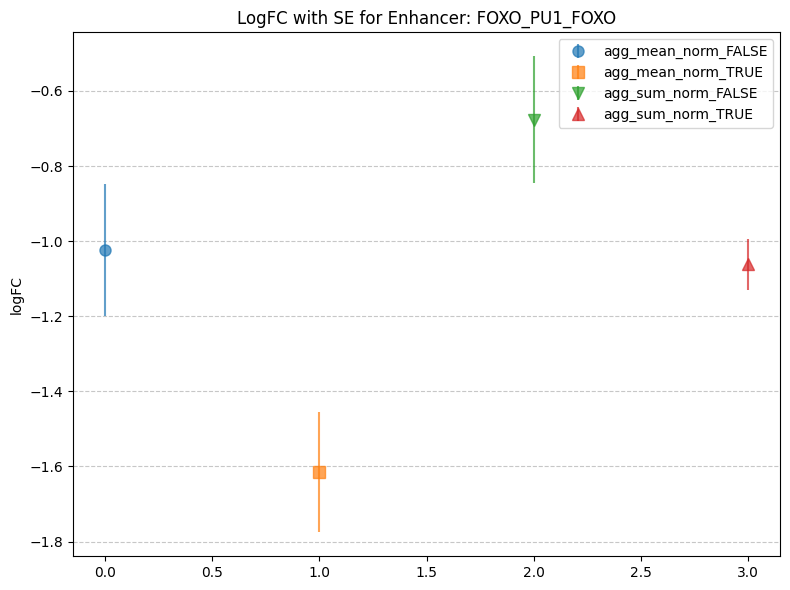

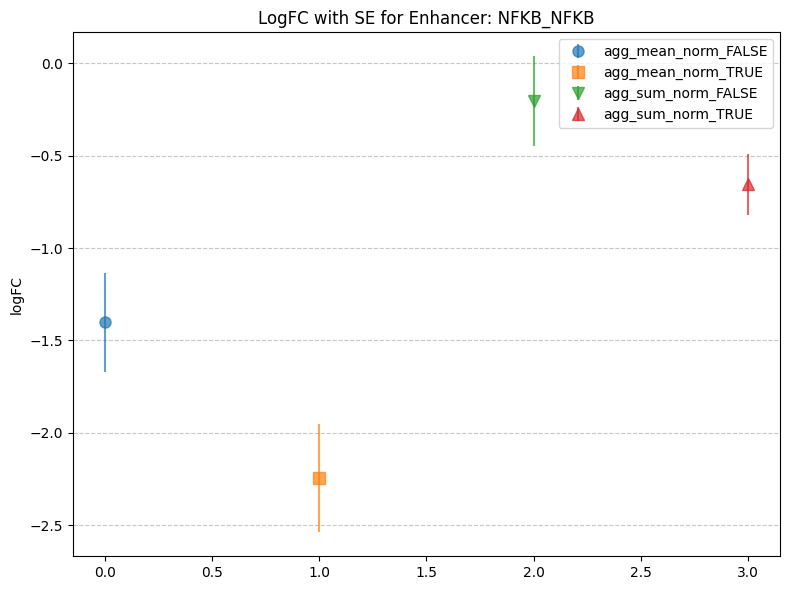

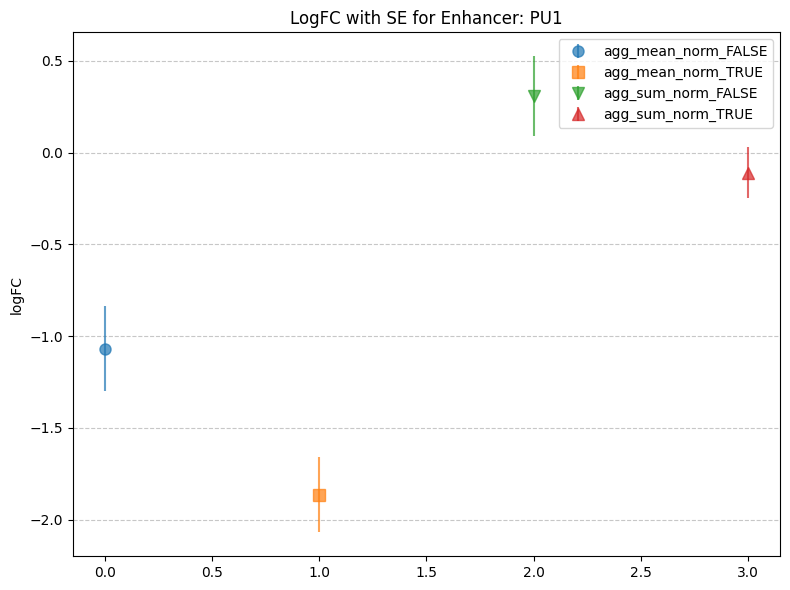

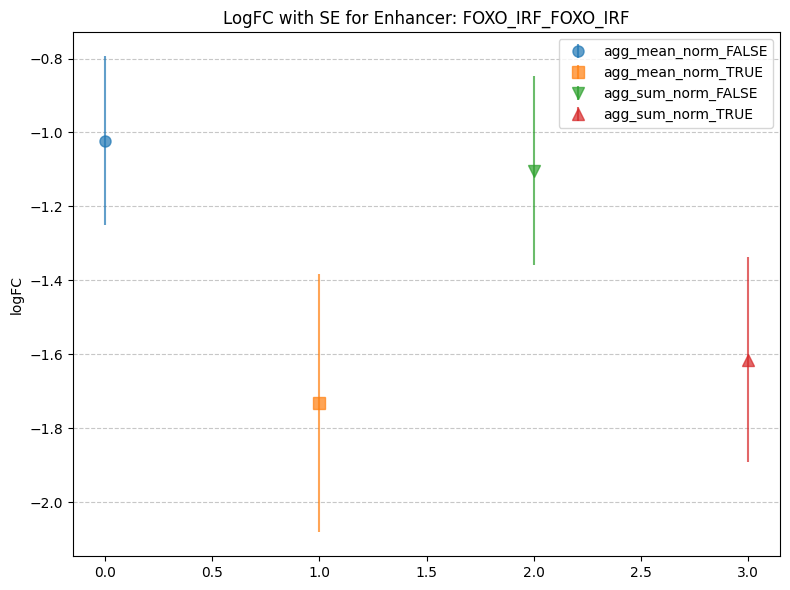

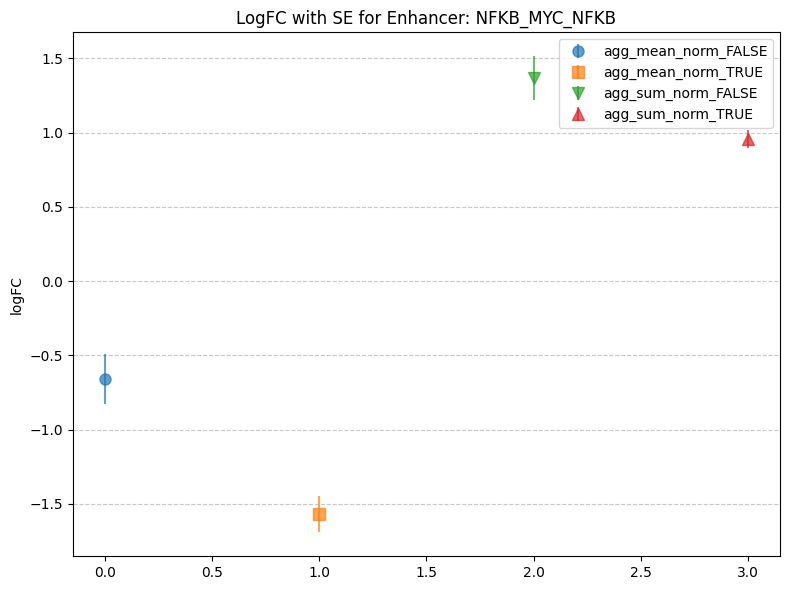

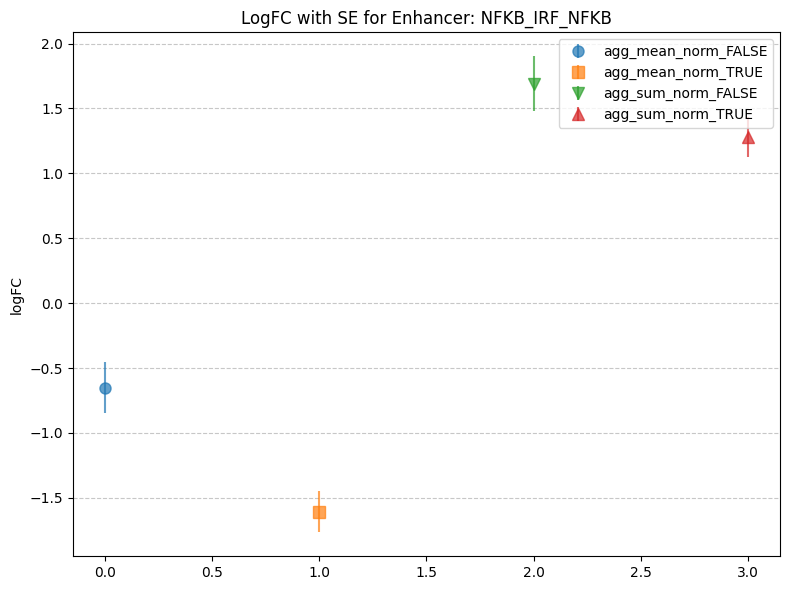

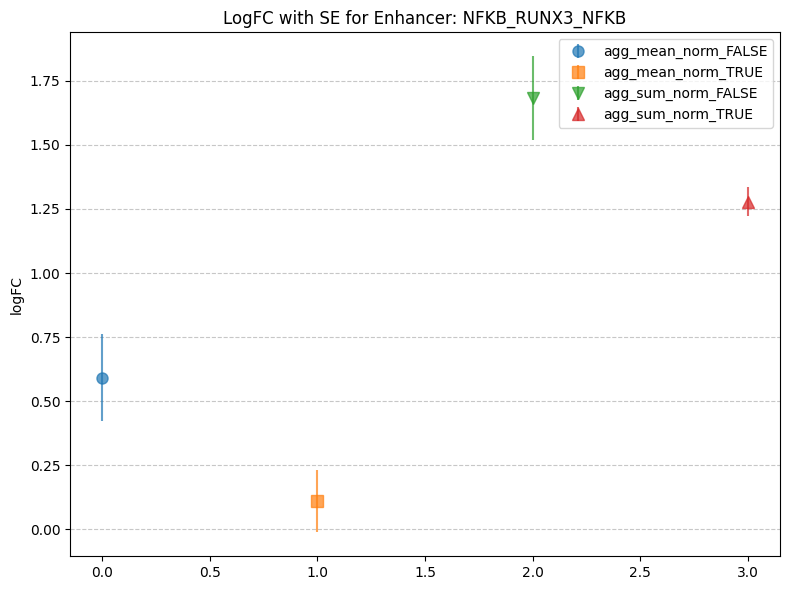

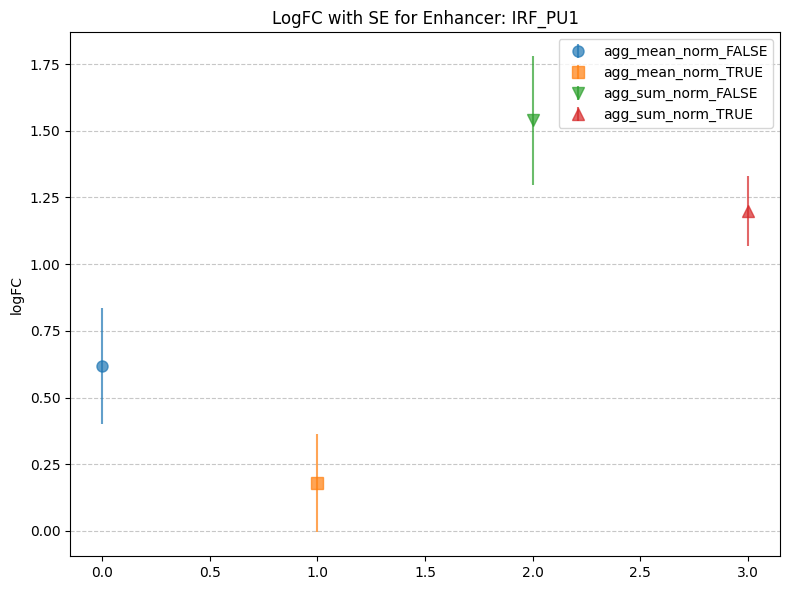

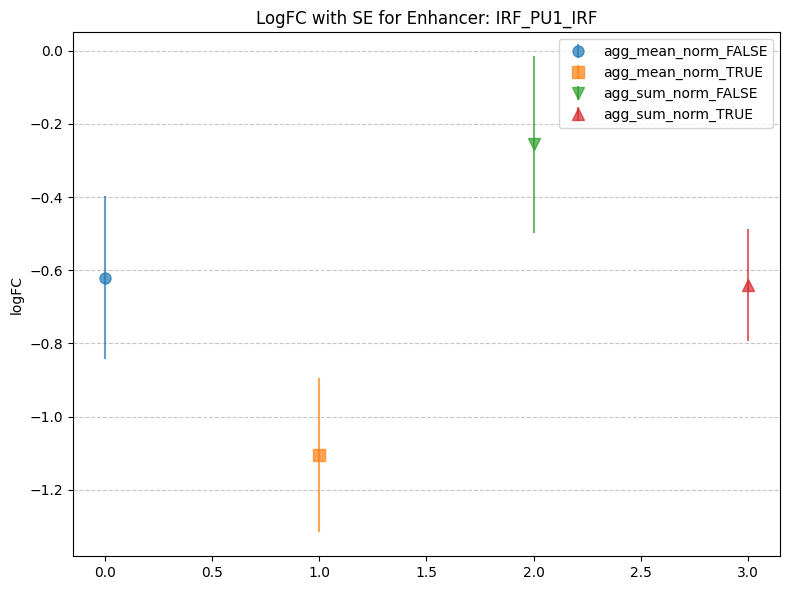

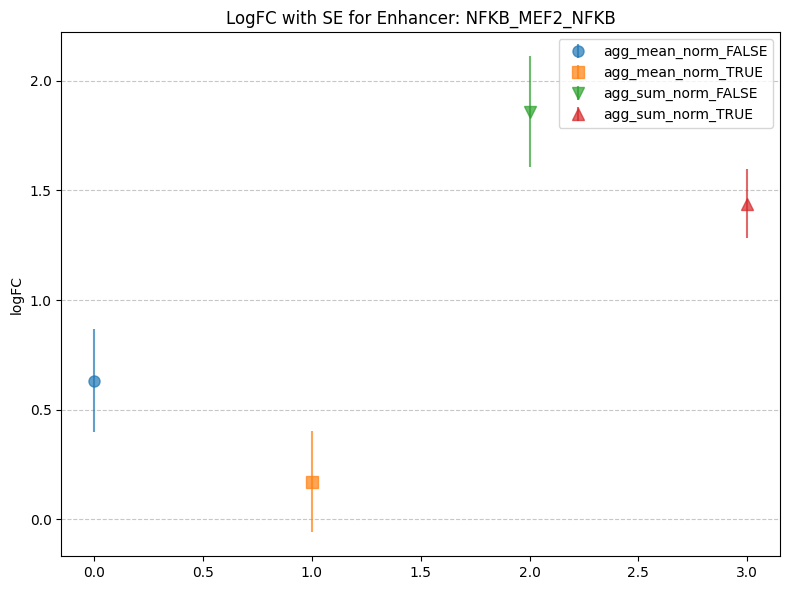

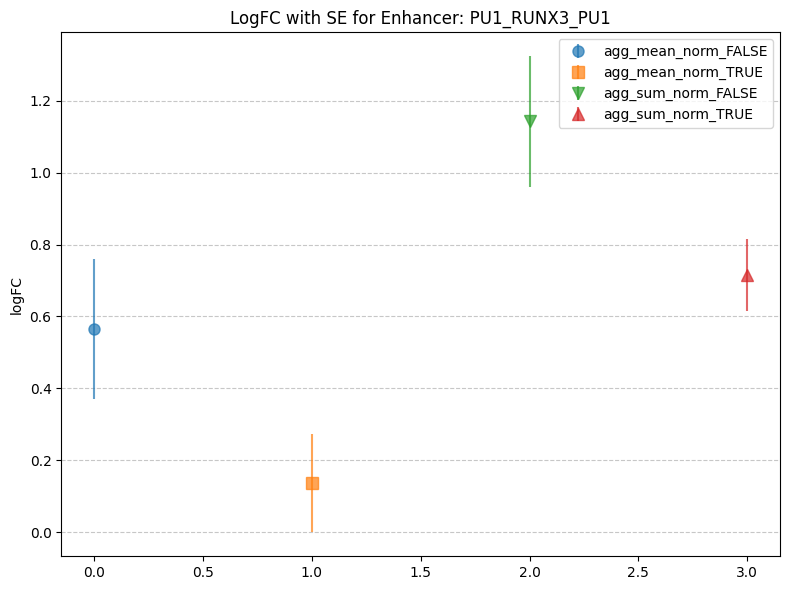

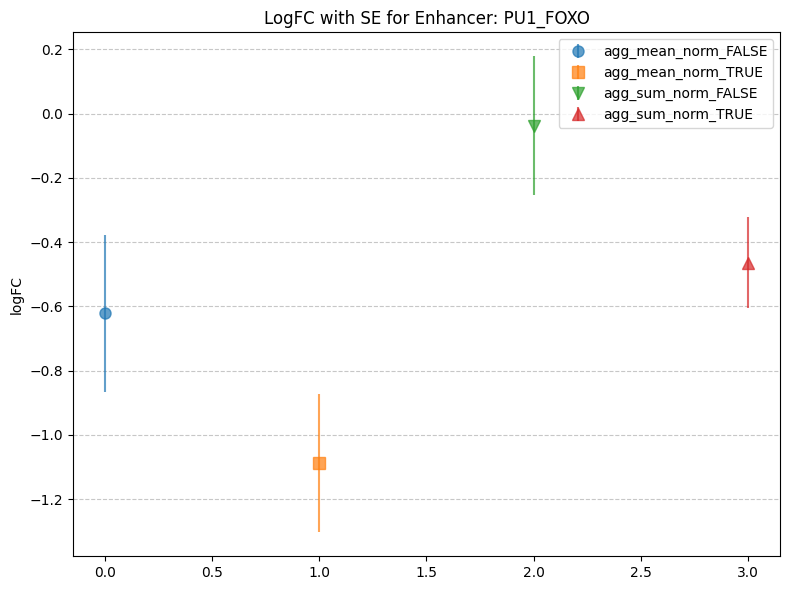

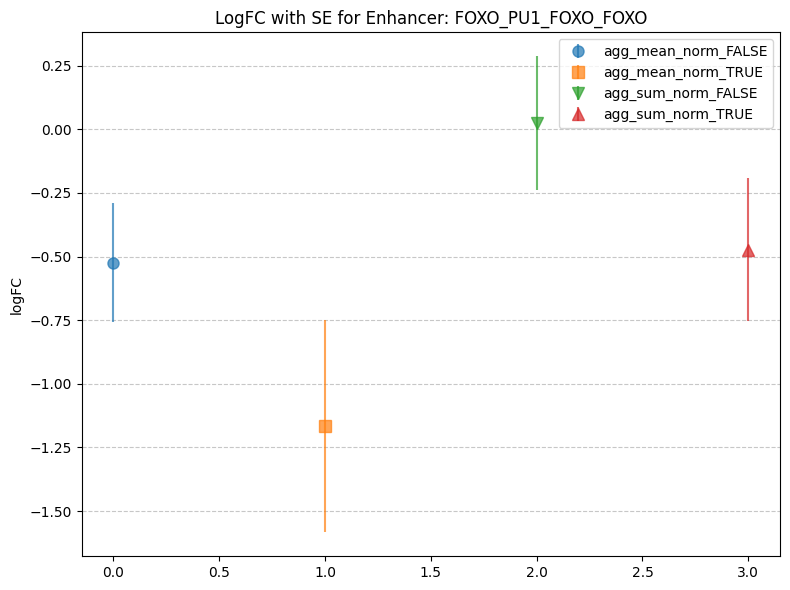

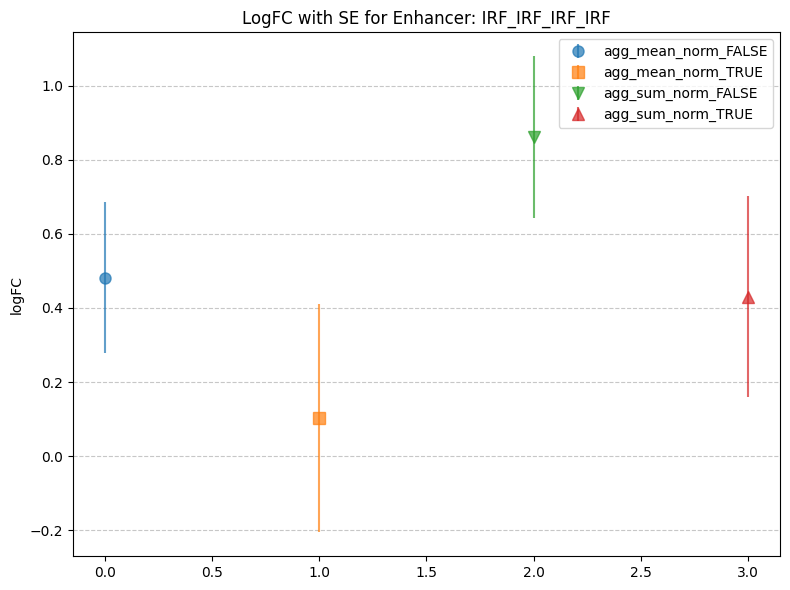

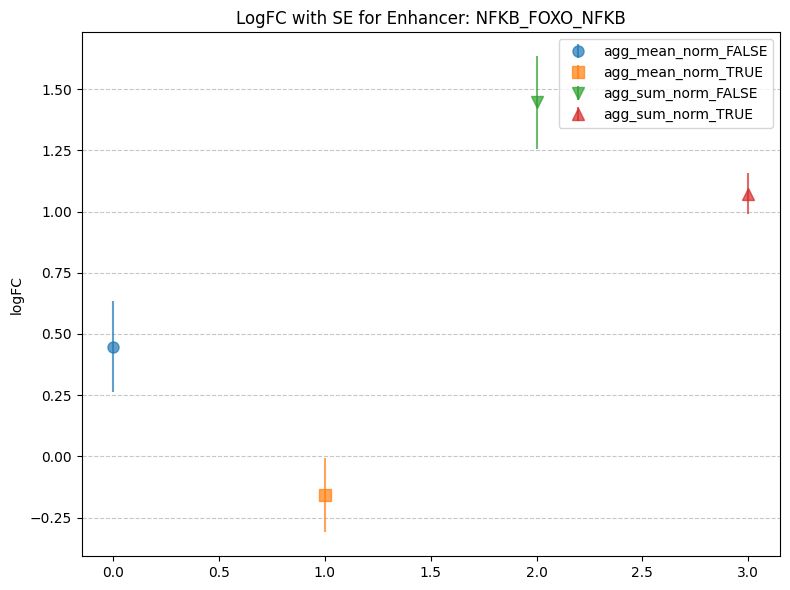

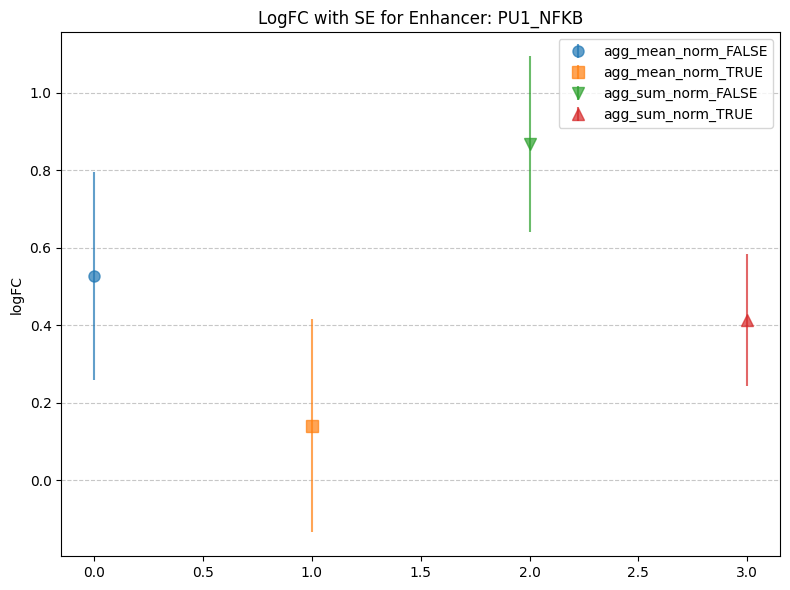

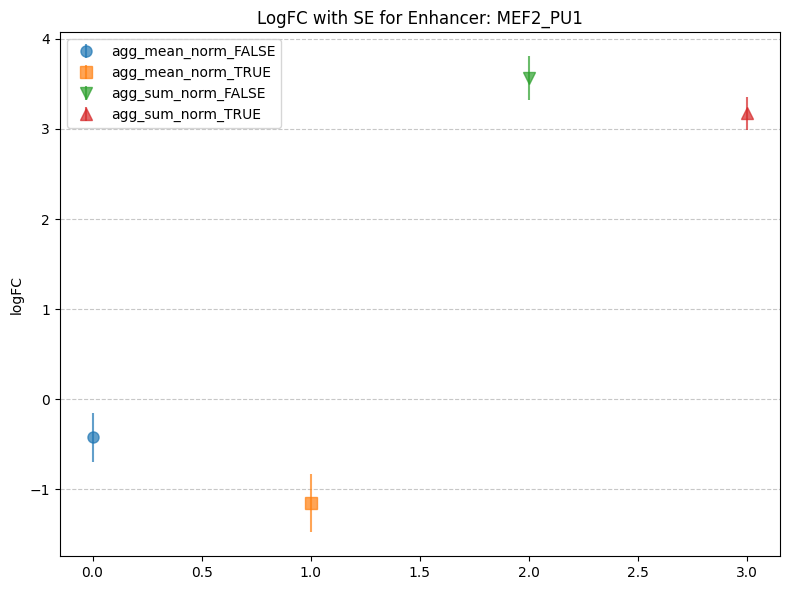

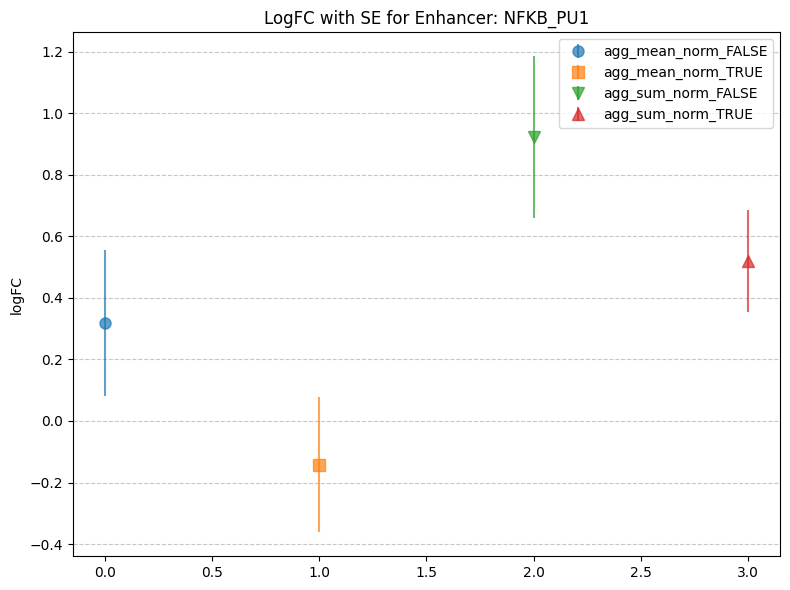

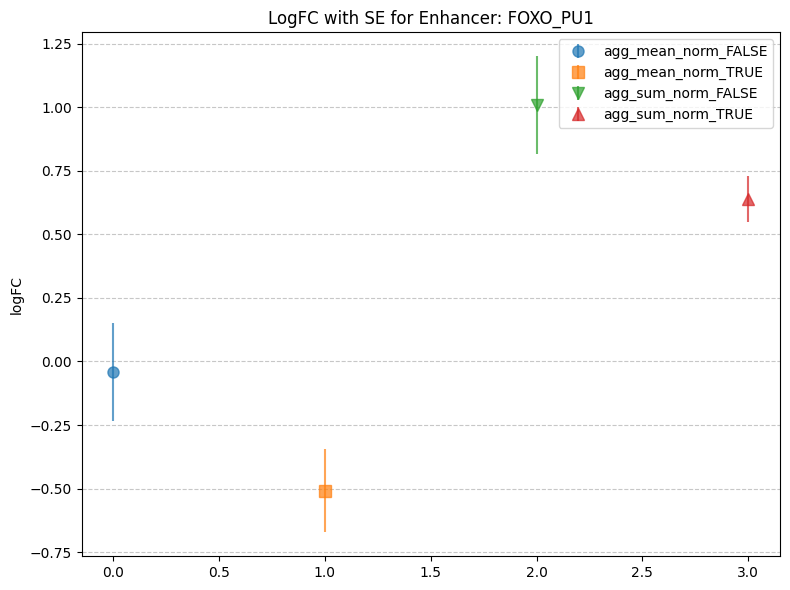

In [6]:
conditions = ['agg_mean_norm_FALSE', 'agg_mean_norm_TRUE', 
              'agg_sum_norm_FALSE', 'agg_sum_norm_TRUE']
marker_styles = ['o', 's', 'v', '^'] 

for enhancer_idx in range(len(merged_df)):
    enhancer_name = merged_df.iloc[enhancer_idx]['Enhancer']
    plt.figure(figsize=(8, 6))
    
    for i, condition in enumerate(conditions):
        logFC_values = merged_df.iloc[enhancer_idx][f'logFC_{condition}']
        SE_values = merged_df.iloc[enhancer_idx][f'SE_{condition}']
        
        plt.errorbar(
            i, logFC_values, yerr=SE_values, fmt=marker_styles[i],
            label=condition, markersize=8, alpha=0.7
        )
    
    plt.ylabel('logFC')
    plt.title(f'LogFC with SE for Enhancer: {enhancer_name}')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.legend()
    
    plot_filename = f"{enhancer_name}_logFC_with_SE.png"
    plt.tight_layout()
    # plt.save_fig(plot_filename)
    plt.show()
    plt.close()

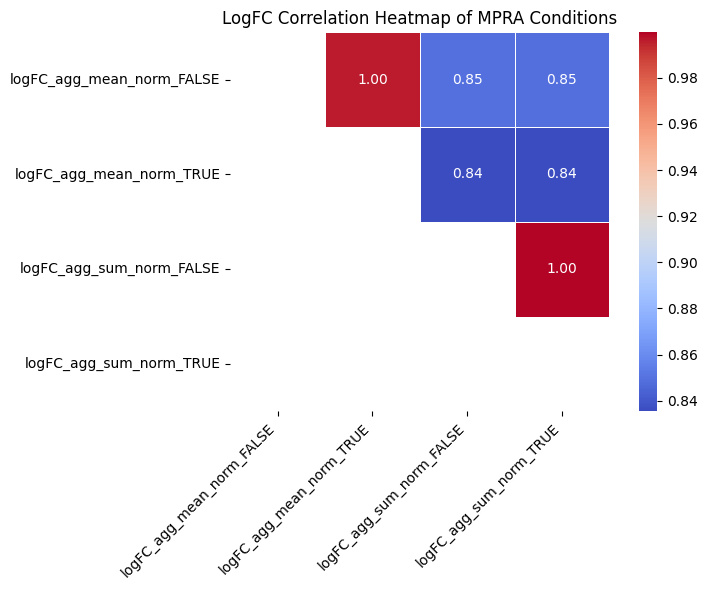

In [7]:
logfc_cols = [col for col in merged_df.columns if col.startswith('logFC')]
logfc_df = merged_df[logfc_cols]

cor_matrix = logfc_df.corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("LogFC Correlation Heatmap of MPRA Conditions")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

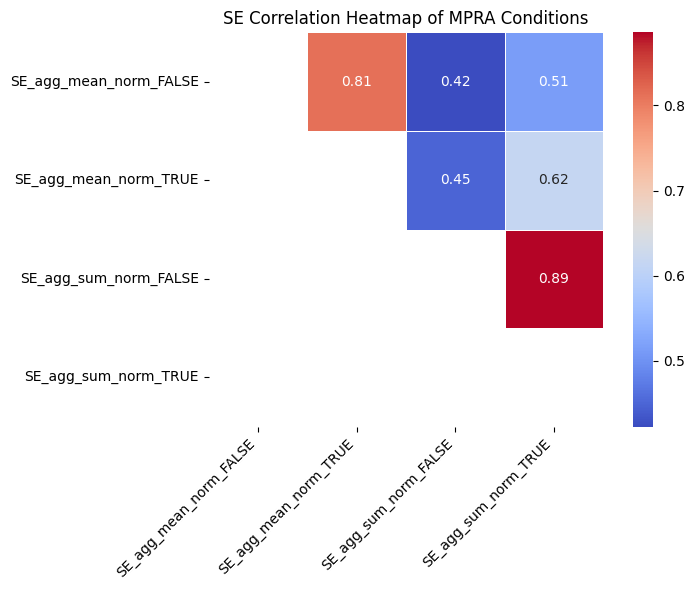

In [8]:
se_cols = [col for col in merged_df.columns if col.startswith('SE')]
se_df = merged_df[se_cols]

cor_matrix = se_df.corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("SE Correlation Heatmap of MPRA Conditions")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
merged_df[merged_df['Enhancer'] == 'PU1_PU1']

logFC_agg_mean_norm_FALSE  SE_agg_mean_norm_FALSE  \
118                   2.050395                0.266155   

     logFC_agg_mean_norm_TRUE  SE_agg_mean_norm_TRUE  \
118                  1.604669               0.267646   

     logFC_agg_sum_norm_FALSE  SE_agg_sum_norm_FALSE  logFC_agg_sum_norm_TRUE  \
118                  3.070537               0.194775                 2.628442   

     SE_agg_sum_norm_TRUE Enhancer  Enhancer_barcode_count  
118              0.165227  PU1_PU1                      48

In [10]:
enhancer_df = mpra_raw_data[mpra_raw_data['Enhancer'] == 'PU1_PU1']
enhancer_df

sequence  gDNA_rep1  gDNA_rep2  gDNA_rep3  gDNA_rep4  mRNA_rep1  \
76    ACCTACGGCCAC        270         84        245          0       2539   
851   AATTGGAAGTCT        112         50         10          0        255   
1081  ATGTGATACACG         47         76          1          5        355   
1485  CCAACAATGGAC        151         93         74         10       1072   
1719  CTCCCGCACATA        399        166         49        402       1626   
1737  GCCTCGCACTAG        238        165          0         39       2042   
2039  TGCTTCAATCGC        188        185        173         36        497   
2208  CTGACGCGTGGC         62         81          0          0         50   
2211  CCCTCGCACGGA        546        316        220        278       8598   
2231  AAGGCCGGCTGG         52          0         49          0        350   
2253  GTCTCGATGGGC         65         62          0         41        260   
2294  GCCAGACGGTAA        218        238        398        139       1623   
2337  TAAACGTGTGCG         76         34         52          1        323   
2391  ACAATTAGAGAA         28         82        102          0        901   
2597  CCACACGCCGGC         74        123          0        263        481   
2892  TACCTGGTGAAC        107        155        106         44       1850   
2997  TGCACATGTCAA         79         20          0        120       1316   
3180  CGAGCGTGTCGT        163          0        105         28       1114   
3219  ATGGATCACGCA         27         41         36          6        659   
3236  CTCCTCCGAATA         69         78         78        151       1605   
3408  TCGGTCGGTAAA        120          0         42        138        744   
3539  AGTTCTGGCTAT        113        136         56        212        916   
3547  GGCGACAATCAC         24         91          0          0        482   
3552  GTTCACCGGTTC        157         30          0         80        762   
3833  TACTACTCACAA         73        104        216         56        495   
3897  TAGAAGTCTCGG        143         11        381        116        789   
3934  GGAAACCCGCTG        103          7         70         13        894   
3977  TGTCAATCACCG         80          0         20        137        222   
4037  TCGCTCTGGTGG         40          0         69          0        109   
4297  CCCCAGGAATGA         78        157         37         48        734   
4494  CCCTGGACCAGC          9         96          0         62        811   
4684  TGAATGGCTGTG         47          0         57         87         22   
4958  GTCATCAGCTTG         28         79         37         16        263   
5225  CGTGACGCTCGG         63        124         88        114          0   
5389  TACGTGACGTTC        101        392         44        205        914   
5414  TCTACCGAATAT         30          0        101          0        501   
5475  CGTGGTATATCC         35         59          0         58        209   
5508  GGCCAGACATTA         39         55          0        134        109   
5818  ATCAGTTACACG         16        164         22         21        409   
5891  GATAATATTGCC         12         21          0         92        446   
5901  AGTTACAAGATC         22          0          0        133        412   
6002  GCAAGGCCCGGA          5          0        139          0        243   
6095  CAGGGGCTAAAG          8         51        108        118        429   
6156  TTGGTTAGTGAT          6         80         33         33          0   
6167  AACATCGCGGAG          5          0        136          0          0   
6358  CGTCTGGACGTA          0         89         40          0          0   
6524  TTGAGCAAGACA          0        118          0        230          0   
6675  TTAAGTGATGTG          0         30         81          0          0   

      mRNA_rep2  mRNA_rep3  mRNA_rep4 Enhancer  
76         2064       2747          0  PU1_PU1  
851         131        184          0  PU1_PU1  
1081        417        677        412  PU1_PU1  
1485       1326       1209       1358  P

In [11]:
gDNA_reps = ['gDNA_rep1', 'gDNA_rep2', 'gDNA_rep3', 'gDNA_rep4']
mRNA_reps = ['mRNA_rep1', 'mRNA_rep2', 'mRNA_rep3', 'mRNA_rep4']

# Sum-based aggregation
gDNA_sum = enhancer_df[gDNA_reps].sum().values
mRNA_sum = enhancer_df[mRNA_reps].sum().values
logFC_sum = np.log2(mRNA_sum / gDNA_sum)
logFC_sum_mean = np.mean(logFC_sum)
logFC_sum_se = np.std(logFC_sum, ddof=1) / np.sqrt(len(logFC_sum))

# Mean-based aggregation: log2(mRNA / gDNA) for each barcode
mRNA_array = enhancer_df[mRNA_reps].values.astype(float)
gDNA_array = enhancer_df[gDNA_reps].values.astype(float)

# Avoid division by zero by masking those cases
with np.errstate(divide='ignore', invalid='ignore'):
    log_ratios_per_barcode = np.log2(np.divide(mRNA_array, gDNA_array))
    log_ratios_per_barcode[~np.isfinite(log_ratios_per_barcode)] = np.nan

# ignore NaNs
logFC_mean = np.nanmean(log_ratios_per_barcode, axis=0) # average logFC across all barcodes' logFCs (for each replicate)
logFC_mean_mean = np.nanmean(logFC_mean) # average across replicates
logFC_mean_se = np.nanstd(logFC_mean, ddof=1) / np.sqrt(np.sum(~np.isnan(logFC_mean)))

print(f"Sum Aggregation -> logFC: {logFC_sum_mean:.4f}, SE: {logFC_sum_se:.4f}")
print(f"Mean Aggregation (barcode-wise logFC) -> logFC: {logFC_mean_mean:.4f}, SE: {logFC_mean_se:.4f}")

Sum Aggregation -> logFC: 3.0711, SE: 0.0354
Mean Aggregation (barcode-wise logFC) -> logFC: 2.9415, SE: 0.1284


In [12]:
print(logFC_mean)
print(logFC_sum)

[3.09639029 2.64894266 2.8118853  3.20893045]
[3.15049811 3.04311849 3.10283936 2.98774858]
